# Plotting Average LST over time and Differences-in-Differences Regression  
## Including Prior Trends Test, Test for Long-term Effects

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
from linearmodels.panel import PanelOLS
import re  # For extracting numbers from the interaction term strings
import matplotlib.dates as mdates
import numpy as np

## Bukit Purmei 2018 - 2024

### Filtering criteria for clouds

In [575]:
# Paths to the CSV files
file_path1 = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\BukitPurmei\Landsat8\BukitPurmei_Filtered_2018_to_2024_Blocks.csv"
file_path2 = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\BukitPurmei\Landsat7\BukitPurmei_Filtered_2018_to_2022_Blocks.csv"
file_path3 = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\BukitPurmei\Landsat9\BukitPurmei_Filtered_2021_to_2024_Blocks.csv"

# Read the CSV files
df1 = pd.read_csv(file_path1)
df2 = pd.read_csv(file_path2)
df3 = pd.read_csv(file_path3)

# Concatenate the two dataframes
bukit_purmei_df = pd.concat([df1, df2, df3], ignore_index=True)

bukit_purmei_df['QA_PIXEL'] = bukit_purmei_df['QA_PIXEL'].fillna(-1).astype(int)
all_unique_values = set(bukit_purmei_df['QA_PIXEL'].unique())

def convert_to_binary_16(value):
    # Convert value to binary, padded to 16 bits
    if value == -1:
        return 'NaN'  # Return a string 'NaN' for placeholder
    binary_string = format(value, '016b')
    # Split the binary string into 4 groups of 4 digits each
    return ' '.join([binary_string[i:i+4] for i in range(0, 16, 4)])

# Convert and print all unique values
for value in all_unique_values:
    binary_representation = convert_to_binary_16(value)
    print(f'Original: {value}, Binary: {binary_representation}')

Original: 5504, Binary: 0001 0101 1000 0000
Original: 22018, Binary: 0101 0110 0000 0010
Original: 21762, Binary: 0101 0101 0000 0010
Original: 22280, Binary: 0101 0111 0000 1000
Original: 5896, Binary: 0001 0111 0000 1000
Original: 7440, Binary: 0001 1101 0001 0000
Original: 23826, Binary: 0101 1101 0001 0010
Original: 24082, Binary: 0101 1110 0001 0010
Original: 7698, Binary: 0001 1110 0001 0010
Original: 7442, Binary: 0001 1101 0001 0010
Original: 56854, Binary: 1101 1110 0001 0110
Original: 56598, Binary: 1101 1101 0001 0110
Original: 21824, Binary: 0101 0101 0100 0000
Original: 22080, Binary: 0101 0110 0100 0000
Original: 5440, Binary: 0001 0101 0100 0000
Original: 5442, Binary: 0001 0101 0100 0010
Original: 5698, Binary: 0001 0110 0100 0010
Original: 5696, Binary: 0001 0110 0100 0000
Original: 54596, Binary: 1101 0101 0100 0100
Original: 24144, Binary: 0101 1110 0101 0000
Original: 23888, Binary: 0101 1101 0101 0000
Original: 56916, Binary: 1101 1110 0101 0100


In [ ]:
# Filtering Criteria (1):
# qa_pixel_filter_1 = [5504, 22280, 5896, 7440, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 24144, 23888, 56916]
# sr_qa_aerosol_filter_1 = [192, 194, 196, 224, 228]

# Filtering Criteria (2):
# qa_pixel_filter_2 = [5504, 22280, 5896, 7440, 23826, 56854, 24082, 56598, 7698, 7442, 24144, 23888, 56916]
# sr_qa_aerosol_filter_1 = [192, 194, 196]

### Plot for Average LST against Time

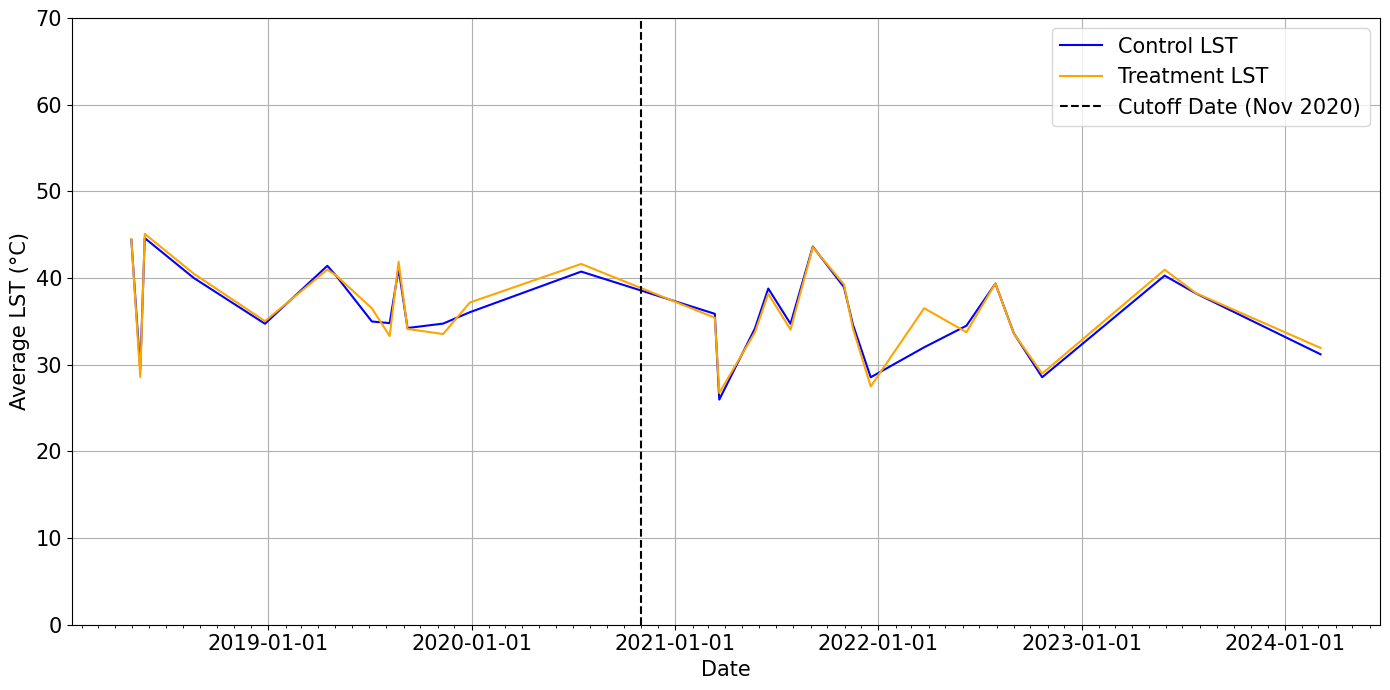

In [270]:
# Paths to the CSV files
file_path1 = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\BukitPurmei\Landsat8\BukitPurmei_Filtered_2018_to_2024_Blocks.csv"
file_path2 = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\BukitPurmei\Landsat7\BukitPurmei_Filtered_2018_to_2022_Blocks.csv"
file_path3 = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\BukitPurmei\Landsat9\BukitPurmei_Filtered_2021_to_2024_Blocks.csv"

# Read the CSV files
df1 = pd.read_csv(file_path1)
df2 = pd.read_csv(file_path2)
df3 = pd.read_csv(file_path3)

# Rename temperature columns to a unified column name
df1.rename(columns={'ST_B10_Celsius': 'LST_Celsius'}, inplace=True)
df2.rename(columns={'ST_B6_Celsius': 'LST_Celsius'}, inplace=True)
df3.rename(columns={'ST_B10_Celsius': 'LST_Celsius'}, inplace=True)

# Concatenate the two dataframes
bukit_purmei_df = pd.concat([df1, df2, df3], ignore_index=True)

# Convert 'time' to datetime and filter
bukit_purmei_df['time'] = pd.to_datetime(bukit_purmei_df['time'])

# Filter out unwanted QA_PIXEL and SR_QA_AEROSOL values
qa_pixel_filter_1 = [5504, 22280, 5896, 7440, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 24144, 23888, 56916]
sr_qa_aerosol_filter_1 = [192, 194, 196, 224, 228]
bukit_purmei_df = bukit_purmei_df[~bukit_purmei_df['QA_PIXEL'].isin(qa_pixel_filter_1)]
bukit_purmei_df = bukit_purmei_df[~bukit_purmei_df['SR_QA_AEROSOL'].isin(sr_qa_aerosol_filter_1)]

# Map blocks to grouped blocks
block_group_map = {
    'polygon_112': 'Treatment',
    'polygon_114': 'Treatment',
    'polygon_113': 'Control',
    'polygon_115': 'Control'
}
bukit_purmei_df['group'] = bukit_purmei_df['block'].map(block_group_map)

# Group by 'group' and 'time', and calculate the average LST
grouped_data = bukit_purmei_df.groupby(['group', bukit_purmei_df['time'].dt.date])['LST_Celsius'].mean().unstack(0)
grouped_data = grouped_data.dropna(how='any', axis=0)

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))

# Colors for each group
colors = {'Treatment': 'orange', 'Control': 'blue'}

# Plot each column as a line in the plot
for column in grouped_data.columns:
    ax.plot(grouped_data.index, grouped_data[column], label=f'{column} LST', color=colors[column])

# Formatting Date Axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Mark the treatment date
cutoff_date = pd.Timestamp('2020-11-01')
plt.axvline(x=cutoff_date, color='black', linestyle='--', label='Cutoff Date (Nov 2020)')

# Set plot attributes with increased font sizes
# ax.set_title('Average LST Over Time (Bukit Purmei)', fontsize=20)
ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('Average LST (°C)', fontsize=15)
ax.set_ylim(bottom=0, top=70)
ax.grid(True)
ax.legend(fontsize=15)

# Adjust tick parameters
ax.tick_params(axis='both', labelsize=15)  # Adjust font size for both x and y tick labels

# Rotate date labels for clarity
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
plt.tight_layout()
plt.show()

In [99]:
# Extract the count of pixels for both the treatment and control groups
pixel_count = bukit_purmei_df.groupby(['group', bukit_purmei_df['time'].dt.date]).size().unstack(0)

# Drop rows where any data is missing in either 'treatment' or 'control'
pixel_count.dropna(how='any', inplace=True)

# Print out the number of pixels for the treatment centre on dates where both groups are present
print("Number of pixels (rows) for the treatment hawker centre by date:")
print(pixel_count['Treatment'])
print(pixel_count['Control'])

Number of pixels (rows) for the treatment hawker centre by date:
time
2018-04-30    16.0
2018-05-16    18.0
2018-05-24    11.0
2018-08-20    18.0
2018-12-26    18.0
2019-04-17    18.0
2019-05-03    18.0
2019-07-06    18.0
2019-08-07     6.0
2019-08-23    18.0
2019-09-08    12.0
2019-11-11    18.0
2019-12-29    18.0
2020-07-16     2.0
2021-03-13     9.0
2021-03-21    17.0
2021-05-24     8.0
2021-06-17    15.0
2021-07-27    15.0
2021-09-05    16.0
2021-10-31    18.0
2021-11-16    18.0
2021-12-18    18.0
2022-03-24    20.0
2022-06-08    17.0
2022-07-30    10.0
2022-09-01    17.0
2022-10-22    11.0
2023-05-30    12.0
2023-07-25    16.0
2024-03-05     2.0
Name: Treatment, dtype: float64
time
2018-04-30     8.0
2018-05-16    15.0
2018-05-24    15.0
2018-08-20    15.0
2018-12-26    15.0
2019-04-17    15.0
2019-05-03    15.0
2019-07-06    14.0
2019-08-07     8.0
2019-08-23    15.0
2019-09-08     7.0
2019-11-11    15.0
2019-12-29    15.0
2020-07-16     4.0
2021-03-13     1.0
2021-03-21    11.0


In [109]:
# List of zip file paths
zip_file_paths = [
    r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\Landsat5\L5_Metadata.zip",
    r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\Landsat7\L7_Metadata.zip",
    r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\Landsat8\L8_Metadata.zip",
    r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\Landsat9\L9_Metadata.zip"
]

# DataFrame to store all metadata
all_metadata = pd.DataFrame(columns=['DATE_ACQUIRED', 'CLOUD_COVER'])

# Process each zip file
for zip_file_path in zip_file_paths:
    with zipfile.ZipFile(zip_file_path, 'r') as z:
        # List all contained files that end with .csv
        csv_files = [f for f in z.namelist() if f.endswith('.csv')]
        
        # Process each CSV file
        for csv_file in csv_files:
            with z.open(csv_file) as f:
                # Read the file into a pandas DataFrame, focusing only on needed columns
                df = pd.read_csv(f, usecols=['DATE_ACQUIRED', 'CLOUD_COVER'])
                
                # Append to the main DataFrame
                all_metadata = pd.concat([all_metadata, df], ignore_index=True)

# Print or use the DataFrame as needed
print(all_metadata.head())  # Display the first few rows to check

  DATE_ACQUIRED  CLOUD_COVER
0    2011-01-13         80.0
1    2011-02-14         26.0
2    2009-09-04         50.0
3    2008-10-19         25.0
4    2008-11-04         14.0


In [112]:
# Assuming pixel_count and all_metadata are already defined and loaded

# Ensure that 'DATE_ACQUIRED' is in datetime format in the all_metadata DataFrame
all_metadata['DATE_ACQUIRED'] = pd.to_datetime(all_metadata['DATE_ACQUIRED'])

# Extract the unique dates from the pixel_count DataFrame, ensuring they are in datetime format
# Assuming pixel_count index is already in datetime format, if not, convert it
unique_dates = pixel_count.index.unique()

# Filter the all_metadata DataFrame to include only entries from the unique_dates
filtered_metadata = all_metadata[all_metadata['DATE_ACQUIRED'].isin(unique_dates)]

# Calculate the maximum CLOUD_COVER for each date
max_cloud_cover = filtered_metadata.groupby('DATE_ACQUIRED')['CLOUD_COVER'].max()

# Print or return the results
print(max_cloud_cover)

DATE_ACQUIRED
2018-04-30    17.00
2018-05-16    41.00
2018-05-24     5.68
2018-08-20    39.00
2018-12-26    57.00
2019-04-17    30.00
2019-05-03    17.00
2019-07-06    14.00
2019-08-07    41.00
2019-08-23    20.00
2019-09-08    14.00
2019-11-11    36.00
2019-12-29    25.00
2020-07-16    10.68
2021-03-13    31.30
2021-03-21    36.00
2021-05-24    11.00
2021-06-17    14.10
2021-07-27    12.00
2021-09-05    40.87
2021-10-31    29.44
2021-11-16     5.00
2021-12-18    77.00
2022-03-24    33.00
2022-06-08     8.00
2022-07-30    35.36
2022-09-01     6.00
2022-10-22    48.00
2023-05-30    12.30
2023-07-25    12.74
2024-03-05    73.40
Name: CLOUD_COVER, dtype: float64


### Differences-in-Differences Regression

##### Coefficient of `treatment:treatment_date` is -0.2873 and is statistically significant

##### Using PanelOLS (Clustered Standard Errors)

Block-level Analysis

In [210]:
# Convert 'time' column to datetime if it's not already
bukit_purmei_df['time'] = pd.to_datetime(bukit_purmei_df['time'])

# Create 'treatment' column where 'Treatment' group members receive 1, others 0
bukit_purmei_df['treatment'] = (bukit_purmei_df['group'] == 'Treatment').astype(int)

# Create 'time' column for post-treatment period (November 2020 onwards), assigning 1 for post-treatment and 0 otherwise
cutoff_date = pd.Timestamp('2020-11-01')
bukit_purmei_df['treatment_date'] = (bukit_purmei_df['time'].dt.date >= cutoff_date.date()).astype(int)

# Assuming 'block' is the identifier for different observational unitsqa_pixel_filter_2
bukit_purmei_df = bukit_purmei_df.set_index(['block', 'time'], drop=False)

In [211]:
# Define the formula for the regression model
formula = 'LST_Celsius ~ 1 + EntityEffects + TimeEffects + treatment:treatment_date'

# Fit the DiD regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=bukit_purmei_df)

# Print the results
results = model.fit(cov_type='clustered', cluster_entity=True)

print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.0050
Estimator:                   PanelOLS   R-squared (Between):             -0.2359
No. Observations:                 849   R-squared (Within):               0.0061
Date:                Fri, Jul 19 2024   R-squared (Overall):              0.0018
Time:                        11:22:30   Log-likelihood                   -1118.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3.9641
Entities:                           4   P-value                           0.0468
Avg Obs:                       212.25   Distribution:                   F(1,793)
Min Obs:                       118.00                                           
Max Obs:                       270.00   F-statistic (robust):             6.8844
                            

Pixel-level Analysis

In [226]:
# Assume 'block' and coordinates 'x' and 'y' uniquely identify each pixel
bukit_purmei_df['pixel_id'] = bukit_purmei_df['block'].astype(str) + '_' + bukit_purmei_df['Longitude'].astype(str) + '_' + bukit_purmei_df['Latitude'].astype(str)

# Convert 'time' column to datetime if it's not already
bukit_purmei_df['time'] = pd.to_datetime(bukit_purmei_df['time'])

# Create 'treatment' column where 'Treatment' group members receive 1, others 0
bukit_purmei_df['treatment'] = (bukit_purmei_df['group'] == 'Treatment').astype(int)

# Create 'time' column for post-treatment period (November 2020 onwards), assigning 1 for post-treatment and 0 otherwise
cutoff_date = pd.Timestamp('2020-11-01')
bukit_purmei_df['treatment_date'] = (bukit_purmei_df['time'].dt.date >= cutoff_date.date()).astype(int)

# Assuming 'block' is the identifier for different observational unitsqa_pixel_filter_2
bukit_purmei_df = bukit_purmei_df.set_index(['pixel_id', 'time'], drop=False)

In [227]:
# Define the formula for the regression model
formula = 'LST_Celsius ~ 1 + EntityEffects + TimeEffects + treatment:treatment_date'

# Fit the DiD regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=bukit_purmei_df)

# Print the results
results = model.fit(cov_type='clustered', clusters=bukit_purmei_df['block'])

print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.0054
Estimator:                   PanelOLS   R-squared (Between):             -0.1835
No. Observations:                 849   R-squared (Within):               0.0065
Date:                Fri, Jul 19 2024   R-squared (Overall):              0.0018
Time:                        11:59:43   Log-likelihood                   -1076.2
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.1328
Entities:                          33   P-value                           0.0424
Avg Obs:                       25.727   Distribution:                   F(1,764)
Min Obs:                       19.000                                           
Max Obs:                       38.000   F-statistic (robust):             4.1461
                            

### Prior Trends Test

##### Coefficient of `int_time_group` is 0.0735 and is not statistically significant.

In [1104]:
df = bukit_purmei_df

# Define the cutoff date
cutoff_date = pd.Timestamp('2020-11-01')

# Filter the dataset to include only data before the cutoff date
df_pre = df[df['time'] < cutoff_date].copy()

# Ensure 'block' is a column if not already
df_pre['block'] = df_pre['block'] if 'block' in df_pre.columns else range(len(df_pre))

# Convert 'time' to datetime format if not already
df_pre['time'] = pd.to_datetime(df_pre['time'])

# Set the index to 'block' and 'time' for Panel data format
df_pre = df_pre.set_index(['block', 'time'])

# Create the time variable as the number of periods from the start of the data
df_pre['time_periods'] = pd.factorize(df_pre.index.get_level_values('time').date)[0]

# Create interaction term for Time * Group
df_pre['group_binary'] = df_pre['group'].map({'Treatment': 1, 'Control': 0})
df_pre['int_time_group'] = df_pre['time_periods'] * df_pre['group_binary']

# Define the formula for PanelOLS
# As per Equation (18.3) in Chapter 18
formula = 'LST_Celsius ~ 1 + time_periods + group_binary + int_time_group'

# Fit the regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=df_pre)
fitted_model = model.fit(cov_type='clustered', cluster_entity=True)

# Print the summary of the regression model
print(fitted_model)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.1400
Estimator:                   PanelOLS   R-squared (Between):              0.3773
No. Observations:                 405   R-squared (Within):               0.1396
Date:                Thu, Jul 11 2024   R-squared (Overall):              0.1400
Time:                        16:47:15   Log-likelihood                   -1163.6
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      21.768
Entities:                           4   P-value                           0.0000
Avg Obs:                       101.25   Distribution:                   F(3,401)
Min Obs:                       68.000                                           
Max Obs:                       121.00   F-statistic (robust):          1.127e+15
                            

In [208]:
df = bukit_purmei_df

# Define the cutoff date for treatment
cutoff_date = pd.Timestamp('2020-11-01')

# Convert 'time' to datetime format if not already
df['time'] = pd.to_datetime(df['time'])

# Filter the dataset to include only data before and on/after the cutoff date
df_pre = df[df['time'] < cutoff_date].copy()
df_post = df[df['time'] >= cutoff_date].copy()

# Set the index to 'block' and 'time' for Panel data format for both periods
df_pre = df_pre.set_index(['block', 'time'])
df_post = df_post.set_index(['block', 'time'])

# Create the time variable as the number of periods from the start of the data
df_pre['time_periods'] = pd.factorize(df_pre.index.get_level_values('time').date)[0]

# Create interaction term for Time * Group for both datasets
df_pre['group_binary'] = df_pre['group'].map({'Treatment': 1, 'Control': 0})
df_pre['int_time_group'] = df_pre['time_periods'] * df_pre['group_binary']

# Define the formula for PanelOLS
formula = 'LST_Celsius ~ 1 + time_periods + group_binary + int_time_group'

# Fit the regression model using PanelOLS from linearmodels for both pre and post-treatment data
model_pre = PanelOLS.from_formula(formula, data=df_pre)
fitted_model_pre = model_pre.fit(cov_type='clustered', cluster_entity=True)

# Calculate the total number of observations (block-time combinations) in both pre and post periods
total_observations_pre = len(df_pre)
total_observations_post = len(df_post)

# Print the summary of the regression models and the observation counts
# print(f"Pre-Treatment Model Summary:\n{fitted_model_pre}")
print(f"Total observations in pre-treatment period: {total_observations_pre}")
print(f"Total observations in post-treatment period: {total_observations_post}")

Total observations in pre-treatment period: 405
Total observations in post-treatment period: 444


### Long-term Effects

In [1105]:
# Creating 'time_periods' variable, factorising 'time' column
bukit_purmei_df['time_periods'] = pd.factorize(bukit_purmei_df.index.get_level_values('time').date)[0]

# Finding the first treatment_date == 1
filtered_df = bukit_purmei_df[bukit_purmei_df['treatment_date'] == 1]

# Find the earliest date in the 'time' column for these rows
earliest_date = filtered_df['time'].min()

# Get the corresponding value in 'time_periods' for the earliest date
corresponding_time_period = filtered_df[filtered_df['time'] == earliest_date]['time_periods'].iloc[0]

# Print the earliest date and the corresponding 'time_periods' value
print("The earliest date for 'treatment_date' == 1 is:", earliest_date)
print("The corresponding value in 'time_periods' is:", corresponding_time_period)

The earliest date for 'treatment_date' == 1 is: 2020-12-15 00:00:00
The corresponding value in 'time_periods' is: 32


In [1106]:
# Scale time periods, drop period right before treatment period
bukit_purmei_df['time_periods_scaled'] = bukit_purmei_df.time_periods - 31

In [1107]:
# Filtering valid time periods (where both control and treatment data exist)

# Subset to dates with both control and treated blocks
grouped = bukit_purmei_df.groupby(['group', pd.Grouper(freq='D', level='time')]).size().unstack(fill_value=0)
both_groups_present = (grouped.loc['Treatment'] > 0) & (grouped.loc['Control'] > 0)
valid_periods = both_groups_present[both_groups_present].index
#print(valid_periods)

#Subset the data to only include periods with control and treatment group, just in case error is due to this. but it is not, i.e., doing this step or not leads to the same error

bukit_purmei_df['date'] = bukit_purmei_df['time'].dt.date  # Extract date from datetime for comparison
valid_periods_set = set(valid_periods.date)  # Convert valid periods to a set of dates for efficient filtering

# Filter the DataFrame
bukit_purmei_subset_df = bukit_purmei_df[bukit_purmei_df['date'].isin(valid_periods_set)].copy()

#See the periods that we are left

# Get all values in 'time' column
unique_time_values = bukit_purmei_subset_df['time'].unique()
print(unique_time_values)

unique_period_values = bukit_purmei_subset_df['time_periods_scaled'].unique()
print(unique_period_values)

['2018-05-24T00:00:00.000000000' '2020-07-16T00:00:00.000000000'
 '2021-03-13T00:00:00.000000000' '2021-06-17T00:00:00.000000000'
 '2021-09-05T00:00:00.000000000' '2023-07-25T00:00:00.000000000'
 '2024-03-05T00:00:00.000000000' '2018-04-30T00:00:00.000000000'
 '2018-05-16T00:00:00.000000000' '2018-08-20T00:00:00.000000000'
 '2018-12-26T00:00:00.000000000' '2019-04-17T00:00:00.000000000'
 '2019-05-03T00:00:00.000000000' '2019-07-06T00:00:00.000000000'
 '2019-08-07T00:00:00.000000000' '2019-08-23T00:00:00.000000000'
 '2019-09-08T00:00:00.000000000' '2019-11-11T00:00:00.000000000'
 '2019-12-29T00:00:00.000000000' '2021-03-21T00:00:00.000000000'
 '2021-05-24T00:00:00.000000000' '2021-07-27T00:00:00.000000000'
 '2021-10-31T00:00:00.000000000' '2021-11-16T00:00:00.000000000'
 '2021-12-18T00:00:00.000000000' '2022-03-24T00:00:00.000000000'
 '2022-06-08T00:00:00.000000000' '2022-09-01T00:00:00.000000000'
 '2022-10-22T00:00:00.000000000' '2022-07-30T00:00:00.000000000'
 '2023-05-30T00:00:00.000

In [1108]:
#Set index again to be sure
bukit_purmei_subset_df = bukit_purmei_subset_df.set_index(['block', 'time_periods_scaled'], drop=False)

In [1109]:
# Ensure 'time_periods_scaled' is treated as a categorical variable
bukit_purmei_subset_df['time_periods'] = bukit_purmei_subset_df['time_periods'].astype('category')

# Create dummy variables for 'time_periods_scaled'
time_dummies = pd.get_dummies(bukit_purmei_subset_df['time_periods'], prefix='T')

time_dummies.head()

T_1  T_5  T_7  T_9  T_11  T_14  T_17  T_18  \
block       time_periods_scaled                                               
polygon_114 -30                    1    0    0    0     0     0     0     0   
            -30                    1    0    0    0     0     0     0     0   
polygon_115 -30                    1    0    0    0     0     0     0     0   
            -30                    1    0    0    0     0     0     0     0   
            -30                    1    0    0    0     0     0     0     0   

                                 T_19  T_20  ...  T_35  T_37  T_38  T_39  \
block       time_periods_scaled              ...                           
polygon_114 -30                     0     0  ...     0     0     0     0   
            -30                     0     0  ...     0     0     0     0   
polygon_115 -30                     0     0  ...     0     0     0     0   
            -30                     0     0  ...     0     0     0     0   
            -30                     0     0  ...     0     0     0     0   

                                 T_40  T_41  T_42  T_43  T_46  T_48  
block       time_periods_scaled                                      
polygon_114 -30                     0     0     0     0     0     0  
            -30                     0     0     0     0     0     0  
polygon_115 -30                     0     0     0     0     0     0  
            -30                     0     0     0     0     0     0  
            -30                     0     0     0     0     0     0  

[5 rows x 31 columns]

In [1110]:
# Drop one period before T_32
time_dummies.drop('T_31', axis=1, inplace=True)

In [1111]:
# Add the dummy variables to the DataFrame
bukit_purmei_subset_df = pd.concat([bukit_purmei_subset_df, time_dummies], axis=1)

In [1112]:
# Create a dictionary to hold the time values for each dummy variable
dummy_time_mapping = {}

# Iterate over each dummy variable
for dummy in time_dummies.columns:
    # Extract the 'time' values where the dummy variable is 1
    times = bukit_purmei_subset_df.loc[bukit_purmei_subset_df[dummy] == 1, 'time'].unique()
    dummy_time_mapping[dummy] = times

# Print the mapping
for dummy, times in dummy_time_mapping.items():
    print(f'{dummy}: {times}')

T_1: ['2018-05-24T00:00:00.000000000']
T_5: ['2020-07-16T00:00:00.000000000']
T_7: ['2021-03-13T00:00:00.000000000']
T_9: ['2021-06-17T00:00:00.000000000']
T_11: ['2021-09-05T00:00:00.000000000']
T_14: ['2023-07-25T00:00:00.000000000']
T_17: ['2024-03-05T00:00:00.000000000']
T_18: ['2018-04-30T00:00:00.000000000']
T_19: ['2018-05-16T00:00:00.000000000']
T_20: ['2018-08-20T00:00:00.000000000']
T_21: ['2018-12-26T00:00:00.000000000']
T_22: ['2019-04-17T00:00:00.000000000']
T_23: ['2019-05-03T00:00:00.000000000']
T_24: ['2019-07-06T00:00:00.000000000']
T_25: ['2019-08-07T00:00:00.000000000']
T_26: ['2019-08-23T00:00:00.000000000']
T_27: ['2019-09-08T00:00:00.000000000']
T_30: ['2019-11-11T00:00:00.000000000']
T_33: ['2021-03-21T00:00:00.000000000']
T_34: ['2021-05-24T00:00:00.000000000']
T_35: ['2021-07-27T00:00:00.000000000']
T_37: ['2021-10-31T00:00:00.000000000']
T_38: ['2021-11-16T00:00:00.000000000']
T_39: ['2021-12-18T00:00:00.000000000']
T_40: ['2022-03-24T00:00:00.000000000']
T_41

In [1113]:
interaction_vars = []
for col in time_dummies.columns:
    interaction_col = f'{col}_treatment'
    bukit_purmei_subset_df[interaction_col] = bukit_purmei_subset_df[col] * bukit_purmei_subset_df['treatment']
    interaction_vars.append(interaction_col)

In [1114]:
# Create the interaction terms string
interaction_terms = ' + '.join(interaction_vars)

# Display the interaction terms string
print(interaction_terms)

# Create the model formula, including the interaction terms and other covariates
formula = f'LST_Celsius ~ 1 + {interaction_terms} + EntityEffects + TimeEffects'

# Print the formula to verify
print(formula)

T_1_treatment + T_5_treatment + T_7_treatment + T_9_treatment + T_11_treatment + T_14_treatment + T_17_treatment + T_18_treatment + T_19_treatment + T_20_treatment + T_21_treatment + T_22_treatment + T_23_treatment + T_24_treatment + T_25_treatment + T_26_treatment + T_27_treatment + T_30_treatment + T_33_treatment + T_34_treatment + T_35_treatment + T_37_treatment + T_38_treatment + T_39_treatment + T_40_treatment + T_41_treatment + T_42_treatment + T_43_treatment + T_46_treatment + T_48_treatment
LST_Celsius ~ 1 + T_1_treatment + T_5_treatment + T_7_treatment + T_9_treatment + T_11_treatment + T_14_treatment + T_17_treatment + T_18_treatment + T_19_treatment + T_20_treatment + T_21_treatment + T_22_treatment + T_23_treatment + T_24_treatment + T_25_treatment + T_26_treatment + T_27_treatment + T_30_treatment + T_33_treatment + T_34_treatment + T_35_treatment + T_37_treatment + T_38_treatment + T_39_treatment + T_40_treatment + T_41_treatment + T_42_treatment + T_43_treatment + T_46_t

In [1115]:
# Fit the DiD regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=bukit_purmei_subset_df, drop_absorbed=True)

# Print the results
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.1700
Estimator:                   PanelOLS   R-squared (Between):             -2.7561
No. Observations:                 757   R-squared (Within):               0.0267
Date:                Thu, Jul 11 2024   R-squared (Overall):              0.0071
Time:                        16:47:35   Log-likelihood                   -959.44
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.7327
Entities:                           4   P-value                           0.0000
Avg Obs:                       189.25   Distribution:                  F(30,693)
Min Obs:                       111.00                                           
Max Obs:                       229.00   F-statistic (robust):          1.025e+15
                            

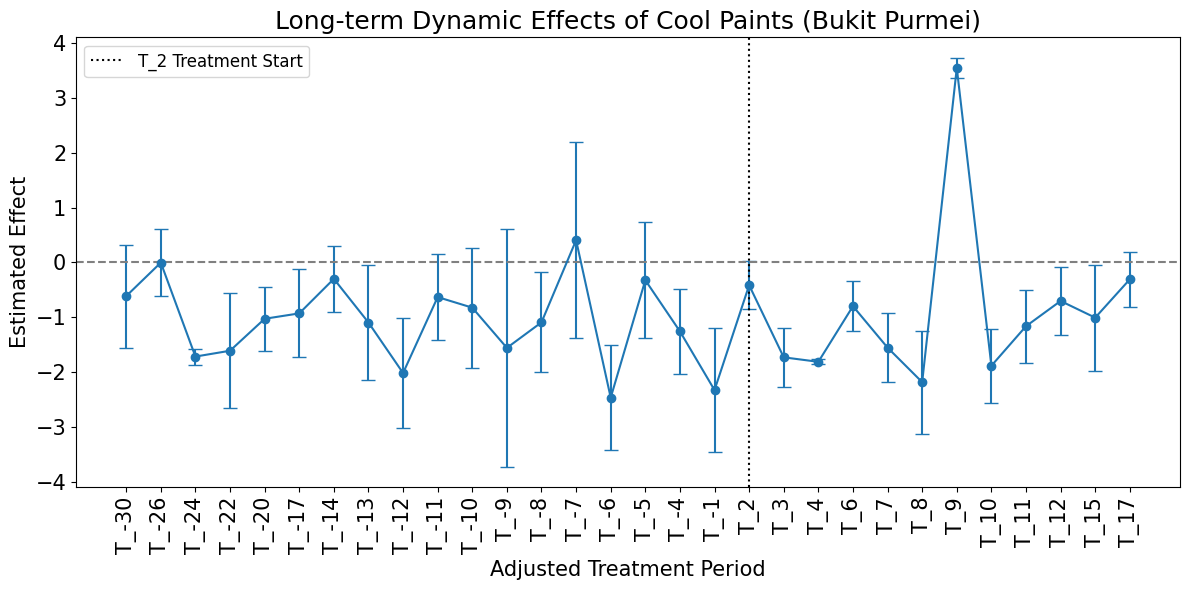

In [1117]:
def adjust_term(term, subtract_value=31):
    # Extracts the numeric part, subtracts the value, and reconstructs the term
    number = int(re.search(r'\d+', term).group())
    adjusted_number = number - subtract_value
    new_term = term.replace(str(number), str(adjusted_number))
    new_term = new_term.replace('_treatment', '')  # Remove the '_treatment' suffix
    return new_term

# Extract coefficients and standard errors
coefficients = results.params
std_errors = results.std_errors
conf_int = results.conf_int()

# Filter results to include only interaction terms
filtered_results = coefficients.loc[interaction_vars]

# Convert standard errors to 95% confidence intervals
conf_int_width = 1.96 * std_errors.loc[interaction_vars]

# Generate a DataFrame for plotting
plot_data = pd.DataFrame({
    'parameter': filtered_results,
    'std_error': std_errors.loc[interaction_vars],
    'lower': conf_int.iloc[:, 0].loc[interaction_vars],
    'upper': conf_int.iloc[:, 1].loc[interaction_vars],
    'Time_Period': [adjust_term(term) for term in interaction_vars]  # Adjust term labels
})

# Plotting
plt.figure(figsize=(12, 6))
plt.errorbar(x=plot_data['Time_Period'], y=plot_data['parameter'], yerr=conf_int_width, fmt='o-', capsize=5)
plt.axhline(0, linestyle='dashed', color='gray')

# Add a vertical line for the specific treatment period
treatment_label = 'T_2'
if treatment_label in plot_data['Time_Period'].values:
    treatment_position = plot_data['Time_Period'].tolist().index(treatment_label)
    plt.axvline(x=treatment_position, color='black', linestyle='dotted', label='T_2 Treatment Start')

plt.xticks(rotation=90)
plt.title('Long-term Dynamic Effects of Cool Paints (Bukit Purmei)', fontsize=18)
plt.xlabel('Adjusted Treatment Period', fontsize=15)
plt.ylabel('Estimated Effect', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Tampines 2020 - 2024

### Filtering Criteria for Clouds

In [55]:
# File paths for Landsat 8 and 9 data
file_paths = {
    'Landsat8': {
        'treatment': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat8\Tampines_Treatment_Filtered_2020_to_2024.csv",
        'control': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat8\Tampines_Control_Filtered_2020_to_2024.csv"
    },
    'Landsat9': {
        'treatment': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat9\Tampines_Treatment_Filtered_2021_to_2024.csv",
        'control': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat9\Tampines_Control_Filtered_2021_to_2024.csv"
    },
    'Landsat7': {
        'treatment': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat7\Tampines_Treatment_Filtered_2020_to_2022.csv",
        'control': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat7\Tampines_Control_Filtered_2020_to_2022.csv"
    }
}

tampines_treatment_frames = []
tampines_control_frames = []

batch_4 = ['polygon_860B', 'polygon_860', 'polygon_860A', 'polygon_859A', 'polygon_859', 'polygon_859B', 'polygon_858B', 'polygon_858', 'polygon_858A', 'polygon_861A', 'polygon_861',
           'polygon_855', 'polygon_853', 'polygon_849', 'polygon_851', 'polygon_847', 'polygon_845', 'polygon_843',
           'polygon_841', 'polygon_840', 'polygon_839', 'polygon_838', 'polygon_835', 'polygon_837', 'polygon_836', 'polygon_832', 'polygon_830', 'polygon_831', 'polygon_833',
           'polygon_876', 'polygon_875', 'polygon_877', 'polygon_878', 'polygon_879', 'polygon_880', 'polygon_880A', 'Lighthouse Evangelism']

exclude = ['Tampines West Community Club', 'Tampines Central Community Club', 'Lighthouse Evangelism', 'Singapore Soka Association Headquarters']

roof_paint = ['polygon_847', 'polygon_848', 'polygon_845', 'polygon_846', 'polygon_839', 'polygon_833', 'polygon_836', 'polygon_832']

# Load data, add 'SATELLITE' and 'CTRL_TREATMENT' columns, and normalize the temperature column name
for satellite, paths in file_paths.items():
    for group, path in paths.items():
        temp_df = pd.read_csv(path)
        temp_df.rename(columns={'block_num': 'block'}, inplace=True)
        temp_df['SATELLITE'] = satellite
        temp_df['CTRL_TREATMENT'] = group
        # Check the satellite and rename the corresponding temperature column to 'LST_Celsius'
        if 'Landsat7' in satellite:
            temp_df.rename(columns={'ST_B6_Celsius': 'LST_Celsius'}, inplace=True)
        else:
            temp_df.rename(columns={'ST_B10_Celsius': 'LST_Celsius'}, inplace=True)
        if group == 'treatment':
            tampines_treatment_frames.append(temp_df)
        else:
            tampines_control_frames.append(temp_df)

# Concatenate all treatment and control data into single DataFrames
tampines_treatment_data = pd.concat(tampines_treatment_frames, ignore_index=True)
tampines_control_data = pd.concat(tampines_control_frames, ignore_index=True)

tampines_treatment_data = tampines_treatment_data[~tampines_treatment_data['block'].isin(batch_4)].copy()
tampines_control_data = tampines_control_data[~tampines_control_data['block'].isin(batch_4)].copy()

# Assuming treatment_data and control_data are already loaded and contain the 'QA_PIXEL' column
tampines_treatment_data['QA_PIXEL'] = tampines_treatment_data['QA_PIXEL'].fillna(-1).astype(int)
tampines_control_data['QA_PIXEL'] = tampines_control_data['QA_PIXEL'].fillna(-1).astype(int)

# # Combine unique values from both datasets
# unique_values_treatment = set(tampines_treatment_data['QA_PIXEL'].unique())
# unique_values_control = set(tampines_control_data['QA_PIXEL'].unique())
# all_unique_values = unique_values_treatment.union(unique_values_control)  # Use set union to avoid duplicates

# def convert_to_binary_16(value):
#     # Convert value to binary, padded to 16 bits
#     if value == -1:
#         return 'NaN'  # Return a string 'NaN' for placeholder
#     binary_string = format(value, '016b')
#     # Split the binary string into 4 groups of 4 digits each
#     return ' '.join([binary_string[i:i+4] for i in range(0, 16, 4)])

# # Convert and print all unique values
# for value in all_unique_values:
#     binary_representation = convert_to_binary_16(value)
#     print(f'Original: {value}, Binary: {binary_representation}')

In [748]:
# Filtering Criteria (1):
# qa_pixel_filter_1 = [5504, 5506, 54534, 54790, 22280, 5896, 55052, 7440, 7696, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 54852, 24144, 23888, 56660, 56916]
# sr_qa_aerosol_filter_1 = [192, 194, 196, 224, 228]

### Plot for Average LST against Time

#### Tampines Treatment & Control 2019 - 2024

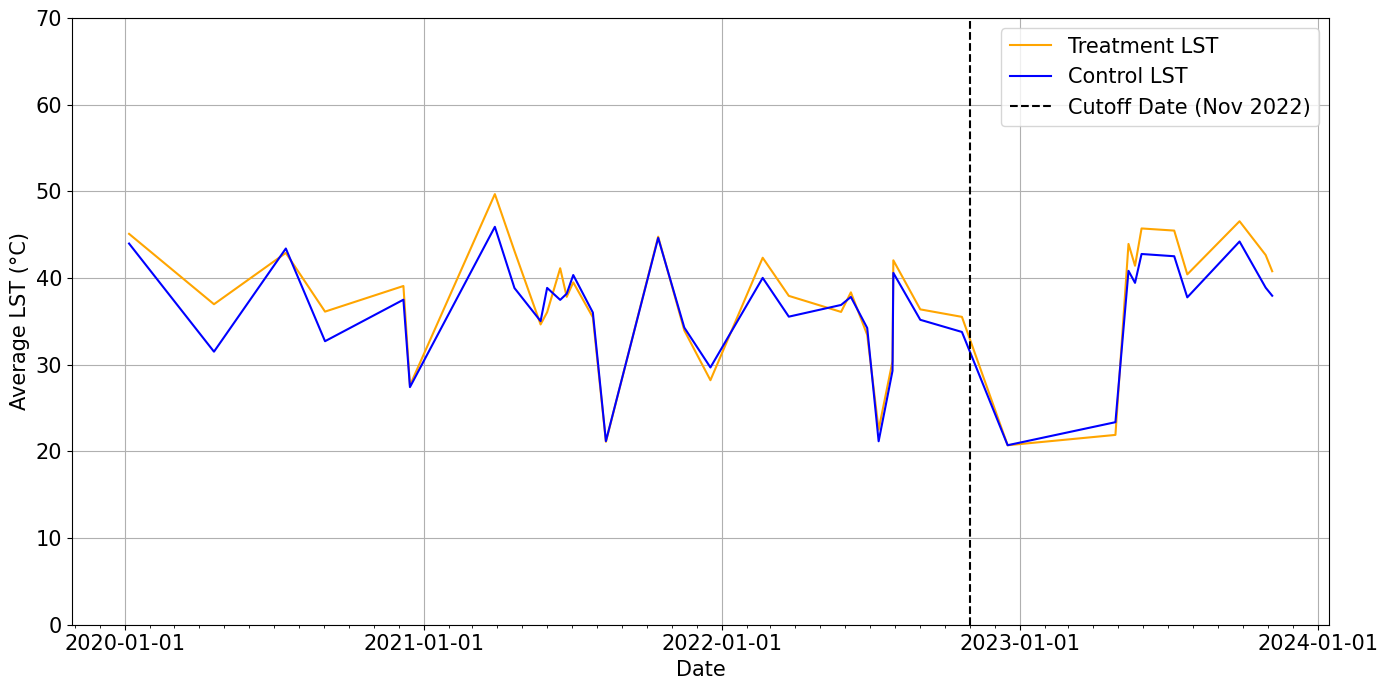

In [257]:
# Convert the 'time' column to datetime format
tampines_treatment_data['time'] = pd.to_datetime(tampines_treatment_data['time'])
tampines_control_data['time'] = pd.to_datetime(tampines_control_data['time'])

# Filter out unwanted QA_PIXEL values
qa_pixel_filter_1 = [5504, 5506, 54534, 54790, 22280, 5896, 55052, 7440, 7696, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 54852, 24144, 23888, 56660, 56916]
tampines_treatment_data = tampines_treatment_data[~tampines_treatment_data['QA_PIXEL'].isin(qa_pixel_filter_1)]
tampines_control_data = tampines_control_data[~tampines_control_data['QA_PIXEL'].isin(qa_pixel_filter_1)]

# Additional filtering for 'SR_QA_AEROSOL'
sr_qa_aerosol_filter_1 = [192, 194, 196, 224, 228]  # Filtering out high aerosol levels
tampines_treatment_data = tampines_treatment_data[~tampines_treatment_data['SR_QA_AEROSOL'].isin(sr_qa_aerosol_filter_1)]
tampines_control_data = tampines_control_data[~tampines_control_data['SR_QA_AEROSOL'].isin(sr_qa_aerosol_filter_1)]

# Group by 'time' and calculate the average
tampines_average_treatment_lst = tampines_treatment_data.groupby(tampines_treatment_data['time'].dt.date)['LST_Celsius'].mean()
tampines_average_control_lst = tampines_control_data.groupby(tampines_control_data['time'].dt.date)['LST_Celsius'].mean()

# Use an outer join to include all dates from both groups
combined_dates = pd.concat([tampines_average_treatment_lst.rename('Treatment'), tampines_average_control_lst.rename('Control')], axis=1, join='inner')
dates = combined_dates.index  # This includes all dates from both datasets

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the data
ax.plot(dates, combined_dates['Treatment'], label='Treatment LST', color='orange')
ax.plot(dates, combined_dates['Control'], label='Control LST', color='blue')

# Formatting Date Axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Mark the treatment date
treatment_date = pd.Timestamp('2022-11-01')
plt.axvline(x=treatment_date, color='black', linestyle='--', label='Cutoff Date (Nov 2022)')

# Set plot attributes with increased font sizes
# ax.set_title('Average LST Over Time (Tampines)', fontsize=20)
ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('Average LST (°C)', fontsize=15)
ax.set_ylim(bottom=0, top=70)
ax.grid(True)
ax.legend(fontsize=15)

# Adjust tick parameters
ax.tick_params(axis='both', labelsize=15)  # Adjust font size for both x and y tick labels

# Rotate date labels for clarity
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
plt.tight_layout()
plt.show()

### Differences-in-Differences Regression

##### Coefficient of `treatment:treatment_date` is 0.0047 and is not statistically significant

In [750]:
# Add 'treatment' column: 1 for treatment data, 0 for control data
tampines_treatment_data['treatment'] = 1
tampines_control_data['treatment'] = 0

tampines_treatment_data['group'] = 'Treatment'
tampines_control_data['group'] = 'Control'

# Combine the treatment and control datasets
tampines_combined_data = pd.concat([tampines_treatment_data, tampines_control_data], ignore_index=True)

# Convert 'time' column to datetime if it's not already
tampines_combined_data['time'] = pd.to_datetime(tampines_combined_data['time'])

# Create 'time' column for post-treatment period, assigning 1 for post-treatment and 0 otherwise
cutoff_date = pd.Timestamp('2022-11-01')
tampines_combined_data['treatment_date'] = (tampines_combined_data['time'].dt.date >= cutoff_date.date()).astype(int)

# Ensure your DataFrame has an appropriate index for panel data analysis
tampines_combined_data = tampines_combined_data.set_index(['block', 'time'], drop=False)

In [751]:
# Define the formula for the regression model
formula = 'LST_Celsius ~ 1 + EntityEffects + TimeEffects + treatment:treatment_date'

# Fit the DiD regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=tampines_combined_data)

# Print the results
results = model.fit(cov_type='clustered', cluster_entity=True)

print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                     6.767e-08
Estimator:                   PanelOLS   R-squared (Between):             -0.0191
No. Observations:                7320   R-squared (Within):            4.026e-06
Date:                Wed, Jul 10 2024   R-squared (Overall):           2.403e-05
Time:                        15:03:05   Log-likelihood                -1.302e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.0005
Entities:                         119   P-value                           0.9825
Avg Obs:                       61.513   Distribution:                  F(1,7135)
Min Obs:                      10.0000                                           
Max Obs:                       228.00   F-statistic (robust):             0.0004
                            

### Prior Trends Test

##### The coefficient of `int_time_group` is 0.6737 and is not statistically significant

In [752]:
df = tampines_combined_data

# Define the cutoff date
cutoff_date = pd.Timestamp('2020-11-01')

# Filter the dataset to include only data before the cutoff date
df_pre = df[df['time'] < cutoff_date].copy()

# Ensure 'block' is a column if not already
df_pre['block'] = df_pre['block'] if 'block' in df_pre.columns else range(len(df_pre))

# Convert 'time' to datetime format if not already
df_pre['time'] = pd.to_datetime(df_pre['time'])

# Set the index to 'block' and 'time' for Panel data format
df_pre = df_pre.set_index(['block', 'time'])

# Create the time variable as the number of periods from the start of the data
df_pre['time_periods'] = pd.factorize(df_pre.index.get_level_values('time').date)[0]

# Create interaction term for Time * Group
df_pre['int_time_group'] = df_pre['time_periods'] * df_pre['treatment']

# Define the formula for PanelOLS
formula = 'LST_Celsius ~ 1 + time_periods + treatment + int_time_group'

# Fit the regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=df_pre, check_rank=False)
fitted_model = model.fit(cov_type='clustered', cluster_entity=True)

# Print the summary of the regression model
print(fitted_model)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.8282
Estimator:                   PanelOLS   R-squared (Between):              0.7649
No. Observations:                 767   R-squared (Within):               0.8585
Date:                Wed, Jul 10 2024   R-squared (Overall):              0.8282
Time:                        15:03:05   Log-likelihood                   -1695.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1226.1
Entities:                         109   P-value                           0.0000
Avg Obs:                       7.0367   Distribution:                   F(3,763)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             237.54
                            

### Long-term Effects

In [753]:
# Sort the DataFrame by 'time' index level
tampines_combined_data.sort_index(level='time', inplace=True)

# Creating 'time_periods' variable, factorising 'time' column
tampines_combined_data['time_periods'] = pd.factorize(tampines_combined_data.index.get_level_values('time').date)[0]

# Finding the first treatment_date == 1
filtered_df = tampines_combined_data[tampines_combined_data['treatment_date'] == 1]

# Find the earliest date in the 'time' column for these rows
earliest_date = filtered_df['time'].min()

# Get the corresponding value in 'time_periods' for the earliest date
corresponding_time_period = filtered_df[filtered_df['time'] == earliest_date]['time_periods'].iloc[0]

# Print the earliest date and the corresponding 'time_periods' value
print("The earliest date for 'treatment_date' == 1 is:", earliest_date)
print("The corresponding value in 'time_periods' is:", corresponding_time_period)

The earliest date for 'treatment_date' == 1 is: 2022-12-17 00:00:00
The corresponding value in 'time_periods' is: 44


In [754]:
# Scale time periods, drop period right before treatment period
tampines_combined_data['time_periods_scaled'] = tampines_combined_data.time_periods - 43

In [755]:
# Filtering valid time periods (where both control and treatment data exist)

# Subset to dates with both control and treated blocks
grouped = tampines_combined_data.groupby(['group', pd.Grouper(freq='D', level='time')]).size().unstack(fill_value=0)
both_groups_present = (grouped.loc['Treatment'] > 0) & (grouped.loc['Control'] > 0)
valid_periods = both_groups_present[both_groups_present].index
#print(valid_periods)

#Subset the data to only include periods with control and treatment group, just in case error is due to this. but it is not, i.e., doing this step or not leads to the same error
tampines_combined_data['date'] = tampines_combined_data['time'].dt.date  # Extract date from datetime for comparison
valid_periods_set = set(valid_periods.date)  # Convert valid periods to a set of dates for efficient filtering

# Filter the DataFrame
tampines_subset_df = tampines_combined_data[tampines_combined_data['date'].isin(valid_periods_set)].copy()

#See the periods that we are left

# Get all values in 'time' column
unique_time_values = tampines_subset_df['time'].unique()
print(unique_time_values)

unique_period_values = tampines_subset_df['time_periods_scaled'].unique()
print(unique_period_values)

['2020-01-06T00:00:00.000000000' '2020-04-19T00:00:00.000000000'
 '2020-05-29T00:00:00.000000000' '2020-07-16T00:00:00.000000000'
 '2020-09-02T00:00:00.000000000' '2020-12-07T00:00:00.000000000'
 '2020-12-15T00:00:00.000000000' '2021-03-29T00:00:00.000000000'
 '2021-04-22T00:00:00.000000000' '2021-05-24T00:00:00.000000000'
 '2021-06-01T00:00:00.000000000' '2021-06-17T00:00:00.000000000'
 '2021-06-25T00:00:00.000000000' '2021-07-03T00:00:00.000000000'
 '2021-07-27T00:00:00.000000000' '2021-08-12T00:00:00.000000000'
 '2021-09-05T00:00:00.000000000' '2021-10-15T00:00:00.000000000'
 '2021-11-16T00:00:00.000000000' '2021-12-18T00:00:00.000000000'
 '2022-02-20T00:00:00.000000000' '2022-03-24T00:00:00.000000000'
 '2022-05-27T00:00:00.000000000' '2022-06-08T00:00:00.000000000'
 '2022-06-28T00:00:00.000000000' '2022-07-12T00:00:00.000000000'
 '2022-07-29T00:00:00.000000000' '2022-07-30T00:00:00.000000000'
 '2022-09-01T00:00:00.000000000' '2022-10-22T00:00:00.000000000'
 '2022-12-17T00:00:00.000

In [756]:
#Set index again to be sure
tampines_subset_df = tampines_subset_df.set_index(['block', 'time_periods_scaled'], drop=False)

In [757]:
# Ensure 'time_periods_scaled' is treated as a categorical variable
tampines_subset_df['time_periods'] = tampines_subset_df['time_periods'].astype('category')

# Create dummy variables for 'time_periods_scaled'
time_dummies = pd.get_dummies(tampines_subset_df['time_periods'], prefix='T')

time_dummies.head()

T_0  T_2  T_4  T_5  T_6  \
block                           time_periods_scaled                            
Tampines Central Community Club -43                    1    0    0    0    0   
Tampines West Community Club    -43                    1    0    0    0    0   
                                -43                    1    0    0    0    0   
polygon_808                     -43                    1    0    0    0    0   
polygon_809                     -43                    1    0    0    0    0   

                                                     T_8  T_9  T_14  T_15  \
block                           time_periods_scaled                         
Tampines Central Community Club -43                    0    0     0     0   
Tampines West Community Club    -43                    0    0     0     0   
                                -43                    0    0     0     0   
polygon_808                     -43                    0    0     0     0   
polygon_809                     -43                    0    0     0     0   

                                                     T_16  ...  T_46  T_48  \
block                           time_periods_scaled        ...               
Tampines Central Community Club -43                     0  ...     0     0   
Tampines West Community Club    -43                     0  ...     0     0   
                                -43                     0  ...     0     0   
polygon_808                     -43                     0  ...     0     0   
polygon_809                     -43                     0  ...     0     0   

                                                     T_49  T_50  T_51  T_53  \
block                           time_periods_scaled                           
Tampines Central Community Club -43                     0     0     0     0   
Tampines West Community Club    -43                     0     0     0     0   
                                -43                     0     0     0     0   
polygon_808                     -43                     0     0     0     0   
polygon_809                     -43                     0     0     0     0   

                                                     T_54  T_55  T_57  T_58  
block                           time_periods_scaled                          
Tampines Central Community Club -43                     0     0     0     0  
Tampines West Community Club    -43                     0     0     0     0  
                                -43                     0     0     0     0  
polygon_808                     -43                     0     0     0     0  
polygon_809                     -43                     0     0     0     0  

[5 rows x 41 columns]

In [758]:
# Drop one period before T_32
time_dummies.drop('T_43', axis=1, inplace=True)

In [759]:
# Add the dummy variables to the DataFrame
tampines_subset_df = pd.concat([tampines_subset_df, time_dummies], axis=1)

In [760]:
# Create a dictionary to hold the time values for each dummy variable
dummy_time_mapping = {}

# Iterate over each dummy variable
for dummy in time_dummies.columns:
    # Extract the 'time' values where the dummy variable is 1
    times = tampines_subset_df.loc[tampines_subset_df[dummy] == 1, 'time'].unique()
    dummy_time_mapping[dummy] = times

# Print the mapping
for dummy, times in dummy_time_mapping.items():
    print(f'{dummy}: {times}')

T_0: ['2020-01-06T00:00:00.000000000']
T_2: ['2020-04-19T00:00:00.000000000']
T_4: ['2020-05-29T00:00:00.000000000']
T_5: ['2020-07-16T00:00:00.000000000']
T_6: ['2020-09-02T00:00:00.000000000']
T_8: ['2020-12-07T00:00:00.000000000']
T_9: ['2020-12-15T00:00:00.000000000']
T_14: ['2021-03-29T00:00:00.000000000']
T_15: ['2021-04-22T00:00:00.000000000']
T_16: ['2021-05-24T00:00:00.000000000']
T_17: ['2021-06-01T00:00:00.000000000']
T_18: ['2021-06-17T00:00:00.000000000']
T_19: ['2021-06-25T00:00:00.000000000']
T_20: ['2021-07-03T00:00:00.000000000']
T_21: ['2021-07-27T00:00:00.000000000']
T_22: ['2021-08-12T00:00:00.000000000']
T_24: ['2021-09-05T00:00:00.000000000']
T_25: ['2021-10-15T00:00:00.000000000']
T_28: ['2021-11-16T00:00:00.000000000']
T_29: ['2021-12-18T00:00:00.000000000']
T_30: ['2022-02-20T00:00:00.000000000']
T_32: ['2022-03-24T00:00:00.000000000']
T_36: ['2022-05-27T00:00:00.000000000']
T_37: ['2022-06-08T00:00:00.000000000']
T_38: ['2022-06-28T00:00:00.000000000']
T_39: [

In [761]:
interaction_vars = []
for col in time_dummies.columns:
    interaction_col = f'{col}_treatment'
    tampines_subset_df[interaction_col] = tampines_subset_df[col] * tampines_subset_df['treatment']
    interaction_vars.append(interaction_col)

In [762]:
# Create the interaction terms string
interaction_terms = ' + '.join(interaction_vars)

# Display the interaction terms string
print(interaction_terms)

# Create the model formula, including the interaction terms and other covariates
formula = f'LST_Celsius ~ 1 + {interaction_terms} + EntityEffects + TimeEffects'

# Print the formula to verify
print(formula)

T_0_treatment + T_2_treatment + T_4_treatment + T_5_treatment + T_6_treatment + T_8_treatment + T_9_treatment + T_14_treatment + T_15_treatment + T_16_treatment + T_17_treatment + T_18_treatment + T_19_treatment + T_20_treatment + T_21_treatment + T_22_treatment + T_24_treatment + T_25_treatment + T_28_treatment + T_29_treatment + T_30_treatment + T_32_treatment + T_36_treatment + T_37_treatment + T_38_treatment + T_39_treatment + T_40_treatment + T_41_treatment + T_42_treatment + T_44_treatment + T_46_treatment + T_48_treatment + T_49_treatment + T_50_treatment + T_51_treatment + T_53_treatment + T_54_treatment + T_55_treatment + T_57_treatment + T_58_treatment
LST_Celsius ~ 1 + T_0_treatment + T_2_treatment + T_4_treatment + T_5_treatment + T_6_treatment + T_8_treatment + T_9_treatment + T_14_treatment + T_15_treatment + T_16_treatment + T_17_treatment + T_18_treatment + T_19_treatment + T_20_treatment + T_21_treatment + T_22_treatment + T_24_treatment + T_25_treatment + T_28_treatme

In [763]:
# Fit the DiD regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=tampines_subset_df, drop_absorbed=True)

# Print the results
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.1473
Estimator:                   PanelOLS   R-squared (Between):              0.0769
No. Observations:                6439   R-squared (Within):               0.0613
Date:                Wed, Jul 10 2024   R-squared (Overall):              0.0631
Time:                        15:03:06   Log-likelihood                -1.088e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      26.948
Entities:                         119   P-value                           0.0000
Avg Obs:                       54.109   Distribution:                 F(40,6240)
Min Obs:                       9.0000                                           
Max Obs:                       206.00   F-statistic (robust):             511.81
                            

## Tampines 2020 - 2024 (Treatment == Batch 1)

### Filtering Criteria for Clouds

In [214]:
# File paths for Landsat 8 and 9 data
file_paths = {
    'Landsat8': {
        'treatment': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat8\Tampines_Treatment_Filtered_2020_to_2024.csv",
        'control': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat8\Tampines_Control_Filtered_2020_to_2024.csv"
    },
    'Landsat9': {
        'treatment': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat9\Tampines_Treatment_Filtered_2021_to_2024.csv",
        'control': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat9\Tampines_Control_Filtered_2021_to_2024.csv"
    },
    'Landsat7': {
        'treatment': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat7\Tampines_Treatment_Filtered_2020_to_2022.csv",
        'control': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat7\Tampines_Control_Filtered_2020_to_2022.csv"
    }
}

tampines_treatment_frames = []
tampines_control_frames = []

batch_1 = [
    'polygon_871A', 'polygon_871', 'polygon_872', 'polygon_873', 'polygon_874', 
    'polygon_874A', 'polygon_870', 'polygon_869', 'polygon_868', 'polygon_867', 
    'polygon_866', 'polygon_865', 'polygon_867A', 'polygon_863B', 'polygon_863', 
    'polygon_863A', 'polygon_864', 'polygon_864A', 'polygon_862A', 'polygon_862', 
    'polygon_857A', 'polygon_857', 'polygon_857B', 'polygon_827B', 'polygon_827A', 
    'polygon_825', 'polygon_824', 'polygon_823A', 'polygon_823', 'polygon_822', 
    'polygon_821', 'polygon_828', 'polygon_829', 'polygon_826', 'polygon_826A', 
    'polygon_828A', 'polygon_823A'
]

batch_4 = ['polygon_860B', 'polygon_860', 'polygon_860A', 'polygon_859A', 'polygon_859', 'polygon_859B', 'polygon_858B', 'polygon_858', 'polygon_858A', 'polygon_861A', 'polygon_861',
           'polygon_855', 'polygon_853', 'polygon_849', 'polygon_851', 'polygon_847', 'polygon_845', 'polygon_843',
           'polygon_841', 'polygon_840', 'polygon_839', 'polygon_838', 'polygon_835', 'polygon_837', 'polygon_836', 'polygon_832', 'polygon_830', 'polygon_831', 'polygon_833',
           'polygon_876', 'polygon_875', 'polygon_877', 'polygon_878', 'polygon_879', 'polygon_880', 'polygon_880A', 'Lighthouse Evangelism']

exclude = ['Tampines West Community Club', 'Tampines Central Community Club', 'Lighthouse Evangelism', 'Singapore Soka Association Headquarters']

roof_paint = ['polygon_847', 'polygon_848', 'polygon_845', 'polygon_846', 'polygon_839', 'polygon_833', 'polygon_836', 'polygon_832']

# Load data, add 'SATELLITE' and 'CTRL_TREATMENT' columns, and normalize the temperature column name
for satellite, paths in file_paths.items():
    for group, path in paths.items():
        temp_df = pd.read_csv(path)
        temp_df.rename(columns={'block_num': 'block'}, inplace=True)
        temp_df['SATELLITE'] = satellite
        temp_df['CTRL_TREATMENT'] = group
        # Check the satellite and rename the corresponding temperature column to 'LST_Celsius'
        if 'Landsat7' in satellite:
            temp_df.rename(columns={'ST_B6_Celsius': 'LST_Celsius'}, inplace=True)
        else:
            temp_df.rename(columns={'ST_B10_Celsius': 'LST_Celsius'}, inplace=True)
        if group == 'treatment':
            tampines_treatment_frames.append(temp_df)
        else:
            tampines_control_frames.append(temp_df)

# Concatenate all treatment and control data into single DataFrames
tampines_treatment_data = pd.concat(tampines_treatment_frames, ignore_index=True)
tampines_control_data = pd.concat(tampines_control_frames, ignore_index=True)

tampines_treatment_data = tampines_treatment_data[tampines_treatment_data['block'].isin(batch_1)].copy()
tampines_control_data = tampines_control_data[~tampines_control_data['block'].isin(batch_4)].copy()

# Assuming treatment_data and control_data are already loaded and contain the 'QA_PIXEL' column
tampines_treatment_data['QA_PIXEL'] = tampines_treatment_data['QA_PIXEL'].fillna(-1).astype(int)
tampines_control_data['QA_PIXEL'] = tampines_control_data['QA_PIXEL'].fillna(-1).astype(int)

# # Combine unique values from both datasets
# unique_values_treatment = set(tampines_treatment_data['QA_PIXEL'].unique())
# unique_values_control = set(tampines_control_data['QA_PIXEL'].unique())
# all_unique_values = unique_values_treatment.union(unique_values_control)  # Use set union to avoid duplicates

# def convert_to_binary_16(value):
#     # Convert value to binary, padded to 16 bits
#     if value == -1:
#         return 'NaN'  # Return a string 'NaN' for placeholder
#     binary_string = format(value, '016b')
#     # Split the binary string into 4 groups of 4 digits each
#     return ' '.join([binary_string[i:i+4] for i in range(0, 16, 4)])

# # Convert and print all unique values
# for value in all_unique_values:
#     binary_representation = convert_to_binary_16(value)
#     print(f'Original: {value}, Binary: {binary_representation}')

In [765]:
# Filtering Criteria (1):
# qa_pixel_filter_1 = [5504, 5506, 54534, 54790, 22280, 5896, 55052, 7440, 7696, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 54852, 24144, 23888, 56660, 56916]
# sr_qa_aerosol_filter_1 = [192, 194, 196, 224, 228]

### Plot for Average LST against Time

#### Tampines Treatment & Control 2019 - 2024

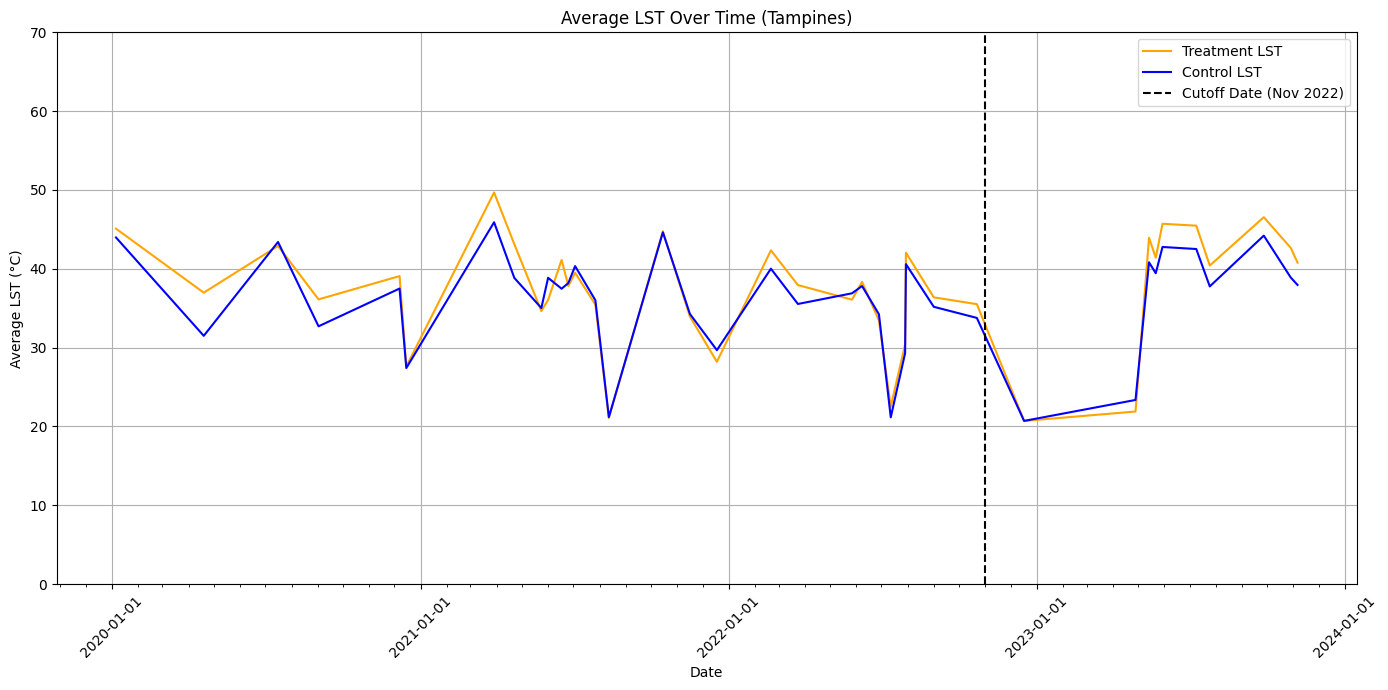

In [215]:
# Convert the 'time' column to datetime format
tampines_treatment_data['time'] = pd.to_datetime(tampines_treatment_data['time'])
tampines_control_data['time'] = pd.to_datetime(tampines_control_data['time'])

# Filter out unwanted QA_PIXEL values
qa_pixel_filter_1 = [5504, 5506, 54534, 54790, 22280, 5896, 55052, 7440, 7696, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 54852, 24144, 23888, 56660, 56916]
tampines_treatment_data = tampines_treatment_data[~tampines_treatment_data['QA_PIXEL'].isin(qa_pixel_filter_1)]
tampines_control_data = tampines_control_data[~tampines_control_data['QA_PIXEL'].isin(qa_pixel_filter_1)]

# Additional filtering for 'SR_QA_AEROSOL'
sr_qa_aerosol_filter_1 = [192, 194, 196, 224, 228]  # Filtering out high aerosol levels
tampines_treatment_data = tampines_treatment_data[~tampines_treatment_data['SR_QA_AEROSOL'].isin(sr_qa_aerosol_filter_1)]
tampines_control_data = tampines_control_data[~tampines_control_data['SR_QA_AEROSOL'].isin(sr_qa_aerosol_filter_1)]

# Group by 'time' and calculate the average
tampines_average_treatment_lst = tampines_treatment_data.groupby(tampines_treatment_data['time'].dt.date)['LST_Celsius'].mean()
tampines_average_control_lst = tampines_control_data.groupby(tampines_control_data['time'].dt.date)['LST_Celsius'].mean()

# Use an outer join to include all dates from both groups
combined_dates = pd.concat([tampines_average_treatment_lst.rename('Treatment'), tampines_average_control_lst.rename('Control')], axis=1, join='inner')
dates = combined_dates.index  # This includes all dates from both datasets

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the data
ax.plot(dates, combined_dates['Treatment'], label='Treatment LST', color='orange')
ax.plot(dates, combined_dates['Control'], label='Control LST', color='blue')

# Formatting Date Axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Mark the treatment date
treatment_date = pd.Timestamp('2022-11-01')
plt.axvline(x=treatment_date, color='black', linestyle='--', label='Cutoff Date (Nov 2022)')

# Set plot attributes
ax.set_title('Average LST Over Time (Tampines)')
ax.set_xlabel('Date')
ax.set_ylabel('Average LST (°C)')
ax.set_ylim(bottom=0, top=70)
ax.grid(True)
ax.legend()

# Rotate date labels for clarity
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()

In [115]:
# Assuming tampines_treatment_data and tampines_control_data are already defined and preprocessed

# Combine the treatment and control data for easier manipulation
tampines_treatment_data['CTRL_TREATMENT'] = 'treatment'
tampines_control_data['CTRL_TREATMENT'] = 'control'
combined_data = pd.concat([tampines_treatment_data, tampines_control_data])

# Convert 'time' column to datetime if not already
combined_data['time'] = pd.to_datetime(combined_data['time'])

# Group by 'CTRL_TREATMENT' and 'time', then count the number of pixels for each
pixel_count = combined_data.groupby(['CTRL_TREATMENT', combined_data['time'].dt.date]).size().unstack(0)

# Drop rows where any data is missing in either 'treatment' or 'control'
pixel_count.dropna(how='any', inplace=True)

# Print out the number of pixels for both treatment and control on dates where both groups are present
print("Number of pixels (rows) for each group by date where both groups are present:")
print(pixel_count)

Number of pixels (rows) for each group by date where both groups are present:
CTRL_TREATMENT  control  treatment
time                              
2020-01-06          3.0       12.0
2020-04-19         68.0       54.0
2020-07-16         28.0       41.0
2020-09-02          3.0       12.0
2020-12-07         10.0        1.0
2020-12-15        165.0      168.0
2021-03-29          1.0       18.0
2021-04-22        106.0      111.0
2021-05-24         11.0       34.0
2021-06-01         21.0       17.0
2021-06-17          1.0       19.0
2021-06-25        139.0      143.0
2021-07-03         13.0        9.0
2021-07-27         98.0       77.0
2021-08-12          3.0        9.0
2021-10-15        152.0      131.0
2021-11-16        139.0       83.0
2021-12-18          9.0       49.0
2022-02-20          1.0        3.0
2022-03-24         79.0      148.0
2022-05-27         84.0      118.0
2022-06-08        165.0      136.0
2022-06-28          5.0       11.0
2022-07-12         76.0      128.0
2022-07-29  

In [116]:
# Assuming pixel_count and all_metadata are already defined and loaded

# Ensure that 'DATE_ACQUIRED' is in datetime format in the all_metadata DataFrame
all_metadata['DATE_ACQUIRED'] = pd.to_datetime(all_metadata['DATE_ACQUIRED'])

# Extract the unique dates from the pixel_count DataFrame, ensuring they are in datetime format
# Assuming pixel_count index is already in datetime format, if not, convert it
unique_dates = pixel_count.index.unique()

# Filter the all_metadata DataFrame to include only entries from the unique_dates
filtered_metadata = all_metadata[all_metadata['DATE_ACQUIRED'].isin(unique_dates)]

# Calculate the maximum CLOUD_COVER for each date
max_cloud_cover = filtered_metadata.groupby('DATE_ACQUIRED')['CLOUD_COVER'].max()

# Print or return the results
print(max_cloud_cover)

DATE_ACQUIRED
2020-01-06    36.24
2020-04-19    21.00
2020-07-16    10.68
2020-09-02    46.58
2020-12-07    55.15
2020-12-15    37.00
2021-03-29    76.33
2021-04-22    55.00
2021-05-24    11.00
2021-06-01    37.64
2021-06-17    14.10
2021-06-25    15.00
2021-07-03    20.88
2021-07-27    12.00
2021-08-12    40.00
2021-10-15    30.00
2021-11-16     5.00
2021-12-18    77.00
2022-02-20    42.07
2022-03-24    33.00
2022-05-27    51.39
2022-06-08     8.00
2022-06-28    23.33
2022-07-12    75.00
2022-07-29    46.00
2022-07-30    35.36
2022-09-01     6.00
2022-10-22    48.00
2022-12-17    42.00
2023-04-28    56.93
2023-05-14    11.73
2023-05-22     6.59
2023-05-30    12.30
2023-07-09    46.20
2023-07-25    12.74
2023-09-27    16.42
2023-10-29    22.04
2023-11-06    21.27
Name: CLOUD_COVER, dtype: float64


### Differences-in-Differences Regression

##### Coefficient of `treatment:treatment_date` is 0.0047 and is not statistically significant

Block-level Analysis

In [216]:
# Add 'treatment' column: 1 for treatment data, 0 for control data
tampines_treatment_data['treatment'] = 1
tampines_control_data['treatment'] = 0

tampines_treatment_data['group'] = 'Treatment'
tampines_control_data['group'] = 'Control'

# Combine the treatment and control datasets
tampines_combined_data = pd.concat([tampines_treatment_data, tampines_control_data], ignore_index=True)

# Convert 'time' column to datetime if it's not already
tampines_combined_data['time'] = pd.to_datetime(tampines_combined_data['time'])

# Create 'time' column for post-treatment period, assigning 1 for post-treatment and 0 otherwise
cutoff_date = pd.Timestamp('2022-11-01')
tampines_combined_data['treatment_date'] = (tampines_combined_data['time'].dt.date >= cutoff_date.date()).astype(int)

# Ensure your DataFrame has an appropriate index for panel data analysis
tampines_combined_data = tampines_combined_data.set_index(['block', 'time'], drop=False)

In [217]:
# Define the formula for the regression model
formula = 'LST_Celsius ~ 1 + EntityEffects + TimeEffects + treatment:treatment_date'

# Fit the DiD regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=tampines_combined_data)

# Print the results
results = model.fit(cov_type='clustered', cluster_entity=True)

print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):             -0.0411
No. Observations:                4007   R-squared (Within):              -0.0004
Date:                Fri, Jul 19 2024   R-squared (Overall):             -0.0015
Time:                        11:31:12   Log-likelihood                   -7090.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.5265
Entities:                          63   P-value                           0.4681
Avg Obs:                       63.603   Distribution:                  F(1,3882)
Min Obs:                       26.000                                           
Max Obs:                       228.00   F-statistic (robust):             0.3565
                            

Pixel-level Analysis

In [228]:
# Add 'treatment' column: 1 for treatment data, 0 for control data
tampines_treatment_data['treatment'] = 1
tampines_control_data['treatment'] = 0

tampines_treatment_data['group'] = 'Treatment'
tampines_control_data['group'] = 'Control'

# Combine the treatment and control datasets
tampines_combined_data = pd.concat([tampines_treatment_data, tampines_control_data], ignore_index=True)

# Assume 'block' and coordinates 'x' and 'y' uniquely identify each pixel
tampines_combined_data['pixel_id'] = tampines_combined_data['block'].astype(str) + '_' + tampines_combined_data['Longitude'].astype(str) + '_' + tampines_combined_data['Latitude'].astype(str)

# Convert 'time' column to datetime if it's not already
tampines_combined_data['time'] = pd.to_datetime(tampines_combined_data['time'])

# Create 'time' column for post-treatment period, assigning 1 for post-treatment and 0 otherwise
cutoff_date = pd.Timestamp('2022-11-01')
tampines_combined_data['treatment_date'] = (tampines_combined_data['time'].dt.date >= cutoff_date.date()).astype(int)

# Ensure your DataFrame has an appropriate index for panel data analysis
tampines_combined_data = tampines_combined_data.set_index(['pixel_id', 'time'], drop=False)

In [229]:
# Define the formula for the regression model
formula = 'LST_Celsius ~ 1 + EntityEffects + TimeEffects + treatment:treatment_date'

# Fit the DiD regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=tampines_combined_data)

# Print the results
results = model.fit(cov_type='clustered', clusters=tampines_combined_data['block'])

print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.0006
Estimator:                   PanelOLS   R-squared (Between):             -0.0494
No. Observations:                4007   R-squared (Within):              -0.0008
Date:                Fri, Jul 19 2024   R-squared (Overall):             -0.0031
Time:                        12:05:07   Log-likelihood                   -6852.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.2291
Entities:                         337   P-value                           0.1355
Avg Obs:                       11.890   Distribution:                  F(1,3608)
Min Obs:                       6.0000                                           
Max Obs:                       30.000   F-statistic (robust):             1.1760
                            

### Prior Trends Test

##### The coefficient of `int_time_group` is 0.6737 and is not statistically significant

In [68]:
df = tampines_combined_data

# Define the cutoff date
cutoff_date = pd.Timestamp('2020-11-01')

# Filter the dataset to include only data before the cutoff date
df_pre = df[df['time'] < cutoff_date].copy()

# Ensure 'block' is a column if not already
df_pre['block'] = df_pre['block'] if 'block' in df_pre.columns else range(len(df_pre))

# Convert 'time' to datetime format if not already
df_pre['time'] = pd.to_datetime(df_pre['time'])

# Set the index to 'block' and 'time' for Panel data format
df_pre = df_pre.set_index(['block', 'time'])

# Create the time variable as the number of periods from the start of the data
df_pre['time_periods'] = pd.factorize(df_pre.index.get_level_values('time').date)[0]

# Create interaction term for Time * Group
df_pre['int_time_group'] = df_pre['time_periods'] * df_pre['treatment']

# Define the formula for PanelOLS
formula = 'LST_Celsius ~ 1 + time_periods + treatment + int_time_group'

# Fit the regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=df_pre, check_rank=False)
fitted_model = model.fit(cov_type='clustered', cluster_entity=True)

# Print the summary of the regression model
print(fitted_model)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.8282
Estimator:                   PanelOLS   R-squared (Between):              0.7649
No. Observations:                 767   R-squared (Within):               0.8585
Date:                Wed, Jul 17 2024   R-squared (Overall):              0.8282
Time:                        22:31:54   Log-likelihood                   -1695.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1226.1
Entities:                         109   P-value                           0.0000
Avg Obs:                       7.0367   Distribution:                   F(3,763)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             237.54
                            

In [209]:
# Assuming tampines_combined_data is already defined and has appropriate columns
df = tampines_combined_data.copy()

# Define the cutoff date for treatment
cutoff_date = pd.Timestamp('2020-11-01')

# Convert 'time' to datetime format if not already
df['time'] = pd.to_datetime(df['time'])

# Filter the dataset to include only data before the cutoff date for pre-treatment analysis
df_pre = df[df['time'] < cutoff_date]

# Filter the dataset to include only data on or after the cutoff date for post-treatment analysis
df_post = df[df['time'] >= cutoff_date]

# Set the index to 'block' and 'time' for Panel data format
df_pre = df_pre.set_index(['block', 'time'])
df_post = df_post.set_index(['block', 'time'])

# Create the time variable as the number of periods from the start of the data
df_pre['time_periods'] = pd.factorize(df_pre.index.get_level_values('time').date)[0]

# Create interaction term for Time * Group in both datasets
df_pre['int_time_group'] = df_pre['time_periods'] * df_pre['treatment']

# Define the formula for PanelOLS
formula = 'LST_Celsius ~ 1 + time_periods + treatment + int_time_group'

# Fit the regression model using PanelOLS from linearmodels for pre-treatment data
model_pre = PanelOLS.from_formula(formula, data=df_pre)
fitted_model_pre = model_pre.fit(cov_type='clustered', cluster_entity=True)

# Calculate total observations: Count of rows (block-time combinations) in both pre and post periods
total_observations_pre = len(df_pre)
total_observations_post = len(df_post)

# Print the summary of the regression model
# print(f"Pre-Treatment Model Summary:\n{fitted_model_pre.summary}")
print(f"Total observations in pre-treatment period: {total_observations_pre}")
print(f"Total observations in post-treatment period: {total_observations_post}")

Total observations in pre-treatment period: 319
Total observations in post-treatment period: 3688


### Long-term Effects

In [1123]:
# Sort the DataFrame by 'time' index level
tampines_combined_data.sort_index(level='time', inplace=True)

# Creating 'time_periods' variable, factorising 'time' column
tampines_combined_data['time_periods'] = pd.factorize(tampines_combined_data.index.get_level_values('time').date)[0]

# Finding the first treatment_date == 1
filtered_df = tampines_combined_data[tampines_combined_data['treatment_date'] == 1]

# Find the earliest date in the 'time' column for these rows
earliest_date = filtered_df['time'].min()

# Get the corresponding value in 'time_periods' for the earliest date
corresponding_time_period = filtered_df[filtered_df['time'] == earliest_date]['time_periods'].iloc[0]

# Print the earliest date and the corresponding 'time_periods' value
print("The earliest date for 'treatment_date' == 1 is:", earliest_date)
print("The corresponding value in 'time_periods' is:", corresponding_time_period)

The earliest date for 'treatment_date' == 1 is: 2022-12-17 00:00:00
The corresponding value in 'time_periods' is: 40


In [1124]:
# Scale time periods, drop period right before treatment period
tampines_combined_data['time_periods_scaled'] = tampines_combined_data.time_periods - 39

In [1125]:
# Filtering valid time periods (where both control and treatment data exist)

# Subset to dates with both control and treated blocks
grouped = tampines_combined_data.groupby(['group', pd.Grouper(freq='D', level='time')]).size().unstack(fill_value=0)
both_groups_present = (grouped.loc['Treatment'] > 0) & (grouped.loc['Control'] > 0)
valid_periods = both_groups_present[both_groups_present].index
#print(valid_periods)

#Subset the data to only include periods with control and treatment group, just in case error is due to this. but it is not, i.e., doing this step or not leads to the same error
tampines_combined_data['date'] = tampines_combined_data['time'].dt.date  # Extract date from datetime for comparison
valid_periods_set = set(valid_periods.date)  # Convert valid periods to a set of dates for efficient filtering

# Filter the DataFrame
tampines_subset_df = tampines_combined_data[tampines_combined_data['date'].isin(valid_periods_set)].copy()

#See the periods that we are left

# Get all values in 'time' column
unique_time_values = tampines_subset_df['time'].unique()
print(unique_time_values)

unique_period_values = tampines_subset_df['time_periods_scaled'].unique()
print(unique_period_values)

['2020-01-06T00:00:00.000000000' '2020-04-19T00:00:00.000000000'
 '2020-07-16T00:00:00.000000000' '2020-09-02T00:00:00.000000000'
 '2020-12-07T00:00:00.000000000' '2020-12-15T00:00:00.000000000'
 '2021-03-29T00:00:00.000000000' '2021-04-22T00:00:00.000000000'
 '2021-05-24T00:00:00.000000000' '2021-06-01T00:00:00.000000000'
 '2021-06-17T00:00:00.000000000' '2021-06-25T00:00:00.000000000'
 '2021-07-03T00:00:00.000000000' '2021-07-27T00:00:00.000000000'
 '2021-08-12T00:00:00.000000000' '2021-10-15T00:00:00.000000000'
 '2021-11-16T00:00:00.000000000' '2021-12-18T00:00:00.000000000'
 '2022-02-20T00:00:00.000000000' '2022-03-24T00:00:00.000000000'
 '2022-05-27T00:00:00.000000000' '2022-06-08T00:00:00.000000000'
 '2022-06-28T00:00:00.000000000' '2022-07-12T00:00:00.000000000'
 '2022-07-29T00:00:00.000000000' '2022-07-30T00:00:00.000000000'
 '2022-09-01T00:00:00.000000000' '2022-10-22T00:00:00.000000000'
 '2022-12-17T00:00:00.000000000' '2023-04-28T00:00:00.000000000'
 '2023-05-14T00:00:00.000

In [1126]:
#Set index again to be sure
tampines_subset_df = tampines_subset_df.set_index(['block', 'time_periods_scaled'], drop=False)

In [1127]:
# Ensure 'time_periods_scaled' is treated as a categorical variable
tampines_subset_df['time_periods'] = tampines_subset_df['time_periods'].astype('category')

# Create dummy variables for 'time_periods_scaled'
time_dummies = pd.get_dummies(tampines_subset_df['time_periods'], prefix='T')

time_dummies.head()

T_0  T_2  T_5  T_6  T_8  T_9  T_11  T_12  \
block       time_periods_scaled                                             
polygon_808 -39                    1    0    0    0    0    0     0     0   
polygon_809 -39                    1    0    0    0    0    0     0     0   
polygon_823 -39                    1    0    0    0    0    0     0     0   
polygon_828 -39                    1    0    0    0    0    0     0     0   
            -39                    1    0    0    0    0    0     0     0   

                                 T_13  T_14  ...  T_40  T_44  T_45  T_46  \
block       time_periods_scaled              ...                           
polygon_808 -39                     0     0  ...     0     0     0     0   
polygon_809 -39                     0     0  ...     0     0     0     0   
polygon_823 -39                     0     0  ...     0     0     0     0   
polygon_828 -39                     0     0  ...     0     0     0     0   
            -39                     0     0  ...     0     0     0     0   

                                 T_47  T_49  T_50  T_51  T_53  T_54  
block       time_periods_scaled                                      
polygon_808 -39                     0     0     0     0     0     0  
polygon_809 -39                     0     0     0     0     0     0  
polygon_823 -39                     0     0     0     0     0     0  
polygon_828 -39                     0     0     0     0     0     0  
            -39                     0     0     0     0     0     0  

[5 rows x 38 columns]

In [1128]:
# Drop one period before T_32
time_dummies.drop('T_39', axis=1, inplace=True)

In [1129]:
# Add the dummy variables to the DataFrame
tampines_subset_df = pd.concat([tampines_subset_df, time_dummies], axis=1)

In [1130]:
# Create a dictionary to hold the time values for each dummy variable
dummy_time_mapping = {}

# Iterate over each dummy variable
for dummy in time_dummies.columns:
    # Extract the 'time' values where the dummy variable is 1
    times = tampines_subset_df.loc[tampines_subset_df[dummy] == 1, 'time'].unique()
    dummy_time_mapping[dummy] = times

# Print the mapping
for dummy, times in dummy_time_mapping.items():
    print(f'{dummy}: {times}')

T_0: ['2020-01-06T00:00:00.000000000']
T_2: ['2020-04-19T00:00:00.000000000']
T_5: ['2020-07-16T00:00:00.000000000']
T_6: ['2020-09-02T00:00:00.000000000']
T_8: ['2020-12-07T00:00:00.000000000']
T_9: ['2020-12-15T00:00:00.000000000']
T_11: ['2021-03-29T00:00:00.000000000']
T_12: ['2021-04-22T00:00:00.000000000']
T_13: ['2021-05-24T00:00:00.000000000']
T_14: ['2021-06-01T00:00:00.000000000']
T_15: ['2021-06-17T00:00:00.000000000']
T_16: ['2021-06-25T00:00:00.000000000']
T_17: ['2021-07-03T00:00:00.000000000']
T_18: ['2021-07-27T00:00:00.000000000']
T_19: ['2021-08-12T00:00:00.000000000']
T_22: ['2021-10-15T00:00:00.000000000']
T_25: ['2021-11-16T00:00:00.000000000']
T_26: ['2021-12-18T00:00:00.000000000']
T_27: ['2022-02-20T00:00:00.000000000']
T_29: ['2022-03-24T00:00:00.000000000']
T_32: ['2022-05-27T00:00:00.000000000']
T_33: ['2022-06-08T00:00:00.000000000']
T_34: ['2022-06-28T00:00:00.000000000']
T_35: ['2022-07-12T00:00:00.000000000']
T_36: ['2022-07-29T00:00:00.000000000']
T_37: 

In [1131]:
interaction_vars = []
for col in time_dummies.columns:
    interaction_col = f'{col}_treatment'
    tampines_subset_df[interaction_col] = tampines_subset_df[col] * tampines_subset_df['treatment']
    interaction_vars.append(interaction_col)

In [1132]:
# Create the interaction terms string
interaction_terms = ' + '.join(interaction_vars)

# Display the interaction terms string
print(interaction_terms)

# Create the model formula, including the interaction terms and other covariates
formula = f'LST_Celsius ~ 1 + {interaction_terms} + EntityEffects + TimeEffects'

# Print the formula to verify
print(formula)

T_0_treatment + T_2_treatment + T_5_treatment + T_6_treatment + T_8_treatment + T_9_treatment + T_11_treatment + T_12_treatment + T_13_treatment + T_14_treatment + T_15_treatment + T_16_treatment + T_17_treatment + T_18_treatment + T_19_treatment + T_22_treatment + T_25_treatment + T_26_treatment + T_27_treatment + T_29_treatment + T_32_treatment + T_33_treatment + T_34_treatment + T_35_treatment + T_36_treatment + T_37_treatment + T_38_treatment + T_40_treatment + T_44_treatment + T_45_treatment + T_46_treatment + T_47_treatment + T_49_treatment + T_50_treatment + T_51_treatment + T_53_treatment + T_54_treatment
LST_Celsius ~ 1 + T_0_treatment + T_2_treatment + T_5_treatment + T_6_treatment + T_8_treatment + T_9_treatment + T_11_treatment + T_12_treatment + T_13_treatment + T_14_treatment + T_15_treatment + T_16_treatment + T_17_treatment + T_18_treatment + T_19_treatment + T_22_treatment + T_25_treatment + T_26_treatment + T_27_treatment + T_29_treatment + T_32_treatment + T_33_treat

In [1133]:
# Fit the DiD regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=tampines_subset_df, drop_absorbed=True)

# Print the results
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.2318
Estimator:                   PanelOLS   R-squared (Between):             -0.0585
No. Observations:                3607   R-squared (Within):               0.0432
Date:                Thu, Jul 11 2024   R-squared (Overall):              0.0433
Time:                        16:49:46   Log-likelihood                   -5959.2
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      28.295
Entities:                          63   P-value                           0.0000
Avg Obs:                       57.254   Distribution:                 F(37,3470)
Min Obs:                       20.000                                           
Max Obs:                       206.00   F-statistic (robust):             876.85
                            

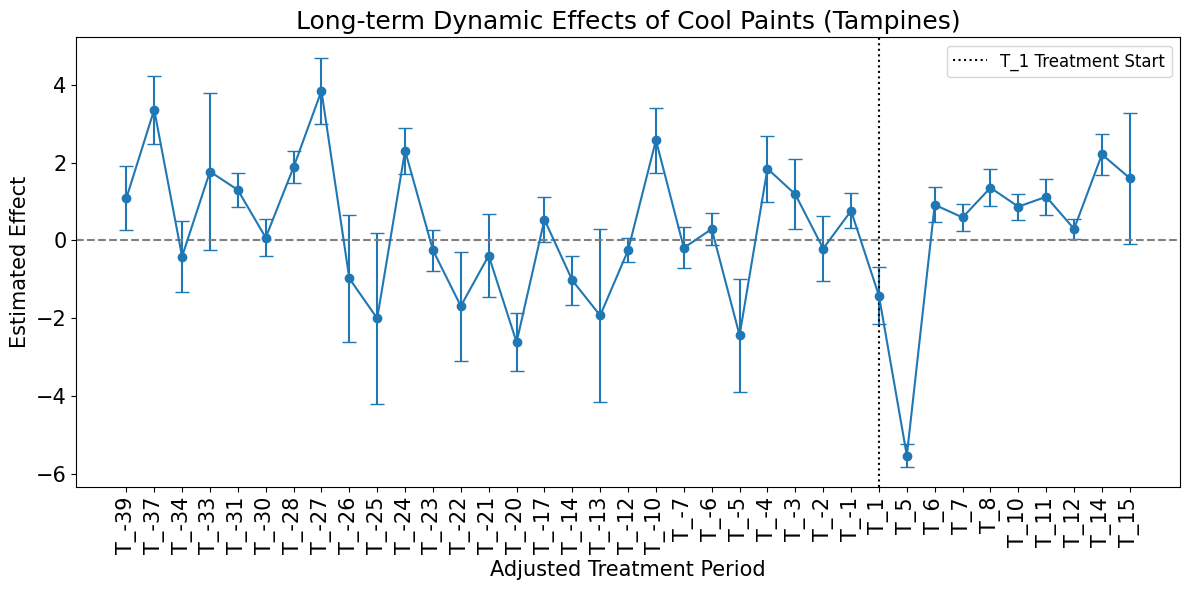

In [1135]:
def adjust_term(term, subtract_value=39):
    # Extracts the numeric part, subtracts the value, and reconstructs the term
    number = int(re.search(r'\d+', term).group())
    adjusted_number = number - subtract_value
    new_term = term.replace(str(number), str(adjusted_number))
    new_term = new_term.replace('_treatment', '')  # Remove the '_treatment' suffix
    return new_term

# Extract coefficients and standard errors
coefficients = results.params
std_errors = results.std_errors
conf_int = results.conf_int()

# Filter results to include only interaction terms
filtered_results = coefficients.loc[interaction_vars]

# Convert standard errors to 95% confidence intervals
conf_int_width = 1.96 * std_errors.loc[interaction_vars]

# Generate a DataFrame for plotting
plot_data = pd.DataFrame({
    'parameter': filtered_results,
    'std_error': std_errors.loc[interaction_vars],
    'lower': conf_int.iloc[:, 0].loc[interaction_vars],
    'upper': conf_int.iloc[:, 1].loc[interaction_vars],
    'Time_Period': [adjust_term(term) for term in interaction_vars]  # Adjust term labels
})

# Plotting
plt.figure(figsize=(12, 6))
plt.errorbar(x=plot_data['Time_Period'], y=plot_data['parameter'], yerr=conf_int_width, fmt='o-', capsize=5)
plt.axhline(0, linestyle='dashed', color='gray')

# Add a vertical line for the specific treatment period
treatment_label = 'T_1'
if treatment_label in plot_data['Time_Period'].values:
    treatment_position = plot_data['Time_Period'].tolist().index(treatment_label)
    plt.axvline(x=treatment_position, color='black', linestyle='dotted', label='T_1 Treatment Start')

plt.xticks(rotation=90)
plt.title('Long-term Dynamic Effects of Cool Paints (Tampines)', fontsize=18)
plt.xlabel('Adjusted Treatment Period', fontsize=15)
plt.ylabel('Estimated Effect', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Tampines 2020 - 2024 (Treatment == Building Surfaces)

### Filtering Criteria for Clouds

In [782]:
# File paths for Landsat 8 and 9 data
file_paths = {
    'Landsat8': {
        'treatment': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat8\Tampines_Treatment_Filtered_2020_to_2024.csv",
        'control': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat8\Tampines_Control_Filtered_2020_to_2024.csv"
    },
    'Landsat9': {
        'treatment': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat9\Tampines_Treatment_Filtered_2021_to_2024.csv",
        'control': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat9\Tampines_Control_Filtered_2021_to_2024.csv"
    },
    'Landsat7': {
        'treatment': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat7\Tampines_Treatment_Filtered_2020_to_2022.csv",
        'control': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat7\Tampines_Control_Filtered_2020_to_2022.csv"
    }
}

tampines_treatment_frames = []
tampines_control_frames = []

batch_4 = ['polygon_860B', 'polygon_860', 'polygon_860A', 'polygon_859A', 'polygon_859', 'polygon_859B', 'polygon_858B', 'polygon_858', 'polygon_858A', 'polygon_861A', 'polygon_861',
           'polygon_855', 'polygon_853', 'polygon_849', 'polygon_851', 'polygon_847', 'polygon_845', 'polygon_843',
           'polygon_841', 'polygon_840', 'polygon_839', 'polygon_838', 'polygon_835', 'polygon_837', 'polygon_836', 'polygon_832', 'polygon_830', 'polygon_831', 'polygon_833',
           'polygon_876', 'polygon_875', 'polygon_877', 'polygon_878', 'polygon_879', 'polygon_880', 'polygon_880A', 'Lighthouse Evangelism']

exclude = ['Tampines West Community Club', 'Tampines Central Community Club', 'Lighthouse Evangelism', 'Singapore Soka Association Headquarters']

roof_paint = ['polygon_848', 'polygon_846']

# Load data, add 'SATELLITE' and 'CTRL_TREATMENT' columns, and normalize the temperature column name
for satellite, paths in file_paths.items():
    for group, path in paths.items():
        temp_df = pd.read_csv(path)
        temp_df.rename(columns={'block_num': 'block'}, inplace=True)
        temp_df['SATELLITE'] = satellite
        temp_df['CTRL_TREATMENT'] = group
        # Check the satellite and rename the corresponding temperature column to 'LST_Celsius'
        if 'Landsat7' in satellite:
            temp_df.rename(columns={'ST_B6_Celsius': 'LST_Celsius'}, inplace=True)
        else:
            temp_df.rename(columns={'ST_B10_Celsius': 'LST_Celsius'}, inplace=True)
        if group == 'treatment':
            tampines_treatment_frames.append(temp_df)
        else:
            tampines_control_frames.append(temp_df)

# Concatenate all treatment and control data into single DataFrames
tampines_treatment_data = pd.concat(tampines_treatment_frames, ignore_index=True)
tampines_control_data = pd.concat(tampines_control_frames, ignore_index=True)

tampines_treatment_data = tampines_treatment_data[~tampines_treatment_data['block'].isin(batch_4)].copy()
tampines_control_data = tampines_control_data[~tampines_control_data['block'].isin(batch_4)].copy()

tampines_treatment_data = tampines_treatment_data[~tampines_treatment_data['block'].isin(exclude)].copy()
tampines_control_data = tampines_control_data[~tampines_control_data['block'].isin(exclude)].copy()

tampines_treatment_data['treatment_roof'] = np.where(tampines_treatment_data['block'].isin(roof_paint), 1, 0)

# Assuming treatment_data and control_data are already loaded and contain the 'QA_PIXEL' column
tampines_treatment_data['QA_PIXEL'] = tampines_treatment_data['QA_PIXEL'].fillna(-1).astype(int)
tampines_control_data['QA_PIXEL'] = tampines_control_data['QA_PIXEL'].fillna(-1).astype(int)

# # Combine unique values from both datasets
# unique_values_treatment = set(tampines_treatment_data['QA_PIXEL'].unique())
# unique_values_control = set(tampines_control_data['QA_PIXEL'].unique())
# all_unique_values = unique_values_treatment.union(unique_values_control)  # Use set union to avoid duplicates

# def convert_to_binary_16(value):
#     # Convert value to binary, padded to 16 bits
#     if value == -1:
#         return 'NaN'  # Return a string 'NaN' for placeholder
#     binary_string = format(value, '016b')
#     # Split the binary string into 4 groups of 4 digits each
#     return ' '.join([binary_string[i:i+4] for i in range(0, 16, 4)])

# # Convert and print all unique values
# for value in all_unique_values:
#     binary_representation = convert_to_binary_16(value)
#     print(f'Original: {value}, Binary: {binary_representation}')

In [783]:
# Filtering Criteria (1):
# qa_pixel_filter_1 = [5504, 5506, 54534, 54790, 22280, 5896, 55052, 7440, 7696, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 54852, 24144, 23888, 56660, 56916]
# sr_qa_aerosol_filter_1 = [192, 194, 196, 224, 228]

### Plot for Average LST against Time

#### Tampines Treatment & Control 2019 - 2024

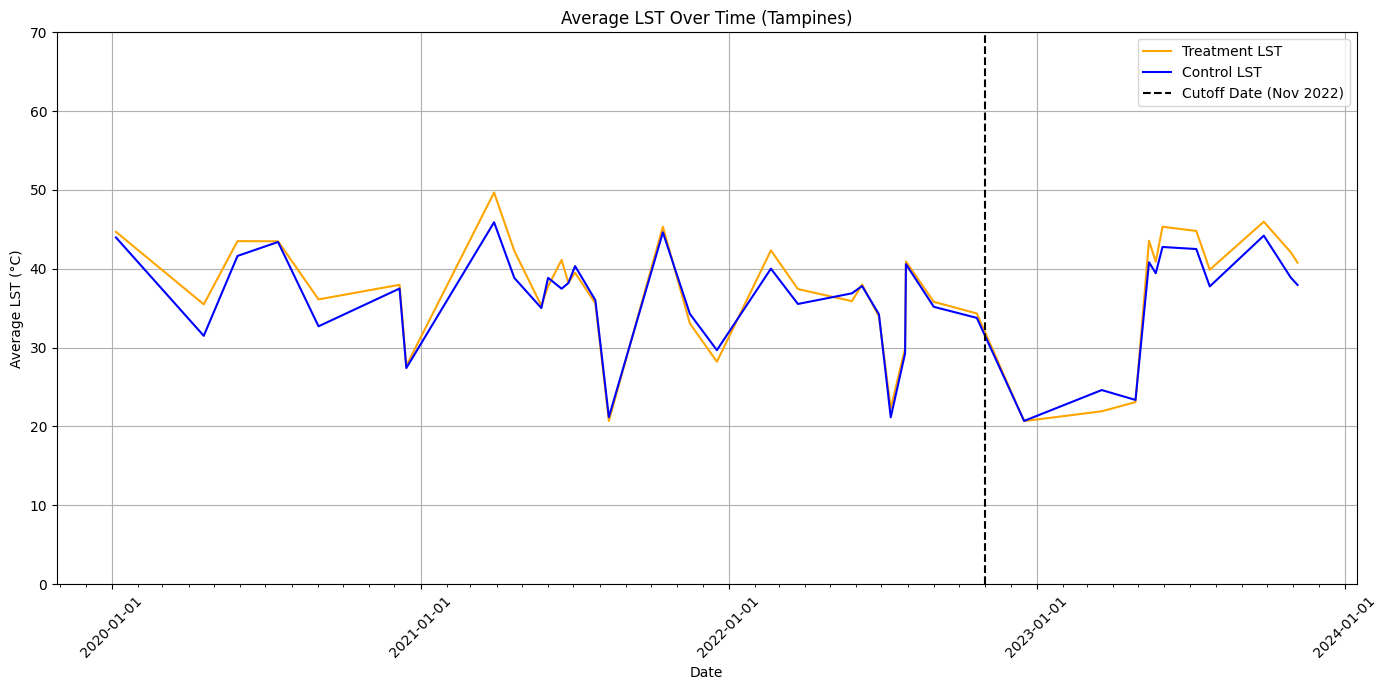

In [784]:
# Convert the 'time' column to datetime format
tampines_treatment_data['time'] = pd.to_datetime(tampines_treatment_data['time'])
tampines_control_data['time'] = pd.to_datetime(tampines_control_data['time'])

# Filter out unwanted QA_PIXEL values
qa_pixel_filter_1 = [5504, 5506, 54534, 54790, 22280, 5896, 55052, 7440, 7696, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 54852, 24144, 23888, 56660, 56916]
tampines_treatment_data = tampines_treatment_data[~tampines_treatment_data['QA_PIXEL'].isin(qa_pixel_filter_1)]
tampines_control_data = tampines_control_data[~tampines_control_data['QA_PIXEL'].isin(qa_pixel_filter_1)]

# Additional filtering for 'SR_QA_AEROSOL'
sr_qa_aerosol_filter_1 = [192, 194, 196, 224, 228]  # Filtering out high aerosol levels
tampines_treatment_data = tampines_treatment_data[~tampines_treatment_data['SR_QA_AEROSOL'].isin(sr_qa_aerosol_filter_1)]
tampines_control_data = tampines_control_data[~tampines_control_data['SR_QA_AEROSOL'].isin(sr_qa_aerosol_filter_1)]

# Group by 'time' and calculate the average
tampines_average_treatment_lst = tampines_treatment_data.groupby(tampines_treatment_data['time'].dt.date)['LST_Celsius'].mean()
tampines_average_control_lst = tampines_control_data.groupby(tampines_control_data['time'].dt.date)['LST_Celsius'].mean()

# Use an outer join to include all dates from both groups
combined_dates = pd.concat([tampines_average_treatment_lst.rename('Treatment'), tampines_average_control_lst.rename('Control')], axis=1, join='inner')
dates = combined_dates.index  # This includes all dates from both datasets

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the data
ax.plot(dates, combined_dates['Treatment'], label='Treatment LST', color='orange')
ax.plot(dates, combined_dates['Control'], label='Control LST', color='blue')

# Formatting Date Axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Mark the treatment date
treatment_date = pd.Timestamp('2022-11-01')
plt.axvline(x=treatment_date, color='black', linestyle='--', label='Cutoff Date (Nov 2022)')

# Set plot attributes
ax.set_title('Average LST Over Time (Tampines)')
ax.set_xlabel('Date')
ax.set_ylabel('Average LST (°C)')
ax.set_ylim(bottom=0, top=70)
ax.grid(True)
ax.legend()

# Rotate date labels for clarity
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()

### Differences-in-Differences Regression

##### Coefficient of `treatment:treatment_date` is -0.0238 and is not statistically significant

In [785]:
tampines_treatment_data = tampines_treatment_data[tampines_treatment_data['treatment_roof'] == 0]
print(tampines_treatment_data)

# Add 'treatment' column: 1 for treatment data, 0 for control data
tampines_treatment_data['treatment'] = 1
tampines_control_data['treatment'] = 0

tampines_treatment_data['group'] = 'Treatment'
tampines_control_data['group'] = 'Control'

# Combine the treatment and control datasets
tampines_combined_data = pd.concat([tampines_treatment_data, tampines_control_data], ignore_index=True)

# Convert 'time' column to datetime if it's not already
tampines_combined_data['time'] = pd.to_datetime(tampines_combined_data['time'])

# Create 'time' column for post-treatment period, assigning 1 for post-treatment and 0 otherwise
cutoff_date = pd.Timestamp('2022-11-01')
tampines_combined_data['treatment_date'] = (tampines_combined_data['time'].dt.date >= cutoff_date.date()).astype(int)

# Ensure your DataFrame has an appropriate index for panel data analysis
tampines_combined_data = tampines_combined_data.set_index(['block', 'time'], drop=False)

        Longitude  Latitude    SR_B1    SR_B2    SR_B3    SR_B4    SR_B5  \
126    103.936005  1.354417  10121.0  10699.0  11983.0  13141.0  14793.0   
127    103.936275  1.354417  10700.0  10905.0  12235.0  12669.0  15450.0   
128    103.936544  1.354417  11100.0  11791.0  13455.0  13682.0  16485.0   
151    103.935466  1.354145   9221.0   9426.0  10726.0  10437.0  17868.0   
152    103.935735  1.354145   9913.0  10213.0  11465.0  10967.0  17625.0   
...           ...       ...      ...      ...      ...      ...      ...   
51472  103.934390  1.348446  10102.0  11067.0  12773.0  15272.0  16677.0   
51473  103.934659  1.348446  10937.0  11189.0  13097.0  15995.0  16946.0   
51474  103.934929  1.348446  11885.0  12642.0  14062.0  16716.0  17754.0   
51480  103.935200  1.346004  10102.0  10457.0  10714.0  15755.0  13166.0   
51481  103.935469  1.346004  10700.0  11067.0  11150.0  15755.0  13842.0   

         SR_B6    SR_B7  SR_QA_AEROSOL  ...  ST_URAD_Scaled       time  \
126    12789.

In [786]:
# Define the formula for the regression model
formula = 'LST_Celsius ~ 1 + EntityEffects + TimeEffects + treatment:treatment_date'

# Fit the DiD regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=tampines_combined_data)

# Print the results
results = model.fit(cov_type='clustered', cluster_entity=True)

print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                     1.719e-06
Estimator:                   PanelOLS   R-squared (Between):             -0.0182
No. Observations:                6978   R-squared (Within):           -1.134e-05
Date:                Wed, Jul 10 2024   R-squared (Overall):             -0.0001
Time:                        15:03:08   Log-likelihood                -1.237e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.0117
Entities:                         114   P-value                           0.9139
Avg Obs:                       61.211   Distribution:                  F(1,6798)
Min Obs:                      10.0000                                           
Max Obs:                       228.00   F-statistic (robust):             0.0088
                            

### Prior Trends Test

##### The coefficient of `int_time_group` is -0.0211 and is not statistically significant

In [787]:
df = tampines_combined_data

# Define the cutoff date
cutoff_date = pd.Timestamp('2022-11-01')

# Filter the dataset to include only data before the cutoff date
df_pre = df[df['time'] < cutoff_date].copy()

# Ensure 'block' is a column if not already
df_pre['block'] = df_pre['block'] if 'block' in df_pre.columns else range(len(df_pre))

# Convert 'time' to datetime format if not already
df_pre['time'] = pd.to_datetime(df_pre['time'])

# Set the index to 'block' and 'time' for Panel data format
df_pre = df_pre.set_index(['block', 'time'])

# Create the time variable as the number of periods from the start of the data
df_pre['time_periods'] = pd.factorize(df_pre.index.get_level_values('time').date)[0]

# Create interaction term for Time * Group
df_pre['int_time_group'] = df_pre['time_periods'] * df_pre['treatment']

# Define the formula for PanelOLS
formula = 'LST_Celsius ~ 1 + time_periods + treatment + int_time_group'

# Fit the regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=df_pre, check_rank=False)
fitted_model = model.fit(cov_type='clustered', cluster_entity=True)

# Print the summary of the regression model
print(fitted_model)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.0474
Estimator:                   PanelOLS   R-squared (Between):              0.0822
No. Observations:                6525   R-squared (Within):               0.0441
Date:                Wed, Jul 10 2024   R-squared (Overall):              0.0474
Time:                        15:03:08   Log-likelihood                -2.072e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      108.19
Entities:                         114   P-value                           0.0000
Avg Obs:                       57.237   Distribution:                  F(3,6521)
Min Obs:                      10.0000                                           
Max Obs:                       158.00   F-statistic (robust):             48.094
                            

### Long-term Effects

In [788]:
# Sort the DataFrame by 'time' index level
tampines_combined_data.sort_index(level='time', inplace=True)

# Creating 'time_periods' variable, factorising 'time' column
tampines_combined_data['time_periods'] = pd.factorize(tampines_combined_data.index.get_level_values('time').date)[0]

# Finding the first treatment_date == 1
filtered_df = tampines_combined_data[tampines_combined_data['treatment_date'] == 1]

# Find the earliest date in the 'time' column for these rows
earliest_date = filtered_df['time'].min()

# Get the corresponding value in 'time_periods' for the earliest date
corresponding_time_period = filtered_df[filtered_df['time'] == earliest_date]['time_periods'].iloc[0]

# Print the earliest date and the corresponding 'time_periods' value
print("The earliest date for 'treatment_date' == 1 is:", earliest_date)
print("The corresponding value in 'time_periods' is:", corresponding_time_period)

The earliest date for 'treatment_date' == 1 is: 2022-12-17 00:00:00
The corresponding value in 'time_periods' is: 44


In [789]:
# Scale time periods, drop period right before treatment period
tampines_combined_data['time_periods_scaled'] = tampines_combined_data.time_periods - 43

In [790]:
# Filtering valid time periods (where both control and treatment data exist)

# Subset to dates with both control and treated blocks
grouped = tampines_combined_data.groupby(['group', pd.Grouper(freq='D', level='time')]).size().unstack(fill_value=0)
both_groups_present = (grouped.loc['Treatment'] > 0) & (grouped.loc['Control'] > 0)
valid_periods = both_groups_present[both_groups_present].index
#print(valid_periods)

#Subset the data to only include periods with control and treatment group, just in case error is due to this. but it is not, i.e., doing this step or not leads to the same error
tampines_combined_data['date'] = tampines_combined_data['time'].dt.date  # Extract date from datetime for comparison
valid_periods_set = set(valid_periods.date)  # Convert valid periods to a set of dates for efficient filtering

# Filter the DataFrame
tampines_subset_df = tampines_combined_data[tampines_combined_data['date'].isin(valid_periods_set)].copy()

#See the periods that we are left

# Get all values in 'time' column
unique_time_values = tampines_subset_df['time'].unique()
print(unique_time_values)

unique_period_values = tampines_subset_df['time_periods_scaled'].unique()
print(unique_period_values)

['2020-01-06T00:00:00.000000000' '2020-04-19T00:00:00.000000000'
 '2020-05-29T00:00:00.000000000' '2020-07-16T00:00:00.000000000'
 '2020-09-02T00:00:00.000000000' '2020-12-07T00:00:00.000000000'
 '2020-12-15T00:00:00.000000000' '2021-03-29T00:00:00.000000000'
 '2021-04-22T00:00:00.000000000' '2021-05-24T00:00:00.000000000'
 '2021-06-01T00:00:00.000000000' '2021-06-17T00:00:00.000000000'
 '2021-06-25T00:00:00.000000000' '2021-07-03T00:00:00.000000000'
 '2021-07-27T00:00:00.000000000' '2021-08-12T00:00:00.000000000'
 '2021-10-15T00:00:00.000000000' '2021-11-16T00:00:00.000000000'
 '2021-12-18T00:00:00.000000000' '2022-02-20T00:00:00.000000000'
 '2022-03-24T00:00:00.000000000' '2022-05-27T00:00:00.000000000'
 '2022-06-08T00:00:00.000000000' '2022-06-28T00:00:00.000000000'
 '2022-07-12T00:00:00.000000000' '2022-07-29T00:00:00.000000000'
 '2022-07-30T00:00:00.000000000' '2022-09-01T00:00:00.000000000'
 '2022-10-22T00:00:00.000000000' '2022-12-17T00:00:00.000000000'
 '2023-03-19T00:00:00.000

In [791]:
#Set index again to be sure
tampines_subset_df = tampines_subset_df.set_index(['block', 'time_periods_scaled'], drop=False)

In [792]:
# Ensure 'time_periods_scaled' is treated as a categorical variable
tampines_subset_df['time_periods'] = tampines_subset_df['time_periods'].astype('category')

# Create dummy variables for 'time_periods_scaled'
time_dummies = pd.get_dummies(tampines_subset_df['time_periods'], prefix='T')

time_dummies.head()

T_0  T_2  T_4  T_5  T_6  T_8  T_9  T_14  \
block       time_periods_scaled                                            
polygon_808 -43                    1    0    0    0    0    0    0     0   
polygon_809 -43                    1    0    0    0    0    0    0     0   
polygon_823 -43                    1    0    0    0    0    0    0     0   
polygon_828 -43                    1    0    0    0    0    0    0     0   
            -43                    1    0    0    0    0    0    0     0   

                                 T_15  T_16  ...  T_46  T_48  T_49  T_50  \
block       time_periods_scaled              ...                           
polygon_808 -43                     0     0  ...     0     0     0     0   
polygon_809 -43                     0     0  ...     0     0     0     0   
polygon_823 -43                     0     0  ...     0     0     0     0   
polygon_828 -43                     0     0  ...     0     0     0     0   
            -43                     0     0  ...     0     0     0     0   

                                 T_51  T_53  T_54  T_55  T_57  T_58  
block       time_periods_scaled                                      
polygon_808 -43                     0     0     0     0     0     0  
polygon_809 -43                     0     0     0     0     0     0  
polygon_823 -43                     0     0     0     0     0     0  
polygon_828 -43                     0     0     0     0     0     0  
            -43                     0     0     0     0     0     0  

[5 rows x 40 columns]

In [793]:
# Drop one period before T_32
time_dummies.drop('T_43', axis=1, inplace=True)

In [794]:
# Add the dummy variables to the DataFrame
tampines_subset_df = pd.concat([tampines_subset_df, time_dummies], axis=1)

In [795]:
# Create a dictionary to hold the time values for each dummy variable
dummy_time_mapping = {}

# Iterate over each dummy variable
for dummy in time_dummies.columns:
    # Extract the 'time' values where the dummy variable is 1
    times = tampines_subset_df.loc[tampines_subset_df[dummy] == 1, 'time'].unique()
    dummy_time_mapping[dummy] = times

# Print the mapping
for dummy, times in dummy_time_mapping.items():
    print(f'{dummy}: {times}')

T_0: ['2020-01-06T00:00:00.000000000']
T_2: ['2020-04-19T00:00:00.000000000']
T_4: ['2020-05-29T00:00:00.000000000']
T_5: ['2020-07-16T00:00:00.000000000']
T_6: ['2020-09-02T00:00:00.000000000']
T_8: ['2020-12-07T00:00:00.000000000']
T_9: ['2020-12-15T00:00:00.000000000']
T_14: ['2021-03-29T00:00:00.000000000']
T_15: ['2021-04-22T00:00:00.000000000']
T_16: ['2021-05-24T00:00:00.000000000']
T_17: ['2021-06-01T00:00:00.000000000']
T_18: ['2021-06-17T00:00:00.000000000']
T_19: ['2021-06-25T00:00:00.000000000']
T_20: ['2021-07-03T00:00:00.000000000']
T_21: ['2021-07-27T00:00:00.000000000']
T_22: ['2021-08-12T00:00:00.000000000']
T_25: ['2021-10-15T00:00:00.000000000']
T_28: ['2021-11-16T00:00:00.000000000']
T_29: ['2021-12-18T00:00:00.000000000']
T_30: ['2022-02-20T00:00:00.000000000']
T_32: ['2022-03-24T00:00:00.000000000']
T_36: ['2022-05-27T00:00:00.000000000']
T_37: ['2022-06-08T00:00:00.000000000']
T_38: ['2022-06-28T00:00:00.000000000']
T_39: ['2022-07-12T00:00:00.000000000']
T_40: [

In [796]:
interaction_vars = []
for col in time_dummies.columns:
    interaction_col = f'{col}_treatment'
    tampines_subset_df[interaction_col] = tampines_subset_df[col] * tampines_subset_df['treatment']
    interaction_vars.append(interaction_col)

In [797]:
# Create the interaction terms string
interaction_terms = ' + '.join(interaction_vars)

# Display the interaction terms string
print(interaction_terms)

# Create the model formula, including the interaction terms and other covariates
formula = f'LST_Celsius ~ 1 + {interaction_terms} + EntityEffects + TimeEffects'

# Print the formula to verify
print(formula)

T_0_treatment + T_2_treatment + T_4_treatment + T_5_treatment + T_6_treatment + T_8_treatment + T_9_treatment + T_14_treatment + T_15_treatment + T_16_treatment + T_17_treatment + T_18_treatment + T_19_treatment + T_20_treatment + T_21_treatment + T_22_treatment + T_25_treatment + T_28_treatment + T_29_treatment + T_30_treatment + T_32_treatment + T_36_treatment + T_37_treatment + T_38_treatment + T_39_treatment + T_40_treatment + T_41_treatment + T_42_treatment + T_44_treatment + T_46_treatment + T_48_treatment + T_49_treatment + T_50_treatment + T_51_treatment + T_53_treatment + T_54_treatment + T_55_treatment + T_57_treatment + T_58_treatment
LST_Celsius ~ 1 + T_0_treatment + T_2_treatment + T_4_treatment + T_5_treatment + T_6_treatment + T_8_treatment + T_9_treatment + T_14_treatment + T_15_treatment + T_16_treatment + T_17_treatment + T_18_treatment + T_19_treatment + T_20_treatment + T_21_treatment + T_22_treatment + T_25_treatment + T_28_treatment + T_29_treatment + T_30_treatme

In [798]:
# Fit the DiD regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=tampines_subset_df, drop_absorbed=True)

# Print the results
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.1565
Estimator:                   PanelOLS   R-squared (Between):              0.0718
No. Observations:                6140   R-squared (Within):               0.0559
Date:                Wed, Jul 10 2024   R-squared (Overall):              0.0580
Time:                        15:03:09   Log-likelihood                -1.029e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      28.296
Entities:                         114   P-value                           0.0000
Avg Obs:                       53.860   Distribution:                 F(39,5948)
Min Obs:                       9.0000                                           
Max Obs:                       206.00   F-statistic (robust):             318.28
                            

## Tampines 2020 - 2024 (Treatment == Roof + Building Surfaces)

### Filtering Criteria for Clouds

In [799]:
# File paths for Landsat 8 and 9 data
file_paths = {
    'Landsat8': {
        'treatment': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat8\Tampines_Treatment_Filtered_2020_to_2024.csv",
        'control': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat8\Tampines_Control_Filtered_2020_to_2024.csv"
    },
    'Landsat9': {
        'treatment': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat9\Tampines_Treatment_Filtered_2021_to_2024.csv",
        'control': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat9\Tampines_Control_Filtered_2021_to_2024.csv"
    },
    'Landsat7': {
        'treatment': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat7\Tampines_Treatment_Filtered_2020_to_2022.csv",
        'control': r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tampines\Landsat7\Tampines_Control_Filtered_2020_to_2022.csv"
    }
}

tampines_treatment_frames = []
tampines_control_frames = []

batch_4 = ['polygon_860B', 'polygon_860', 'polygon_860A', 'polygon_859A', 'polygon_859', 'polygon_859B', 'polygon_858B', 'polygon_858', 'polygon_858A', 'polygon_861A', 'polygon_861',
           'polygon_855', 'polygon_853', 'polygon_849', 'polygon_851', 'polygon_847', 'polygon_845', 'polygon_843',
           'polygon_841', 'polygon_840', 'polygon_839', 'polygon_838', 'polygon_835', 'polygon_837', 'polygon_836', 'polygon_832', 'polygon_830', 'polygon_831', 'polygon_833',
           'polygon_876', 'polygon_875', 'polygon_877', 'polygon_878', 'polygon_879', 'polygon_880', 'polygon_880A', 'Lighthouse Evangelism']

exclude = ['Tampines West Community Club', 'Tampines Central Community Club', 'Lighthouse Evangelism', 'Singapore Soka Association Headquarters']

roof_paint = [ 'polygon_848', 'polygon_846']

# Load data, add 'SATELLITE' and 'CTRL_TREATMENT' columns, and normalize the temperature column name
for satellite, paths in file_paths.items():
    for group, path in paths.items():
        temp_df = pd.read_csv(path)
        temp_df.rename(columns={'block_num': 'block'}, inplace=True)
        temp_df['SATELLITE'] = satellite
        temp_df['CTRL_TREATMENT'] = group
        # Check the satellite and rename the corresponding temperature column to 'LST_Celsius'
        if 'Landsat7' in satellite:
            temp_df.rename(columns={'ST_B6_Celsius': 'LST_Celsius'}, inplace=True)
        else:
            temp_df.rename(columns={'ST_B10_Celsius': 'LST_Celsius'}, inplace=True)
        if group == 'treatment':
            tampines_treatment_frames.append(temp_df)
        else:
            tampines_control_frames.append(temp_df)

# Concatenate all treatment and control data into single DataFrames
tampines_treatment_data = pd.concat(tampines_treatment_frames, ignore_index=True)
tampines_control_data = pd.concat(tampines_control_frames, ignore_index=True)

tampines_treatment_data = tampines_treatment_data[~tampines_treatment_data['block'].isin(batch_4)].copy()
tampines_control_data = tampines_control_data[~tampines_control_data['block'].isin(batch_4)].copy()

tampines_treatment_data = tampines_treatment_data[~tampines_treatment_data['block'].isin(exclude)].copy()
tampines_control_data = tampines_control_data[~tampines_control_data['block'].isin(exclude)].copy()

tampines_treatment_data['treatment_roof'] = np.where(tampines_treatment_data['block'].isin(roof_paint), 1, 0)

# Assuming treatment_data and control_data are already loaded and contain the 'QA_PIXEL' column
tampines_treatment_data['QA_PIXEL'] = tampines_treatment_data['QA_PIXEL'].fillna(-1).astype(int)
tampines_control_data['QA_PIXEL'] = tampines_control_data['QA_PIXEL'].fillna(-1).astype(int)

# # Combine unique values from both datasets
# unique_values_treatment = set(tampines_treatment_data['QA_PIXEL'].unique())
# unique_values_control = set(tampines_control_data['QA_PIXEL'].unique())
# all_unique_values = unique_values_treatment.union(unique_values_control)  # Use set union to avoid duplicates

# def convert_to_binary_16(value):
#     # Convert value to binary, padded to 16 bits
#     if value == -1:
#         return 'NaN'  # Return a string 'NaN' for placeholder
#     binary_string = format(value, '016b')
#     # Split the binary string into 4 groups of 4 digits each
#     return ' '.join([binary_string[i:i+4] for i in range(0, 16, 4)])

# # Convert and print all unique values
# for value in all_unique_values:
#     binary_representation = convert_to_binary_16(value)
#     print(f'Original: {value}, Binary: {binary_representation}')

In [800]:
# Filtering Criteria (1):
# qa_pixel_filter_1 = [5504, 5506, 54534, 54790, 22280, 5896, 55052, 7440, 7696, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 54852, 24144, 23888, 56660, 56916]
# sr_qa_aerosol_filter_1 = [192, 194, 196, 224, 228]

### Plot for Average LST against Time

#### Tampines Treatment & Control 2019 - 2024

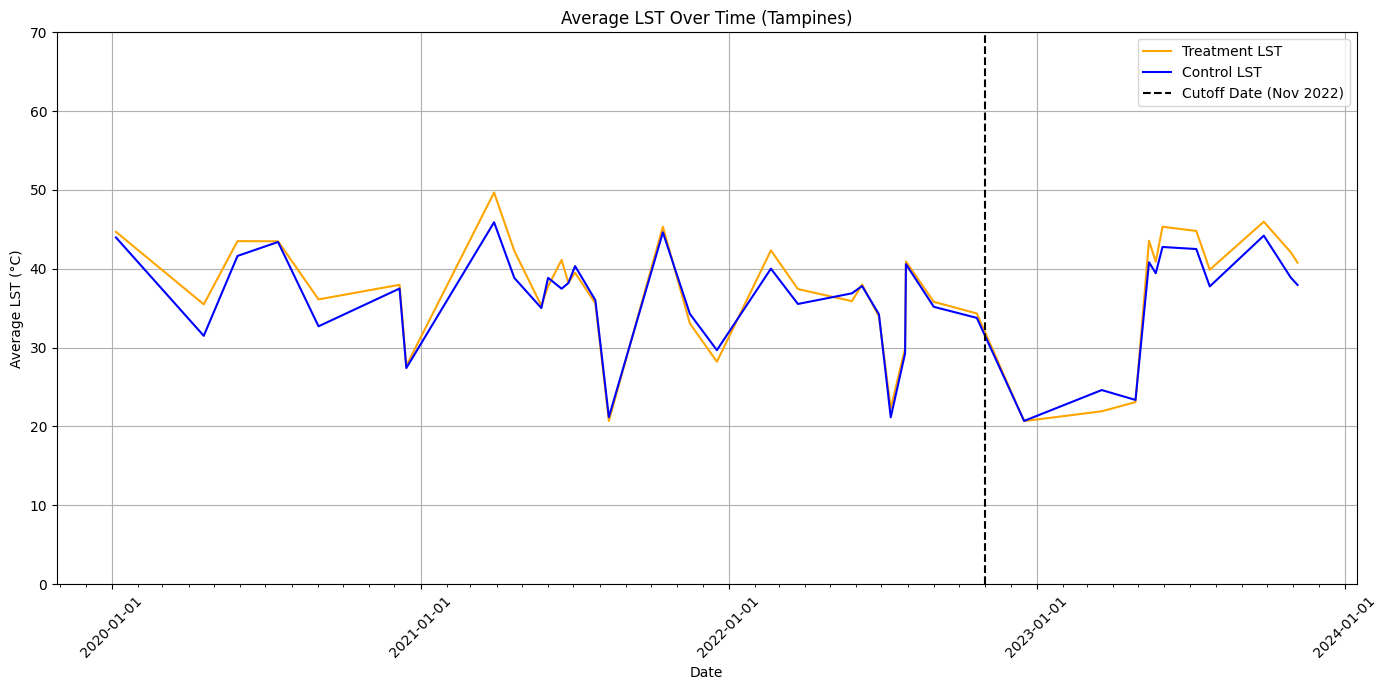

In [801]:
# Convert the 'time' column to datetime format
tampines_treatment_data['time'] = pd.to_datetime(tampines_treatment_data['time'])
tampines_control_data['time'] = pd.to_datetime(tampines_control_data['time'])

# Filter out unwanted QA_PIXEL values
qa_pixel_filter_1 = [5504, 5506, 54534, 54790, 22280, 5896, 55052, 7440, 7696, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 54852, 24144, 23888, 56660, 56916]
tampines_treatment_data = tampines_treatment_data[~tampines_treatment_data['QA_PIXEL'].isin(qa_pixel_filter_1)]
tampines_control_data = tampines_control_data[~tampines_control_data['QA_PIXEL'].isin(qa_pixel_filter_1)]

# Additional filtering for 'SR_QA_AEROSOL'
sr_qa_aerosol_filter_1 = [192, 194, 196, 224, 228]  # Filtering out high aerosol levels
tampines_treatment_data = tampines_treatment_data[~tampines_treatment_data['SR_QA_AEROSOL'].isin(sr_qa_aerosol_filter_1)]
tampines_control_data = tampines_control_data[~tampines_control_data['SR_QA_AEROSOL'].isin(sr_qa_aerosol_filter_1)]

# Group by 'time' and calculate the average
tampines_average_treatment_lst = tampines_treatment_data.groupby(tampines_treatment_data['time'].dt.date)['LST_Celsius'].mean()
tampines_average_control_lst = tampines_control_data.groupby(tampines_control_data['time'].dt.date)['LST_Celsius'].mean()

# Use an outer join to include all dates from both groups
combined_dates = pd.concat([tampines_average_treatment_lst.rename('Treatment'), tampines_average_control_lst.rename('Control')], axis=1, join='inner')
dates = combined_dates.index  # This includes all dates from both datasets

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the data
ax.plot(dates, combined_dates['Treatment'], label='Treatment LST', color='orange')
ax.plot(dates, combined_dates['Control'], label='Control LST', color='blue')

# Formatting Date Axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Mark the treatment date
treatment_date = pd.Timestamp('2022-11-01')
plt.axvline(x=treatment_date, color='black', linestyle='--', label='Cutoff Date (Nov 2022)')

# Set plot attributes
ax.set_title('Average LST Over Time (Tampines)')
ax.set_xlabel('Date')
ax.set_ylabel('Average LST (°C)')
ax.set_ylim(bottom=0, top=70)
ax.grid(True)
ax.legend()

# Rotate date labels for clarity
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()

### Differences-in-Differences Regression

##### Coefficient of `treatment:treatment_date` is -0.9153 and is statistically significant

In [802]:
tampines_treatment_data = tampines_treatment_data[tampines_treatment_data['treatment_roof'] == 1]

print(tampines_treatment_data)

# Add 'treatment' column: 1 for treatment data, 0 for control data
tampines_treatment_data['treatment'] = 1
tampines_control_data['treatment'] = 0

tampines_treatment_data['group'] = 'Treatment'
tampines_control_data['group'] = 'Control'

# Combine the treatment and control datasets
tampines_combined_data = pd.concat([tampines_treatment_data, tampines_control_data], ignore_index=True)

# Convert 'time' column to datetime if it's not already
tampines_combined_data['time'] = pd.to_datetime(tampines_combined_data['time'])

# Create 'time' column for post-treatment period, assigning 1 for post-treatment and 0 otherwise
cutoff_date = pd.Timestamp('2022-11-01')
tampines_combined_data['treatment_date'] = (tampines_combined_data['time'].dt.date >= cutoff_date.date()).astype(int)

# Ensure your DataFrame has an appropriate index for panel data analysis
tampines_combined_data = tampines_combined_data.set_index(['block', 'time'], drop=False)

        Longitude  Latitude    SR_B1    SR_B2    SR_B3    SR_B4    SR_B5  \
293    103.936006  1.351974  10060.0  10661.0  12210.0  12078.0  13676.0   
8501   103.935736  1.352517  21395.0  21533.0  22502.0  22555.0  24801.0   
8502   103.936006  1.352517  21183.0  21296.0  22272.0  22275.0  24462.0   
8503   103.936275  1.352517  15497.0  15552.0  17594.0  17323.0  20356.0   
8524   103.936006  1.352246  23005.0  23325.0  23543.0  23789.0  25926.0   
...           ...       ...      ...      ...      ...      ...      ...   
51100  103.936276  1.351974  11877.0  13119.0  13803.0  16584.0  16577.0   
51406  103.936006  1.352517  11177.0  11554.0  12126.0  14788.0  13842.0   
51407  103.936275  1.352517  10581.0  11554.0  12342.0  14788.0  13571.0   
51408  103.936006  1.352246  11413.0  12038.0  12666.0  15271.0  14383.0   
51409  103.936275  1.352246  11057.0  11676.0  12234.0  14546.0  13842.0   

         SR_B6    SR_B7  SR_QA_AEROSOL  ...  ST_URAD_Scaled       time  \
293    14617.

In [803]:
# Define the formula for the regression model
formula = 'LST_Celsius ~ 1 + EntityEffects + TimeEffects + treatment:treatment_date'

# Fit the DiD regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=tampines_combined_data)

# Print the results
results = model.fit(cov_type='clustered', cluster_entity=True)

print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.0003
Estimator:                   PanelOLS   R-squared (Between):             -0.0038
No. Observations:                1728   R-squared (Within):               0.0016
Date:                Wed, Jul 10 2024   R-squared (Overall):              0.0014
Time:                        15:03:10   Log-likelihood                   -2709.9
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.4588
Entities:                          32   P-value                           0.4983
Avg Obs:                       54.000   Distribution:                  F(1,1648)
Min Obs:                       35.000                                           
Max Obs:                       119.00   F-statistic (robust):             53.583
                            

### Prior Trends Test

##### The coefficient of `int_time_group` is -0.0907 and is statistically significant

In [804]:
df = tampines_combined_data

# Define the cutoff date
cutoff_date = pd.Timestamp('2022-11-01')

# Filter the dataset to include only data before the cutoff date
df_pre = df[df['time'] < cutoff_date].copy()

# Ensure 'block' is a column if not already
df_pre['block'] = df_pre['block'] if 'block' in df_pre.columns else range(len(df_pre))

# Convert 'time' to datetime format if not already
df_pre['time'] = pd.to_datetime(df_pre['time'])

# Set the index to 'block' and 'time' for Panel data format
df_pre = df_pre.set_index(['block', 'time'])

# Create the time variable as the number of periods from the start of the data
df_pre['time_periods'] = pd.factorize(df_pre.index.get_level_values('time').date)[0]

# Create interaction term for Time * Group
df_pre['int_time_group'] = df_pre['time_periods'] * df_pre['treatment']

# Define the formula for PanelOLS
formula = 'LST_Celsius ~ 1 + time_periods + treatment + int_time_group'

# Fit the regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=df_pre, check_rank=False)
fitted_model = model.fit(cov_type='clustered', cluster_entity=True)

# Print the summary of the regression model
print(fitted_model)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.0360
Estimator:                   PanelOLS   R-squared (Between):              0.1505
No. Observations:                1650   R-squared (Within):               0.0307
Date:                Wed, Jul 10 2024   R-squared (Overall):              0.0360
Time:                        15:03:10   Log-likelihood                   -5260.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      20.482
Entities:                          32   P-value                           0.0000
Avg Obs:                       51.562   Distribution:                  F(3,1646)
Min Obs:                       32.000                                           
Max Obs:                       117.00   F-statistic (robust):             43.073
                            

### Long-term Effects

In [805]:
# Sort the DataFrame by 'time' index level
tampines_combined_data.sort_index(level='time', inplace=True)

# Creating 'time_periods' variable, factorising 'time' column
tampines_combined_data['time_periods'] = pd.factorize(tampines_combined_data.index.get_level_values('time').date)[0]

# Finding the first treatment_date == 1
filtered_df = tampines_combined_data[tampines_combined_data['treatment_date'] == 1]

# Find the earliest date in the 'time' column for these rows
earliest_date = filtered_df['time'].min()

# Get the corresponding value in 'time_periods' for the earliest date
corresponding_time_period = filtered_df[filtered_df['time'] == earliest_date]['time_periods'].iloc[0]

# Print the earliest date and the corresponding 'time_periods' value
print("The earliest date for 'treatment_date' == 1 is:", earliest_date)
print("The corresponding value in 'time_periods' is:", corresponding_time_period)

The earliest date for 'treatment_date' == 1 is: 2022-12-17 00:00:00
The corresponding value in 'time_periods' is: 35


In [806]:
# Scale time periods, drop period right before treatment period
tampines_combined_data['time_periods_scaled'] = tampines_combined_data.time_periods - 43

In [807]:
# Filtering valid time periods (where both control and treatment data exist)

# Subset to dates with both control and treated blocks
grouped = tampines_combined_data.groupby(['group', pd.Grouper(freq='D', level='time')]).size().unstack(fill_value=0)
both_groups_present = (grouped.loc['Treatment'] > 0) & (grouped.loc['Control'] > 0)
valid_periods = both_groups_present[both_groups_present].index
#print(valid_periods)

#Subset the data to only include periods with control and treatment group, just in case error is due to this. but it is not, i.e., doing this step or not leads to the same error
tampines_combined_data['date'] = tampines_combined_data['time'].dt.date  # Extract date from datetime for comparison
valid_periods_set = set(valid_periods.date)  # Convert valid periods to a set of dates for efficient filtering

# Filter the DataFrame
tampines_subset_df = tampines_combined_data[tampines_combined_data['date'].isin(valid_periods_set)].copy()

#See the periods that we are left

# Get all values in 'time' column
unique_time_values = tampines_subset_df['time'].unique()
print(unique_time_values)

unique_period_values = tampines_subset_df['time_periods_scaled'].unique()
print(unique_period_values)

['2020-01-06T00:00:00.000000000' '2020-12-15T00:00:00.000000000'
 '2021-04-22T00:00:00.000000000' '2021-05-24T00:00:00.000000000'
 '2021-06-25T00:00:00.000000000' '2021-07-27T00:00:00.000000000'
 '2021-10-15T00:00:00.000000000' '2021-12-18T00:00:00.000000000'
 '2022-03-24T00:00:00.000000000' '2022-05-27T00:00:00.000000000'
 '2022-07-29T00:00:00.000000000' '2022-10-22T00:00:00.000000000'
 '2022-12-17T00:00:00.000000000']
[-43 -35 -32 -31 -28 -26 -23 -19 -17 -16 -12  -9  -8]


In [808]:
#Set index again to be sure
tampines_subset_df = tampines_subset_df.set_index(['block', 'time_periods_scaled'], drop=False)

In [809]:
# Ensure 'time_periods_scaled' is treated as a categorical variable
tampines_subset_df['time_periods'] = tampines_subset_df['time_periods'].astype('category')

# Create dummy variables for 'time_periods_scaled'
time_dummies = pd.get_dummies(tampines_subset_df['time_periods'], prefix='T')

time_dummies.head()

,,T_0,T_8,T_11,T_12,T_15,T_17,T_20,T_24,T_26,T_27,T_31,T_34,T_35
block,time_periods_scaled,,,,,,,,,,,,,
polygon_808,-43,1,0,0,0,0,0,0,0,0,0,0,0,0
polygon_809,-43,1,0,0,0,0,0,0,0,0,0,0,0,0
polygon_846,-43,1,0,0,0,0,0,0,0,0,0,0,0,0
polygon_928,-43,1,0,0,0,0,0,0,0,0,0,0,0,0
polygon_801,-35,0,1,0,0,0,0,0,0,0,0,0,0,0


In [810]:
# Drop one period before T_32
time_dummies.drop('T_43', axis=1, inplace=True)

KeyError: "['T_43'] not found in axis"

In [ ]:
# Add the dummy variables to the DataFrame
tampines_subset_df = pd.concat([tampines_subset_df, time_dummies], axis=1)

In [ ]:
# Create a dictionary to hold the time values for each dummy variable
dummy_time_mapping = {}

# Iterate over each dummy variable
for dummy in time_dummies.columns:
    # Extract the 'time' values where the dummy variable is 1
    times = tampines_subset_df.loc[tampines_subset_df[dummy] == 1, 'time'].unique()
    dummy_time_mapping[dummy] = times

# Print the mapping
for dummy, times in dummy_time_mapping.items():
    print(f'{dummy}: {times}')

T_0: ['2020-01-06T00:00:00.000000000']
T_2: ['2020-04-19T00:00:00.000000000']
T_4: ['2020-05-29T00:00:00.000000000']
T_5: ['2020-07-16T00:00:00.000000000']
T_6: ['2020-09-02T00:00:00.000000000']
T_8: ['2020-12-07T00:00:00.000000000']
T_9: ['2020-12-15T00:00:00.000000000']
T_14: ['2021-03-29T00:00:00.000000000']
T_15: ['2021-04-22T00:00:00.000000000']
T_16: ['2021-05-24T00:00:00.000000000']
T_17: ['2021-06-01T00:00:00.000000000']
T_18: ['2021-06-17T00:00:00.000000000']
T_19: ['2021-06-25T00:00:00.000000000']
T_20: ['2021-07-03T00:00:00.000000000']
T_21: ['2021-07-27T00:00:00.000000000']
T_22: ['2021-08-12T00:00:00.000000000']
T_25: ['2021-10-15T00:00:00.000000000']
T_28: ['2021-11-16T00:00:00.000000000']
T_29: ['2021-12-18T00:00:00.000000000']
T_30: ['2022-02-20T00:00:00.000000000']
T_32: ['2022-03-24T00:00:00.000000000']
T_36: ['2022-05-27T00:00:00.000000000']
T_37: ['2022-06-08T00:00:00.000000000']
T_38: ['2022-06-28T00:00:00.000000000']
T_39: ['2022-07-12T00:00:00.000000000']
T_40: [

In [ ]:
interaction_vars = []
for col in time_dummies.columns:
    interaction_col = f'{col}_treatment'
    tampines_subset_df[interaction_col] = tampines_subset_df[col] * tampines_subset_df['treatment']
    interaction_vars.append(interaction_col)

In [ ]:
# Create the interaction terms string
interaction_terms = ' + '.join(interaction_vars)

# Display the interaction terms string
print(interaction_terms)

# Create the model formula, including the interaction terms and other covariates
formula = f'LST_Celsius ~ 1 + {interaction_terms} + EntityEffects + TimeEffects'

# Print the formula to verify
print(formula)

T_0_treatment + T_2_treatment + T_4_treatment + T_5_treatment + T_6_treatment + T_8_treatment + T_9_treatment + T_14_treatment + T_15_treatment + T_16_treatment + T_17_treatment + T_18_treatment + T_19_treatment + T_20_treatment + T_21_treatment + T_22_treatment + T_25_treatment + T_28_treatment + T_29_treatment + T_30_treatment + T_32_treatment + T_36_treatment + T_37_treatment + T_38_treatment + T_39_treatment + T_40_treatment + T_41_treatment + T_42_treatment + T_44_treatment + T_46_treatment + T_48_treatment + T_49_treatment + T_50_treatment + T_51_treatment + T_53_treatment + T_54_treatment + T_55_treatment + T_57_treatment + T_58_treatment
LST_Celsius ~ 1 + T_0_treatment + T_2_treatment + T_4_treatment + T_5_treatment + T_6_treatment + T_8_treatment + T_9_treatment + T_14_treatment + T_15_treatment + T_16_treatment + T_17_treatment + T_18_treatment + T_19_treatment + T_20_treatment + T_21_treatment + T_22_treatment + T_25_treatment + T_28_treatment + T_29_treatment + T_30_treatme

In [ ]:
# Fit the DiD regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=tampines_subset_df, drop_absorbed=True)

# Print the results
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.1549
Estimator:                   PanelOLS   R-squared (Between):              0.0771
No. Observations:                6208   R-squared (Within):               0.0572
Date:                Sat, Jul 06 2024   R-squared (Overall):              0.0594
Time:                        23:17:10   Log-likelihood                -1.044e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      28.270
Entities:                         116   P-value                           0.0000
Avg Obs:                       53.517   Distribution:                 F(39,6014)
Min Obs:                       9.0000                                           
Max Obs:                       206.00   F-statistic (robust):             327.71
                            

## Hawker Centres

In [117]:
# File paths for both Landsat 8 and Landsat 9 datasets
file_path_L8 = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\HawkerCentres\Landsat8\Hawker_Centres_Filtered_2021_to_2024.csv"
file_path_L9 = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\HawkerCentres\Landsat9\Hawker_Centres_Filtered_2021_to_2024.csv"
file_path_L7 = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\HawkerCentres\Landsat7\Hawker_Centres_Filtered_2021_to_2022.csv"

# Load the datasets
data_L8 = pd.read_csv(file_path_L8)
data_L9 = pd.read_csv(file_path_L9)
data_L7 = pd.read_csv(file_path_L7)

# Rename temperature columns to a unified column name 'LST_Celsius'
data_L8.rename(columns={'ST_B10_Celsius': 'LST_Celsius'}, inplace=True)
data_L9.rename(columns={'ST_B10_Celsius': 'LST_Celsius'}, inplace=True)
data_L7.rename(columns={'ST_B6_Celsius': 'LST_Celsius'}, inplace=True)

# Convert 'time' column to datetime for both datasets
data_L8['time'] = pd.to_datetime(data_L8['time'])
data_L9['time'] = pd.to_datetime(data_L9['time'])
data_L7['time'] = pd.to_datetime(data_L7['time'])

# Concatenate both datasets
hawker_data = pd.concat([data_L8, data_L9, data_L7], ignore_index=True)

# # Combine unique values from QA_PIXEL across datasets
# hawker_data['QA_PIXEL'] = hawker_data['QA_PIXEL'].fillna(-1).astype(int)
# unique_values = pd.unique(hawker_data['QA_PIXEL'])

# # Print all unique QA_PIXEL values and their binary representations
# for value in unique_values:
#     binary_representation = convert_to_binary_16(value)
#     print(f'Original: {value}, Binary: {binary_representation}')

In [ ]:
# Filtering Criteria (1):
# qa_pixel_filter_1 = [5504, 5506, 54534, 54790, 22280, 5896, 55052, 7440, 7696, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 54852, 24144, 23888, 56660, 56916]
# sr_qa_aerosol_filter_1 = [192, 194, 196, 224, 228]

# Filtering Criteria (2):
# qa_pixel_filter_2 = [5504, 5506, 22280, 5896, 55052, 7440, 7696, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 24144, 23888, 56660, 56916]
# sr_qa_aerosol_filter_2 = [192, 194, 196]

### Holland Village Market & Food Centre

In [260]:
# File paths for both Landsat 8 and Landsat 9 datasets
file_path_L8 = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\HawkerCentres\Landsat8\Hawker_Centres_Filtered_2022_to_2024.csv"
file_path_L9 = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\HawkerCentres\Landsat9\Hawker_Centres_Filtered_2022_to_2024.csv"
file_path_L7 = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\HawkerCentres\Landsat7\all_data_2022.csv"

# Load the datasets
data_L8 = pd.read_csv(file_path_L8)
data_L9 = pd.read_csv(file_path_L9)
data_L7 = pd.read_csv(file_path_L7)

# Rename temperature columns to a unified column name 'LST_Celsius'
data_L8.rename(columns={'ST_B10_Celsius': 'LST_Celsius'}, inplace=True)
data_L9.rename(columns={'ST_B10_Celsius': 'LST_Celsius'}, inplace=True)
data_L7.rename(columns={'ST_B6_Celsius': 'LST_Celsius'}, inplace=True)

# Convert 'time' column to datetime for both datasets
data_L8['time'] = pd.to_datetime(data_L8['time'])
data_L9['time'] = pd.to_datetime(data_L9['time'])
data_L7['time'] = pd.to_datetime(data_L7['time'])

# Concatenate both datasets
hv_hawker_data = pd.concat([data_L8, data_L9, data_L7], ignore_index=True)

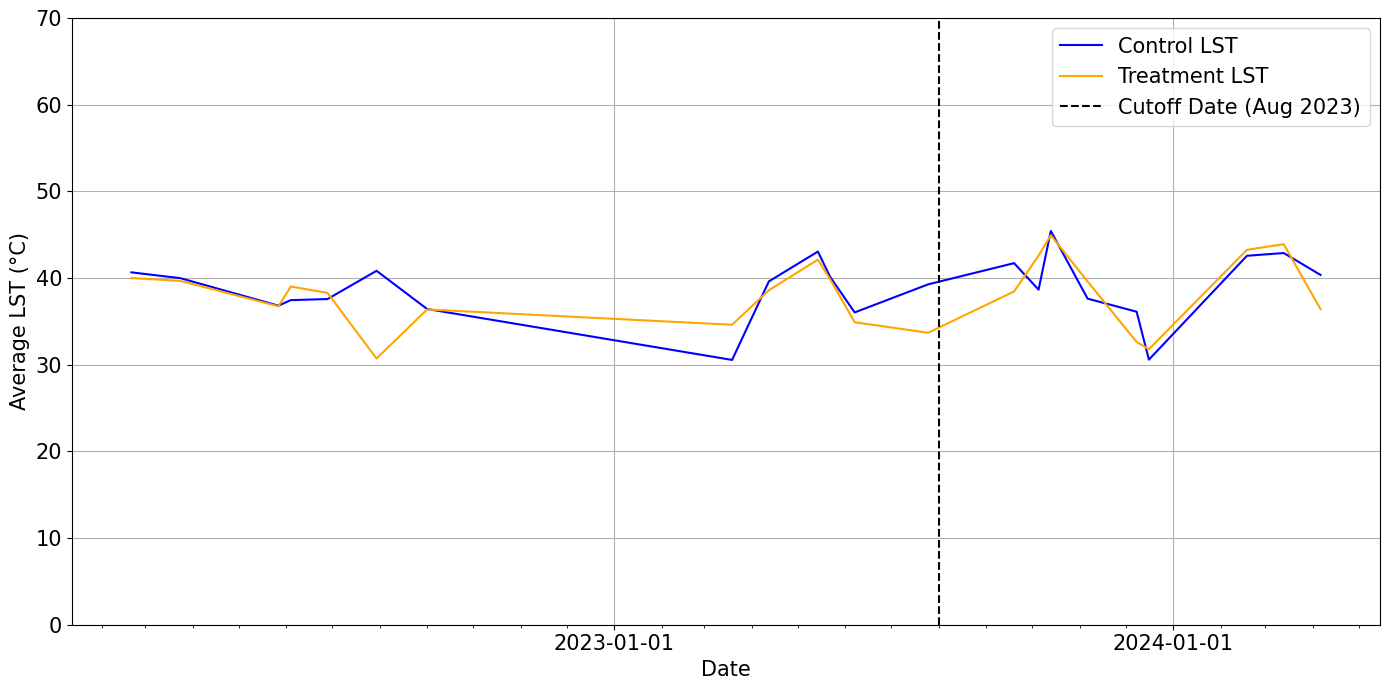

In [261]:
# List of hawker centres to be treated as "treatment"
treatment_centres = [
    # "North Bridge Road Market & Food Centre"
    "Holland Village Market & Food Centre"
    # "Commonwealth Crescent Market"
]

# Label data as 'treatment' or 'control' based on hawker centre
hv_hawker_data['CTRL_TREATMENT'] = hv_hawker_data['Hawker Centre'].apply(lambda x: 'treatment' if x in treatment_centres else 'control')

# Filter out unwanted QA_PIXEL values
qa_pixel_filter_2 = [5504, 5506, 22280, 5896, 55052, 7440, 7696, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 24144, 23888, 56660, 56916]
hv_hawker_data = hv_hawker_data[~hv_hawker_data['QA_PIXEL'].isin(qa_pixel_filter_2)]

# Additional filtering for 'SR_QA_AEROSOL'
sr_qa_aerosol_filter_2 = [192, 194, 196]
hv_hawker_data = hv_hawker_data[~hv_hawker_data['SR_QA_AEROSOL'].isin(sr_qa_aerosol_filter_2)]

# Split the data into treatment and control datasets
treatment_data = hv_hawker_data[hv_hawker_data['CTRL_TREATMENT'] == 'treatment']
control_data = hv_hawker_data[hv_hawker_data['CTRL_TREATMENT'] == 'control']

# Group by 'time' and calculate the average LST for treatment and control
average_treatment_lst = treatment_data.groupby('time')['LST_Celsius'].mean().reset_index()
average_control_lst = control_data.groupby('time')['LST_Celsius'].mean().reset_index()

# Group by 'time' and calculate the average LST for both 'treatment' and 'control'
grouped_data = hv_hawker_data.groupby(['CTRL_TREATMENT', hv_hawker_data['time'].dt.date])['LST_Celsius'].mean().unstack(0)

# Drop rows where any data is missing in either 'treatment' or 'control'
grouped_data.dropna(how='any', inplace=True)

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))

# Colors for each group
colors = {'treatment': 'orange', 'control': 'blue'}

# Plot each column as a line in the plot
for column in grouped_data.columns:
    ax.plot(grouped_data.index, grouped_data[column], label=f'{column.capitalize()} LST', color=colors[column])

# Formatting Date Axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Mark the treatment date
treatment_date = pd.Timestamp('2023-08-01')
plt.axvline(x=treatment_date, color='black', linestyle='--', label='Cutoff Date (Aug 2023)')

# Set plot attributes with increased font sizes
# ax.set_title('Average LST Over Time (Holland Village Market & Food Centre)', fontsize=20)
ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('Average LST (°C)', fontsize=15)
ax.set_ylim(bottom=0, top=70)
ax.grid(True)
ax.legend(fontsize=15)

# Adjust tick parameters
ax.tick_params(axis='both', labelsize=15)  # Adjust font size for both x and y tick labels

# Rotate date labels for clarity
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
plt.tight_layout()
plt.show()

In [120]:
# Extract the count of pixels for both the treatment and control groups
pixel_count = hv_hawker_data.groupby(['CTRL_TREATMENT', hv_hawker_data['time'].dt.date]).size().unstack(0)

# Drop rows where any data is missing in either 'treatment' or 'control'
pixel_count.dropna(how='any', inplace=True)

# Print out the number of pixels for the treatment centre on dates where both groups are present
print("Number of pixels (rows) for the treatment hawker centre by date:")
print(pixel_count['treatment'])
print(pixel_count['control'])

Number of pixels (rows) for the treatment hawker centre by date:
time
2022-02-20    4.0
2022-03-24    3.0
2022-05-27    4.0
2022-06-04    4.0
2022-06-28    3.0
2022-07-30    4.0
2022-09-01    2.0
2023-03-19    4.0
2023-04-12    3.0
2023-05-14    3.0
2023-05-22    4.0
2023-06-07    2.0
2023-07-25    4.0
2023-09-19    4.0
2023-10-05    3.0
2023-10-13    4.0
2023-11-06    4.0
2023-12-08    3.0
2023-12-16    4.0
2024-02-18    4.0
2024-03-13    4.0
2024-04-06    4.0
Name: treatment, dtype: float64
time
2022-02-20     393.0
2022-03-24    1105.0
2022-05-27     646.0
2022-06-04     360.0
2022-06-28     678.0
2022-07-30     938.0
2022-09-01     619.0
2023-03-19     471.0
2023-04-12     675.0
2023-05-14     721.0
2023-05-22     889.0
2023-06-07     469.0
2023-07-25     853.0
2023-09-19     457.0
2023-10-05     835.0
2023-10-13     977.0
2023-11-06     561.0
2023-12-08     535.0
2023-12-16     340.0
2024-02-18     520.0
2024-03-13     985.0
2024-04-06     680.0
Name: control, dtype: float64


In [121]:
# Assuming pixel_count and all_metadata are already defined and loaded

# Ensure that 'DATE_ACQUIRED' is in datetime format in the all_metadata DataFrame
all_metadata['DATE_ACQUIRED'] = pd.to_datetime(all_metadata['DATE_ACQUIRED'])

# Extract the unique dates from the pixel_count DataFrame, ensuring they are in datetime format
# Assuming pixel_count index is already in datetime format, if not, convert it
unique_dates = pixel_count.index.unique()

# Filter the all_metadata DataFrame to include only entries from the unique_dates
filtered_metadata = all_metadata[all_metadata['DATE_ACQUIRED'].isin(unique_dates)]

# Calculate the maximum CLOUD_COVER for each date
max_cloud_cover = filtered_metadata.groupby('DATE_ACQUIRED')['CLOUD_COVER'].max()

# Print or return the results
print(max_cloud_cover)

DATE_ACQUIRED
2022-02-20    42.07
2022-03-24    33.00
2022-05-27    51.39
2022-06-04    50.11
2022-06-28    23.33
2022-07-30    35.36
2022-09-01     6.00
2023-03-19    81.16
2023-04-12    24.70
2023-05-14    11.73
2023-05-22     6.59
2023-06-07    38.67
2023-07-25    12.74
2023-09-19    18.61
2023-10-05    20.49
2023-10-13     8.01
2023-11-06    21.27
2023-12-08    51.09
2023-12-16    48.90
2024-02-18    21.23
2024-03-13     9.61
2024-04-06    30.46
Name: CLOUD_COVER, dtype: float64


### Differences-in-Differences Regression

##### The coefficient of `treatment:treatment_date` is 0.9387 and is statistically significant

Block-level Analysis

In [190]:
hv_hawker_data['group'] = np.where(hv_hawker_data['CTRL_TREATMENT'] == 'treatment', 'Treatment', 'Control')
hv_hawker_data['treatment'] = np.where(hv_hawker_data['CTRL_TREATMENT'] == 'treatment', 1, 0)

# Convert 'time' column to datetime if it's not already
hv_hawker_data['time'] = pd.to_datetime(hv_hawker_data['time'])

# Create 'time' column for post-treatment period, assigning 1 for post-treatment and 0 otherwise
cutoff_date = pd.Timestamp('2023-08-01')
hv_hawker_data['treatment_date'] = (hv_hawker_data['time'].dt.date >= cutoff_date.date()).astype(int)

# Ensure your DataFrame has an appropriate index for panel data analysis
hv_hawker_data = hv_hawker_data.set_index(['Hawker Centre', 'time'], drop=False)

# Define the formula for the regression model
formula = 'LST_Celsius ~ 1 + EntityEffects + TimeEffects + treatment:treatment_date'

# Fit the DiD regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=hv_hawker_data)

# Print the results
results = model.fit(cov_type='clustered', cluster_entity=True)

print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                     8.004e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0114
No. Observations:               26959   R-squared (Within):            7.368e-05
Date:                Fri, Jul 19 2024   R-squared (Overall):           7.627e-05
Time:                        10:54:55   Log-likelihood                -6.591e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.1433
Entities:                         112   P-value                           0.1432
Avg Obs:                       240.71   Distribution:                 F(1,26775)
Min Obs:                       71.000                                           
Max Obs:                       2174.0   F-statistic (robust):             42.573
                            

Pixel-level Analysis

In [231]:
hv_hawker_data['group'] = np.where(hv_hawker_data['CTRL_TREATMENT'] == 'treatment', 'Treatment', 'Control')
hv_hawker_data['treatment'] = np.where(hv_hawker_data['CTRL_TREATMENT'] == 'treatment', 1, 0)

# Assume 'block' and coordinates 'x' and 'y' uniquely identify each pixel
hv_hawker_data['pixel_id'] = hv_hawker_data['Hawker Centre'].astype(str) + '_' + hv_hawker_data['Longitude'].astype(str) + '_' + hv_hawker_data['Latitude'].astype(str)

# Convert 'time' column to datetime if it's not already
hv_hawker_data['time'] = pd.to_datetime(hv_hawker_data['time'])

# Create 'time' column for post-treatment period, assigning 1 for post-treatment and 0 otherwise
cutoff_date = pd.Timestamp('2023-08-01')
hv_hawker_data['treatment_date'] = (hv_hawker_data['time'].dt.date >= cutoff_date.date()).astype(int)

# Ensure your DataFrame has an appropriate index for panel data analysis
hv_hawker_data = hv_hawker_data.set_index(['pixel_id', 'time'], drop=False)

# Define the formula for the regression model
formula = 'LST_Celsius ~ 1 + EntityEffects + TimeEffects + treatment:treatment_date'

# Fit the DiD regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=hv_hawker_data)

# Print the results
results = model.fit(cov_type='clustered', cluster_entity=True)

print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                     7.669e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0014
No. Observations:               26959   R-squared (Within):            6.968e-05
Date:                Fri, Jul 19 2024   R-squared (Overall):           7.409e-05
Time:                        12:07:33   Log-likelihood                -6.511e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.9790
Entities:                        1084   P-value                           0.1595
Avg Obs:                       24.870   Distribution:                 F(1,25803)
Min Obs:                       12.000                                           
Max Obs:                       41.000   F-statistic (robust):             12.593
                            

#### Prior Trends Test (Parallel Trends Assumption)

##### Coefficient of `int_time_group` is 0.0442 and is not statistically significant

In [89]:
df = hv_hawker_data

# Define the cutoff date
cutoff_date = pd.Timestamp('2023-08-01')

# Filter the dataset to include only data before the cutoff date
df_pre = df[df['time'] < cutoff_date].copy()
df_pre['Hawker Centre'] = df_pre['Hawker Centre'] if 'block' in df_pre.columns else range(len(df_pre))

# Convert 'time' to datetime format if not already
df_pre['time'] = pd.to_datetime(df_pre['time'])

# Set the index to 'Hawker Centre' and 'time' for Panel data format
df_pre = df_pre.set_index(['Hawker Centre', 'time'])

# Create the time variable as the number of periods from the start of the data
df_pre['time_periods'] = pd.factorize(df_pre.index.get_level_values('time').date)[0]

# Create interaction term for Time * Group
df_pre['int_time_group'] = df_pre['time_periods'] * df_pre['treatment']

# Define the formula for PanelOLS
# As per Equation (18.3) in Chapter 18
formula = 'LST_Celsius ~ 1 + time_periods + treatment + int_time_group'

# Fit the regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=df_pre, check_rank=False)
fitted_model = model.fit(cov_type='clustered', cluster_entity=True)

# Print the summary of the regression model
print(fitted_model)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.0014
Estimator:                   PanelOLS   R-squared (Between):              0.0014
No. Observations:               16912   R-squared (Within):               0.0000
Date:                Wed, Jul 17 2024   R-squared (Overall):              0.0014
Time:                        23:11:26   Log-likelihood                 -5.37e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      8.0041
Entities:                       16912   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                 F(3,16908)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             7.6262
                            

In [205]:
df = hv_hawker_data

# Define the cutoff date
cutoff_date = pd.Timestamp('2023-08-01')

# Convert 'time' to datetime format if not already
df['time'] = pd.to_datetime(df['time'])

# Filter the dataset to include only data before and on/after the cutoff date
df_pre = df[df['time'] < cutoff_date].copy()
df_pre['Hawker Centre'] = df_pre['Hawker Centre'] if 'block' in df_pre.columns else range(len(df_pre))
df_post = df[df['time'] >= cutoff_date].copy()

# Set the index to 'Hawker Centre' and 'time' for Panel data format
df_pre = df_pre.set_index(['Hawker Centre', 'time'])
df_post = df_post.set_index(['Hawker Centre', 'time'])

# Create the time variable as the number of periods from the start of the data
df_pre['time_periods'] = pd.factorize(df_pre.index.get_level_values('time').date)[0]

# Create interaction term for Time * Group
df_pre['int_time_group'] = df_pre['time_periods'] * df_pre['treatment']

# Define the formula for PanelOLS
formula = 'LST_Celsius ~ 1 + time_periods + treatment + int_time_group'

# Fit the regression model using PanelOLS from linearmodels for both pre and post-treatment data
model_pre = PanelOLS.from_formula(formula, data=df_pre)
fitted_model_pre = model_pre.fit(cov_type='clustered', cluster_entity=True)

# Calculate the total number of observations (hawker center-time combinations) in both pre and post periods
total_observations_pre = len(df_pre)
total_observations_post = len(df_post)

# Print the summary of the regression models and the observation counts
# print(f"Pre-Treatment Model Summary:\n{fitted_model_pre}")
print(f"Total observations in pre-treatment period: {total_observations_pre}")
print(f"Total observations in post-treatment period: {total_observations_post}")

Total observations in pre-treatment period: 16912
Total observations in post-treatment period: 10047


### Long-term Effects

In [1056]:
# Sort the DataFrame by 'time' index level
hv_hawker_data.sort_index(level='time', inplace=True)

# Creating 'time_periods' variable, factorising 'time' column
hv_hawker_data['time_periods'] = pd.factorize(hv_hawker_data.index.get_level_values('time').date)[0]

# Finding the first treatment_date == 1
filtered_df = hv_hawker_data[hv_hawker_data['treatment_date'] == 1]

# Find the earliest date in the 'time' column for these rows
earliest_date = filtered_df['time'].min()

# Get the corresponding value in 'time_periods' for the earliest date
corresponding_time_period = filtered_df[filtered_df['time'] == earliest_date]['time_periods'].iloc[0]

# Print the earliest date and the corresponding 'time_periods' value
print("The earliest date for 'treatment_date' == 1 is:", earliest_date)
print("The corresponding value in 'time_periods' is:", corresponding_time_period)

The earliest date for 'treatment_date' == 1 is: 2023-08-02 00:00:00
The corresponding value in 'time_periods' is: 49


In [1057]:
# Scale time periods, drop period right before treatment period
hv_hawker_data['time_periods_scaled'] = hv_hawker_data.time_periods - 48

In [1058]:
# Filtering valid time periods (where both control and treatment data exist)

# Subset to dates with both control and treated blocks
grouped = hv_hawker_data.groupby(['group', pd.Grouper(freq='D', level='time')]).size().unstack(fill_value=0)
both_groups_present = (grouped.loc['Treatment'] > 0) & (grouped.loc['Control'] > 0)
valid_periods = both_groups_present[both_groups_present].index
#print(valid_periods)

#Subset the data to only include periods with control and treatment group, just in case error is due to this. but it is not, i.e., doing this step or not leads to the same error

hv_hawker_data['date'] = hv_hawker_data['time'].dt.date  # Extract date from datetime for comparison
valid_periods_set = set(valid_periods.date)  # Convert valid periods to a set of dates for efficient filtering

# Filter the DataFrame
hv_subset_df = hv_hawker_data[hv_hawker_data['date'].isin(valid_periods_set)].copy()

#See the periods that we are left

# Get all values in 'time' column
unique_time_values = hv_subset_df['time'].unique()
print(unique_time_values)

unique_period_values = hv_subset_df['time_periods_scaled'].unique()
print(unique_period_values)

['2022-02-20T00:00:00.000000000' '2022-03-24T00:00:00.000000000'
 '2022-05-27T00:00:00.000000000' '2022-06-04T00:00:00.000000000'
 '2022-06-28T00:00:00.000000000' '2022-07-30T00:00:00.000000000'
 '2022-09-01T00:00:00.000000000' '2023-03-19T00:00:00.000000000'
 '2023-04-12T00:00:00.000000000' '2023-05-14T00:00:00.000000000'
 '2023-05-22T00:00:00.000000000' '2023-06-07T00:00:00.000000000'
 '2023-07-25T00:00:00.000000000' '2023-09-19T00:00:00.000000000'
 '2023-10-05T00:00:00.000000000' '2023-10-13T00:00:00.000000000'
 '2023-11-06T00:00:00.000000000' '2023-12-08T00:00:00.000000000'
 '2023-12-16T00:00:00.000000000' '2024-02-18T00:00:00.000000000'
 '2024-03-13T00:00:00.000000000' '2024-04-06T00:00:00.000000000']
[-43 -39 -33 -32 -30 -24 -20 -12 -10  -8  -7  -5   0   4   6   7   9  11
  12  16  18  21]


In [1059]:
#Set index again to be sure
hv_subset_df = hv_subset_df.set_index(['Hawker Centre', 'time_periods_scaled'], drop=False)

In [1060]:
# Ensure 'time_periods_scaled' is treated as a categorical variable
hv_subset_df['time_periods'] = hv_subset_df['time_periods'].astype('category')

# Create dummy variables for 'time_periods_scaled'
time_dummies = pd.get_dummies(hv_subset_df['time_periods'], prefix='T')

time_dummies.head()

T_5  T_9  T_15  T_16  T_18  \
Hawker Centre                 time_periods_scaled                               
Adam Food Centre              -43                    1    0     0     0     0   
Alexandra Village Food Centre -43                    1    0     0     0     0   
                              -43                    1    0     0     0     0   
                              -43                    1    0     0     0     0   
                              -43                    1    0     0     0     0   

                                                   T_24  T_28  T_36  T_38  \
Hawker Centre                 time_periods_scaled                           
Adam Food Centre              -43                     0     0     0     0   
Alexandra Village Food Centre -43                     0     0     0     0   
                              -43                     0     0     0     0   
                              -43                     0     0     0     0   
                              -43                     0     0     0     0   

                                                   T_40  ...  T_48  T_52  \
Hawker Centre                 time_periods_scaled        ...               
Adam Food Centre              -43                     0  ...     0     0   
Alexandra Village Food Centre -43                     0  ...     0     0   
                              -43                     0  ...     0     0   
                              -43                     0  ...     0     0   
                              -43                     0  ...     0     0   

                                                   T_54  T_55  T_57  T_59  \
Hawker Centre                 time_periods_scaled                           
Adam Food Centre              -43                     0     0     0     0   
Alexandra Village Food Centre -43                     0     0     0     0   
                              -43                     0     0     0     0   
                              -43                     0     0     0     0   
                              -43                     0     0     0     0   

                                                   T_60  T_64  T_66  T_69  
Hawker Centre                 time_periods_scaled                          
Adam Food Centre              -43                     0     0     0     0  
Alexandra Village Food Centre -43                     0     0     0     0  
                              -43                     0     0     0     0  
                              -43                     0     0     0     0  
                              -43                     0     0     0     0  

[5 rows x 22 columns]

In [1061]:
# Drop one period before T_32
time_dummies.drop('T_48', axis=1, inplace=True)

In [1062]:
# Add the dummy variables to the DataFrame
hv_subset_df = pd.concat([hv_subset_df, time_dummies], axis=1)

In [1063]:
# Create a dictionary to hold the time values for each dummy variable
dummy_time_mapping = {}

# Iterate over each dummy variable
for dummy in time_dummies.columns:
    # Extract the 'time' values where the dummy variable is 1
    times = hv_subset_df.loc[hv_subset_df[dummy] == 1, 'time'].unique()
    dummy_time_mapping[dummy] = times

# Print the mapping
for dummy, times in dummy_time_mapping.items():
    print(f'{dummy}: {times}')

T_5: ['2022-02-20T00:00:00.000000000']
T_9: ['2022-03-24T00:00:00.000000000']
T_15: ['2022-05-27T00:00:00.000000000']
T_16: ['2022-06-04T00:00:00.000000000']
T_18: ['2022-06-28T00:00:00.000000000']
T_24: ['2022-07-30T00:00:00.000000000']
T_28: ['2022-09-01T00:00:00.000000000']
T_36: ['2023-03-19T00:00:00.000000000']
T_38: ['2023-04-12T00:00:00.000000000']
T_40: ['2023-05-14T00:00:00.000000000']
T_41: ['2023-05-22T00:00:00.000000000']
T_43: ['2023-06-07T00:00:00.000000000']
T_52: ['2023-09-19T00:00:00.000000000']
T_54: ['2023-10-05T00:00:00.000000000']
T_55: ['2023-10-13T00:00:00.000000000']
T_57: ['2023-11-06T00:00:00.000000000']
T_59: ['2023-12-08T00:00:00.000000000']
T_60: ['2023-12-16T00:00:00.000000000']
T_64: ['2024-02-18T00:00:00.000000000']
T_66: ['2024-03-13T00:00:00.000000000']
T_69: ['2024-04-06T00:00:00.000000000']


In [1064]:
interaction_vars = []
for col in time_dummies.columns:
    interaction_col = f'{col}_treatment'
    hv_subset_df[interaction_col] = hv_subset_df[col] * hv_subset_df['treatment']
    interaction_vars.append(interaction_col)

In [1065]:
# Create the interaction terms string
interaction_terms = ' + '.join(interaction_vars)

# Display the interaction terms string
print(interaction_terms)

# Create the model formula, including the interaction terms and other covariates
formula = f'LST_Celsius ~ 1 + {interaction_terms} + EntityEffects + TimeEffects'

# Print the formula to verify
print(formula)

T_5_treatment + T_9_treatment + T_15_treatment + T_16_treatment + T_18_treatment + T_24_treatment + T_28_treatment + T_36_treatment + T_38_treatment + T_40_treatment + T_41_treatment + T_43_treatment + T_52_treatment + T_54_treatment + T_55_treatment + T_57_treatment + T_59_treatment + T_60_treatment + T_64_treatment + T_66_treatment + T_69_treatment
LST_Celsius ~ 1 + T_5_treatment + T_9_treatment + T_15_treatment + T_16_treatment + T_18_treatment + T_24_treatment + T_28_treatment + T_36_treatment + T_38_treatment + T_40_treatment + T_41_treatment + T_43_treatment + T_52_treatment + T_54_treatment + T_55_treatment + T_57_treatment + T_59_treatment + T_60_treatment + T_64_treatment + T_66_treatment + T_69_treatment + EntityEffects + TimeEffects


In [1066]:
# Fit the DiD regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=hv_subset_df, drop_absorbed=True)

# Print the results
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.0082
Estimator:                   PanelOLS   R-squared (Between):             -0.1115
No. Observations:               14785   R-squared (Within):               0.0005
Date:                Wed, Jul 10 2024   R-squared (Overall):             -0.0090
Time:                        16:23:33   Log-likelihood                -3.486e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.7252
Entities:                         112   P-value                           0.0000
Avg Obs:                       132.01   Distribution:                F(21,14631)
Min Obs:                       31.000                                           
Max Obs:                       1029.0   F-statistic (robust):             280.89
                            

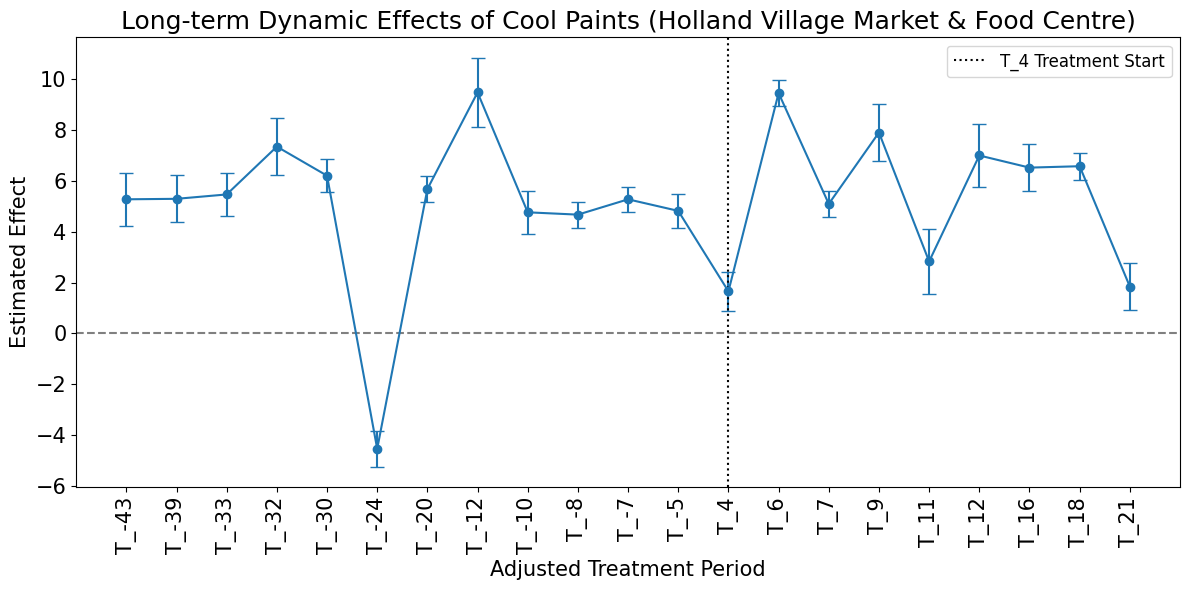

In [1067]:
def adjust_term(term, subtract_value=48):
    # Extracts the numeric part, subtracts the value, and reconstructs the term
    number = int(re.search(r'\d+', term).group())
    adjusted_number = number - subtract_value
    new_term = term.replace(str(number), str(adjusted_number))
    new_term = new_term.replace('_treatment', '')  # Remove the '_treatment' suffix
    return new_term

# Extract coefficients and standard errors
coefficients = results.params
std_errors = results.std_errors
conf_int = results.conf_int()

# Filter results to include only interaction terms
filtered_results = coefficients.loc[interaction_vars]

# Convert standard errors to 95% confidence intervals
conf_int_width = 1.96 * std_errors.loc[interaction_vars]

# Generate a DataFrame for plotting
plot_data = pd.DataFrame({
    'parameter': filtered_results,
    'std_error': std_errors.loc[interaction_vars],
    'lower': conf_int.iloc[:, 0].loc[interaction_vars],
    'upper': conf_int.iloc[:, 1].loc[interaction_vars],
    'Time_Period': [adjust_term(term) for term in interaction_vars]  # Adjust term labels
})

# Plotting
plt.figure(figsize=(12, 6))
plt.errorbar(x=plot_data['Time_Period'], y=plot_data['parameter'], yerr=conf_int_width, fmt='o-', capsize=5)
plt.axhline(0, linestyle='dashed', color='gray')

# Add a vertical line for the specific treatment period
treatment_label = 'T_4'
if treatment_label in plot_data['Time_Period'].values:
    treatment_position = plot_data['Time_Period'].tolist().index(treatment_label)
    plt.axvline(x=treatment_position, color='black', linestyle='dotted', label='T_4 Treatment Start')

plt.xticks(rotation=90)
plt.title('Long-term Dynamic Effects of Cool Paints (Holland Village Market & Food Centre)', fontsize=18)
plt.xlabel('Adjusted Treatment Period', fontsize=15)
plt.ylabel('Estimated Effect', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### North Bridge Road Market & Food Centre

In [262]:
# File paths for both Landsat 8 and Landsat 9 datasets
file_path_L8 = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\HawkerCentres\Landsat8\Hawker_Centres_Filtered_2022_to_2024.csv"
file_path_L9 = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\HawkerCentres\Landsat9\Hawker_Centres_Filtered_2022_to_2024.csv"
file_path_L7 = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\HawkerCentres\Landsat7\all_data_2022.csv"

# Load the datasets
data_L8 = pd.read_csv(file_path_L8)
data_L9 = pd.read_csv(file_path_L9)
data_L7 = pd.read_csv(file_path_L7)

# Rename temperature columns to a unified column name 'LST_Celsius'
data_L8.rename(columns={'ST_B10_Celsius': 'LST_Celsius'}, inplace=True)
data_L9.rename(columns={'ST_B10_Celsius': 'LST_Celsius'}, inplace=True)
data_L7.rename(columns={'ST_B6_Celsius': 'LST_Celsius'}, inplace=True)

# Convert 'time' column to datetime for both datasets
data_L8['time'] = pd.to_datetime(data_L8['time'])
data_L9['time'] = pd.to_datetime(data_L9['time'])
data_L7['time'] = pd.to_datetime(data_L7['time'])

# Concatenate both datasets
nbr_hawker_data = pd.concat([data_L8, data_L9, data_L7], ignore_index=True)

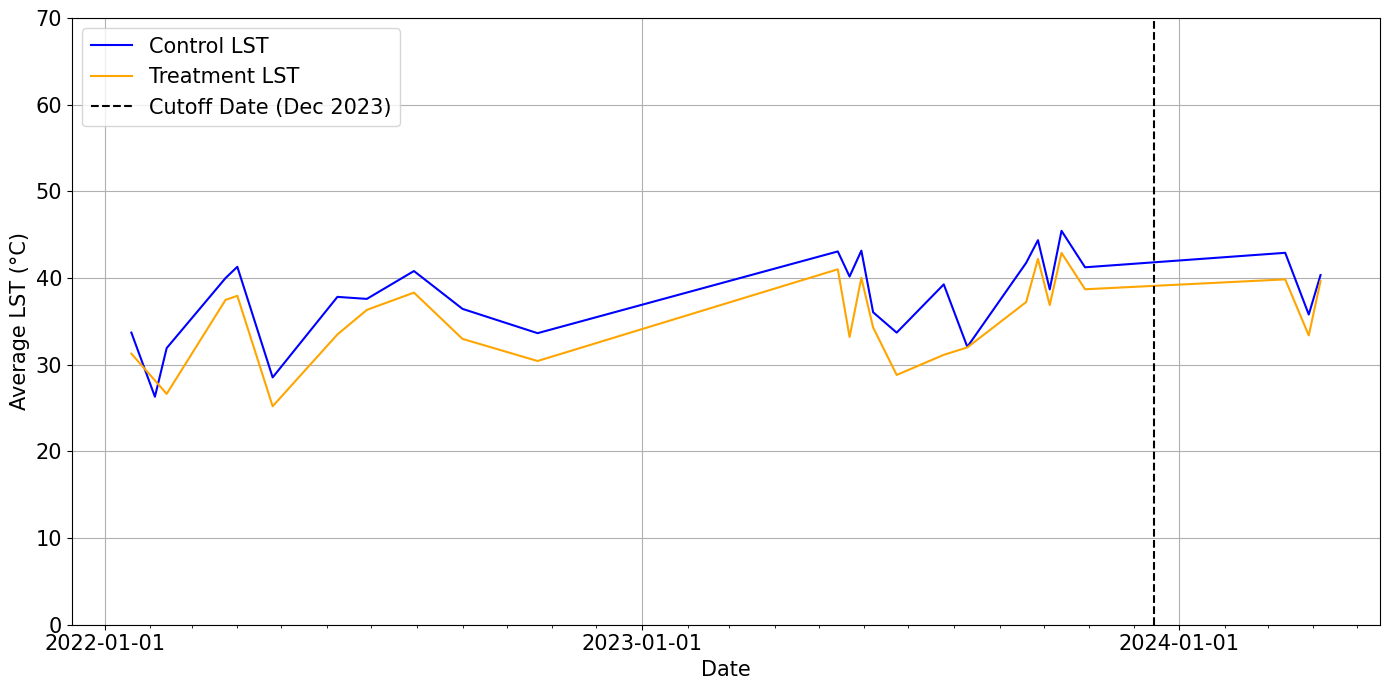

In [263]:
# List of hawker centres to be treated as "treatment"
treatment_centres = [
    "North Bridge Road Market & Food Centre"
    # "Holland Village Market & Food Centre"
    # "Commonwealth Crescent Market"
]

# Label data as 'treatment' or 'control' based on hawker centre
nbr_hawker_data['CTRL_TREATMENT'] = nbr_hawker_data['Hawker Centre'].apply(lambda x: 'treatment' if x in treatment_centres else 'control')

# Filter out unwanted QA_PIXEL values
qa_pixel_filter_2 = [5504, 5506, 22280, 5896, 55052, 7440, 7696, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 24144, 23888, 56660, 56916]
nbr_hawker_data = nbr_hawker_data[~nbr_hawker_data['QA_PIXEL'].isin(qa_pixel_filter_2)]

# Additional filtering for 'SR_QA_AEROSOL'
sr_qa_aerosol_filter_2 = [192, 194, 196]
nbr_hawker_data = nbr_hawker_data[~nbr_hawker_data['SR_QA_AEROSOL'].isin(sr_qa_aerosol_filter_2)]

# Split the data into treatment and control datasets
treatment_data = nbr_hawker_data[nbr_hawker_data['CTRL_TREATMENT'] == 'treatment']
control_data = nbr_hawker_data[nbr_hawker_data['CTRL_TREATMENT'] == 'control']

# Group by 'time' and calculate the average LST for treatment and control
average_treatment_lst = treatment_data.groupby('time')['LST_Celsius'].mean().reset_index()
average_control_lst = control_data.groupby('time')['LST_Celsius'].mean().reset_index()

# Group by 'time' and calculate the average LST for both 'treatment' and 'control'
grouped_data = nbr_hawker_data.groupby(['CTRL_TREATMENT', nbr_hawker_data['time'].dt.date])['LST_Celsius'].mean().unstack(0)

# Drop rows where any data is missing in either 'treatment' or 'control'
grouped_data.dropna(how='any', inplace=True)

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))

# Colors for each group
colors = {'treatment': 'orange', 'control': 'blue'}

# Plot each column as a line in the plot
for column in grouped_data.columns:
    ax.plot(grouped_data.index, grouped_data[column], label=f'{column.capitalize()} LST', color=colors[column])

# Formatting Date Axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Mark the treatment date
treatment_date = pd.Timestamp('2023-12-15')
plt.axvline(x=treatment_date, color='black', linestyle='--', label='Cutoff Date (Dec 2023)')

# Set plot attributes with increased font sizes
# ax.set_title('Average LST Over Time (North Bridge Road Market & Food Centre)', fontsize=20)
ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('Average LST (°C)', fontsize=15)
ax.set_ylim(bottom=0, top=70)
ax.grid(True)
ax.legend(fontsize=15)

# Adjust tick parameters
ax.tick_params(axis='both', labelsize=15)  # Adjust font size for both x and y tick labels

# Rotate date labels for clarity
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
plt.tight_layout()
plt.show()

In [124]:
# Extract the count of pixels for both the treatment and control groups
pixel_count = nbr_hawker_data.groupby(['CTRL_TREATMENT', nbr_hawker_data['time'].dt.date]).size().unstack(0)

# Drop rows where any data is missing in either 'treatment' or 'control'
pixel_count.dropna(how='any', inplace=True)

# Print out the number of pixels for the treatment centre on dates where both groups are present
print("Number of pixels (rows) for the treatment hawker centre by date:")
print(pixel_count['treatment'])
print(pixel_count['control'])

Number of pixels (rows) for the treatment hawker centre by date:
time
2022-01-19    7.0
2022-02-04    7.0
2022-02-12    7.0
2022-03-24    7.0
2022-04-01    8.0
2022-04-25    7.0
2022-06-08    6.0
2022-06-28    7.0
2022-07-30    7.0
2022-09-01    3.0
2022-10-22    7.0
2023-05-14    7.0
2023-05-22    6.0
2023-05-30    7.0
2023-06-07    6.0
2023-06-23    7.0
2023-07-25    2.0
2023-08-10    7.0
2023-09-19    7.0
2023-09-27    6.0
2023-10-05    8.0
2023-10-13    7.0
2023-10-29    6.0
2024-03-13    7.0
2024-03-29    7.0
2024-04-06    7.0
Name: treatment, dtype: float64
time
2022-01-19     379.0
2022-02-04     418.0
2022-02-12     351.0
2022-03-24    1101.0
2022-04-01     556.0
2022-04-25     463.0
2022-06-08     472.0
2022-06-28     674.0
2022-07-30     935.0
2022-09-01     618.0
2022-10-22     602.0
2023-05-14     717.0
2023-05-22     887.0
2023-05-30     645.0
2023-06-07     465.0
2023-06-23     730.0
2023-07-25     855.0
2023-08-10     549.0
2023-09-19     454.0
2023-09-27     835.0
2023-

In [125]:
# Assuming pixel_count and all_metadata are already defined and loaded

# Ensure that 'DATE_ACQUIRED' is in datetime format in the all_metadata DataFrame
all_metadata['DATE_ACQUIRED'] = pd.to_datetime(all_metadata['DATE_ACQUIRED'])

# Extract the unique dates from the pixel_count DataFrame, ensuring they are in datetime format
# Assuming pixel_count index is already in datetime format, if not, convert it
unique_dates = pixel_count.index.unique()

# Filter the all_metadata DataFrame to include only entries from the unique_dates
filtered_metadata = all_metadata[all_metadata['DATE_ACQUIRED'].isin(unique_dates)]

# Calculate the maximum CLOUD_COVER for each date
max_cloud_cover = filtered_metadata.groupby('DATE_ACQUIRED')['CLOUD_COVER'].max()

# Print or return the results
print(max_cloud_cover)

DATE_ACQUIRED
2022-01-19    49.46
2022-02-04    80.00
2022-02-12    45.03
2022-03-24    33.00
2022-04-01    13.13
2022-04-25    46.94
2022-06-08     8.00
2022-06-28    23.33
2022-07-30    35.36
2022-09-01     6.00
2022-10-22    48.00
2023-05-14    11.73
2023-05-22     6.59
2023-05-30    12.30
2023-06-07    38.67
2023-06-23    21.04
2023-07-25    12.74
2023-08-10    37.44
2023-09-19    18.61
2023-09-27    16.42
2023-10-05    20.49
2023-10-13     8.01
2023-10-29    22.04
2024-03-13     9.61
2024-03-29    42.89
2024-04-06    30.46
Name: CLOUD_COVER, dtype: float64


### Differences-in-Differences Regression

##### Coefficient of `treatment:treatment_date` is 0.9136 and is statistically significant

Block-level Analysis

In [197]:
nbr_hawker_data['group'] = np.where(nbr_hawker_data['CTRL_TREATMENT'] == 'treatment', 'Treatment', 'Control')
nbr_hawker_data['treatment'] = np.where(nbr_hawker_data['CTRL_TREATMENT'] == 'treatment', 1, 0)

# Convert 'time' column to datetime
nbr_hawker_data['time'] = pd.to_datetime(nbr_hawker_data['time'])

# Create 'time' column for post-treatment period, assigning 1 for post-treatment and 0 otherwise
cutoff_date = pd.Timestamp('2023-12-15')
nbr_hawker_data['treatment_date'] = (nbr_hawker_data['time'].dt.date >= cutoff_date.date()).astype(int)

# Ensure your DataFrame has an appropriate index for panel data analysis
nbr_hawker_data = nbr_hawker_data.set_index(['Hawker Centre', 'time'], drop=False)

# Define the formula for the regression model
formula = 'LST_Celsius ~ 1 + EntityEffects + TimeEffects + treatment:treatment_date'

# Fit the DiD regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=nbr_hawker_data)

# Print the results
results = model.fit(cov_type='clustered', cluster_entity=True)

print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                     7.254e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0135
No. Observations:               26959   R-squared (Within):            9.622e-05
Date:                Fri, Jul 19 2024   R-squared (Overall):          -2.775e-05
Time:                        10:59:32   Log-likelihood                -6.591e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.9423
Entities:                         112   P-value                           0.1634
Avg Obs:                       240.71   Distribution:                 F(1,26775)
Min Obs:                       71.000                                           
Max Obs:                       2174.0   F-statistic (robust):             38.422
                            

Pixel-level Analysis

In [233]:
nbr_hawker_data['group'] = np.where(nbr_hawker_data['CTRL_TREATMENT'] == 'treatment', 'Treatment', 'Control')
nbr_hawker_data['treatment'] = np.where(nbr_hawker_data['CTRL_TREATMENT'] == 'treatment', 1, 0)

# Assume 'block' and coordinates 'x' and 'y' uniquely identify each pixel
nbr_hawker_data['pixel_id'] = nbr_hawker_data['Hawker Centre'].astype(str) + '_' + nbr_hawker_data['Longitude'].astype(str) + '_' + nbr_hawker_data['Latitude'].astype(str)

# Convert 'time' column to datetime
nbr_hawker_data['time'] = pd.to_datetime(nbr_hawker_data['time'])

# Create 'time' column for post-treatment period, assigning 1 for post-treatment and 0 otherwise
cutoff_date = pd.Timestamp('2023-12-15')
nbr_hawker_data['treatment_date'] = (nbr_hawker_data['time'].dt.date >= cutoff_date.date()).astype(int)

# Ensure your DataFrame has an appropriate index for panel data analysis
nbr_hawker_data = nbr_hawker_data.set_index(['pixel_id', 'time'], drop=False)

# Define the formula for the regression model
formula = 'LST_Celsius ~ 1 + EntityEffects + TimeEffects + treatment:treatment_date'

# Fit the DiD regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=nbr_hawker_data)

# Print the results
results = model.fit(cov_type='clustered', cluster_entity=True)

print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                     7.862e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0029
No. Observations:               26959   R-squared (Within):            9.989e-05
Date:                Fri, Jul 19 2024   R-squared (Overall):          -2.835e-05
Time:                        12:08:47   Log-likelihood                -6.511e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.0287
Entities:                        1084   P-value                           0.1544
Avg Obs:                       24.870   Distribution:                 F(1,25803)
Min Obs:                       12.000                                           
Max Obs:                       41.000   F-statistic (robust):             30.968
                            

#### Prior Trends Test

##### The coefficient of `int_time_group` is 0.0715 and is statistically significant

In [1071]:
nbr_others = nbr_hawker_data[nbr_hawker_data['Hawker Centre'] != 'North Bridge Road Market & Food Centre']

nbr_others['LST_Celsius'].describe()

count    26789.000000
mean        37.842156
std          5.814376
min         20.008423
25%         34.422210
50%         38.735750
75%         42.177704
max         51.686615
Name: LST_Celsius, dtype: float64

In [96]:
df = nbr_hawker_data

# Define the cutoff date
cutoff_date = pd.Timestamp('2023-12-15')

# Filter the dataset to include only data before the cutoff date
df_pre = df[df['time'] < cutoff_date].copy()
df_pre['Hawker Centre'] = df_pre['Hawker Centre'] if 'block' in df_pre.columns else range(len(df_pre))

# Convert 'time' to datetime format if not already
df_pre['time'] = pd.to_datetime(df_pre['time'])

# Set the index to 'Hawker Centre' and 'time' for Panel data format
df_pre = df_pre.set_index(['Hawker Centre', 'time'])

# Create the time variable as the number of periods from the start of the data
df_pre['time_periods'] = pd.factorize(df_pre.index.get_level_values('time').date)[0]

# Create interaction term for Time * Group
df_pre['int_time_group'] = df_pre['time_periods'] * df_pre['treatment']

# Define the formula for PanelOLS
# As per Equation (18.3) in Chapter 18
formula = 'LST_Celsius ~ 1 + time_periods + treatment + int_time_group'

# Fit the regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=df_pre, check_rank=False)
fitted_model = model.fit(cov_type='clustered', cluster_entity=True)

# Print the summary of the regression model
print(fitted_model)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.0038
Estimator:                   PanelOLS   R-squared (Between):              0.0038
No. Observations:               22497   R-squared (Within):               0.0000
Date:                Wed, Jul 17 2024   R-squared (Overall):              0.0038
Time:                        23:16:01   Log-likelihood                -7.189e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      28.308
Entities:                       22497   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                 F(3,22493)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             31.443
                            

In [206]:
df = nbr_hawker_data

# Define the cutoff date
cutoff_date = pd.Timestamp('2023-12-15')

# Convert 'time' to datetime format if not already
df['time'] = pd.to_datetime(df['time'])

# Filter the dataset to include only data before and on/after the cutoff date
df_pre = df[df['time'] < cutoff_date].copy()
df_pre['Hawker Centre'] = df_pre['Hawker Centre'] if 'block' in df_pre.columns else range(len(df_pre))
df_post = df[df['time'] >= cutoff_date].copy()

# Set the index to 'Hawker Centre' and 'time' for Panel data format
df_pre = df_pre.set_index(['Hawker Centre', 'time'])
df_post = df_post.set_index(['Hawker Centre', 'time'])

# Create the time variable as the number of periods from the start of the data
df_pre['time_periods'] = pd.factorize(df_pre.index.get_level_values('time').date)[0]

# Create interaction term for Time * Group
df_pre['int_time_group'] = df_pre['time_periods'] * df_pre['treatment']

# Define the formula for PanelOLS
formula = 'LST_Celsius ~ 1 + time_periods + treatment + int_time_group'

# Fit the regression model using PanelOLS from linearmodels for both pre and post-treatment data
model_pre = PanelOLS.from_formula(formula, data=df_pre)
fitted_model_pre = model_pre.fit(cov_type='clustered', cluster_entity=True)

# Calculate the total number of observations (hawker center-time combinations) in both pre and post periods
total_observations_pre = len(df_pre)
total_observations_post = len(df_post)

# Print the summary of the regression models and the observation counts
# print(f"Pre-Treatment Model Summary:\n{fitted_model_pre}")
print(f"Total observations in pre-treatment period: {total_observations_pre}")
print(f"Total observations in post-treatment period: {total_observations_post}")

Total observations in pre-treatment period: 22497
Total observations in post-treatment period: 4462


### Long-term Effects

In [1073]:
# Sort the DataFrame by 'time' index level
nbr_hawker_data.sort_index(level='time', inplace=True)

# Creating 'time_periods' variable, factorising 'time' column
nbr_hawker_data['time_periods'] = pd.factorize(nbr_hawker_data.index.get_level_values('time').date)[0]

# Finding the first treatment_date == 1
filtered_df = nbr_hawker_data[nbr_hawker_data['treatment_date'] == 1]

# Find the earliest date in the 'time' column for these rows
earliest_date = filtered_df['time'].min()

# Get the corresponding value in 'time_periods' for the earliest date
corresponding_time_period = filtered_df[filtered_df['time'] == earliest_date]['time_periods'].iloc[0]

# Print the earliest date and the corresponding 'time_periods' value
print("The earliest date for 'treatment_date' == 1 is:", earliest_date)
print("The corresponding value in 'time_periods' is:", corresponding_time_period)

The earliest date for 'treatment_date' == 1 is: 2023-12-16 00:00:00
The corresponding value in 'time_periods' is: 60


In [1074]:
# Scale time periods, drop period right before treatment period
nbr_hawker_data['time_periods_scaled'] = nbr_hawker_data.time_periods - 59

In [1075]:
# Filtering valid time periods (where both control and treatment data exist)
#Make subset dataset. Won't be able to run with the full dataset, because in every period, the regression makes a comparison between the treatment and control, and between the indicated period and the base (omitted period).

#subset to dates with both control and treated blocks

grouped = nbr_hawker_data.groupby(['group', pd.Grouper(freq='D', level='time')]).size().unstack(fill_value=0)
both_groups_present = (grouped.loc['Treatment'] > 0) & (grouped.loc['Control'] > 0)
valid_periods = both_groups_present[both_groups_present].index
#print(valid_periods)

#Subset the data to only include periods with control and treatment group, just in case error is due to this. but it is not, i.e., doing this step or not leads to the same error

nbr_hawker_data['date'] = nbr_hawker_data['time'].dt.date  # Extract date from datetime for comparison
valid_periods_set = set(valid_periods.date)  # Convert valid periods to a set of dates for efficient filtering

# Filter the DataFrame
nbr_subset_df = nbr_hawker_data[nbr_hawker_data['date'].isin(valid_periods_set)].copy()

#See the periods that we are left

# Get all values in 'time' column
unique_time_values = nbr_subset_df['time'].unique()
print(unique_time_values)

unique_period_values = nbr_subset_df['time_periods_scaled'].unique()
print(unique_period_values)

['2022-01-19T00:00:00.000000000' '2022-02-04T00:00:00.000000000'
 '2022-02-12T00:00:00.000000000' '2022-03-24T00:00:00.000000000'
 '2022-04-01T00:00:00.000000000' '2022-04-25T00:00:00.000000000'
 '2022-06-08T00:00:00.000000000' '2022-06-28T00:00:00.000000000'
 '2022-07-30T00:00:00.000000000' '2022-09-01T00:00:00.000000000'
 '2022-10-22T00:00:00.000000000' '2023-05-14T00:00:00.000000000'
 '2023-05-22T00:00:00.000000000' '2023-05-30T00:00:00.000000000'
 '2023-06-07T00:00:00.000000000' '2023-06-23T00:00:00.000000000'
 '2023-07-25T00:00:00.000000000' '2023-08-10T00:00:00.000000000'
 '2023-09-19T00:00:00.000000000' '2023-09-27T00:00:00.000000000'
 '2023-10-05T00:00:00.000000000' '2023-10-13T00:00:00.000000000'
 '2023-10-29T00:00:00.000000000' '2024-03-13T00:00:00.000000000'
 '2024-03-29T00:00:00.000000000' '2024-04-06T00:00:00.000000000']
[-58 -56 -55 -50 -49 -47 -42 -41 -35 -31 -29 -19 -18 -17 -16 -14 -11  -9
  -7  -6  -5  -4  -3   7   9  10]


In [1076]:
#Set index again to be sure
nbr_subset_df = nbr_subset_df.set_index(['Hawker Centre', 'time_periods_scaled'], drop=False)

In [1077]:
# Ensure 'time_periods_scaled' is treated as a categorical variable
nbr_subset_df['time_periods'] = nbr_subset_df['time_periods'].astype('category')

# Create dummy variables for 'time_periods_scaled'
time_dummies = pd.get_dummies(nbr_subset_df['time_periods'], prefix='T')

time_dummies.head()

T_1  T_3  T_4  T_9  \
Hawker Centre                       time_periods_scaled                       
ABC Brickworks Market & Food Centre -58                    1    0    0    0   
                                    -58                    1    0    0    0   
                                    -58                    1    0    0    0   
                                    -58                    1    0    0    0   
                                    -58                    1    0    0    0   

                                                         T_10  T_12  T_17  \
Hawker Centre                       time_periods_scaled                     
ABC Brickworks Market & Food Centre -58                     0     0     0   
                                    -58                     0     0     0   
                                    -58                     0     0     0   
                                    -58                     0     0     0   
                                    -58                     0     0     0   

                                                         T_18  T_24  T_28  \
Hawker Centre                       time_periods_scaled                     
ABC Brickworks Market & Food Centre -58                     0     0     0   
                                    -58                     0     0     0   
                                    -58                     0     0     0   
                                    -58                     0     0     0   
                                    -58                     0     0     0   

                                                         ...  T_48  T_50  \
Hawker Centre                       time_periods_scaled  ...               
ABC Brickworks Market & Food Centre -58                  ...     0     0   
                                    -58                  ...     0     0   
                                    -58                  ...     0     0   
                                    -58                  ...     0     0   
                                    -58                  ...     0     0   

                                                         T_52  T_53  T_54  \
Hawker Centre                       time_periods_scaled                     
ABC Brickworks Market & Food Centre -58                     0     0     0   
                                    -58                     0     0     0   
                                    -58                     0     0     0   
                                    -58                     0     0     0   
                                    -58                     0     0     0   

                                                         T_55  T_56  T_66  \
Hawker Centre                       time_periods_scaled                     
ABC Brickworks Market & Food Centre -58                     0     0     0   
                                    -58                     0     0     0   
                                    -58                     0     0     0   
                                    -58                     0     0     0   
                                    -58                     0     0     0   

                                                         T_68  T_69  
Hawker Centre                       time_periods_scaled              
ABC Brickworks Market & Food Centre -58                     0     0  
                                    -58                     0     0  
                                    -58                     0     0  
                                    -58                     0     0  
                                    -58                     0     0  

[5 rows x 26 columns]

In [1078]:
# Drop one period before T_32
time_dummies.drop('T_56', axis=1, inplace=True)

# T_59 is not present in the dataframe for both control and treatment, dropped T_56 instead (latest period before treatment)
# T_56 is the baseline

In [1079]:
# Add the dummy variables to the DataFrame
nbr_subset_df = pd.concat([nbr_subset_df, time_dummies], axis=1)

In [1080]:
# Create a dictionary to hold the time values for each dummy variable
dummy_time_mapping = {}

# Iterate over each dummy variable
for dummy in time_dummies.columns:
    # Extract the 'time' values where the dummy variable is 1
    times = nbr_subset_df.loc[nbr_subset_df[dummy] == 1, 'time'].unique()
    dummy_time_mapping[dummy] = times

# Print the mapping
for dummy, times in dummy_time_mapping.items():
    print(f'{dummy}: {times}')

T_1: ['2022-01-19T00:00:00.000000000']
T_3: ['2022-02-04T00:00:00.000000000']
T_4: ['2022-02-12T00:00:00.000000000']
T_9: ['2022-03-24T00:00:00.000000000']
T_10: ['2022-04-01T00:00:00.000000000']
T_12: ['2022-04-25T00:00:00.000000000']
T_17: ['2022-06-08T00:00:00.000000000']
T_18: ['2022-06-28T00:00:00.000000000']
T_24: ['2022-07-30T00:00:00.000000000']
T_28: ['2022-09-01T00:00:00.000000000']
T_30: ['2022-10-22T00:00:00.000000000']
T_40: ['2023-05-14T00:00:00.000000000']
T_41: ['2023-05-22T00:00:00.000000000']
T_42: ['2023-05-30T00:00:00.000000000']
T_43: ['2023-06-07T00:00:00.000000000']
T_45: ['2023-06-23T00:00:00.000000000']
T_48: ['2023-07-25T00:00:00.000000000']
T_50: ['2023-08-10T00:00:00.000000000']
T_52: ['2023-09-19T00:00:00.000000000']
T_53: ['2023-09-27T00:00:00.000000000']
T_54: ['2023-10-05T00:00:00.000000000']
T_55: ['2023-10-13T00:00:00.000000000']
T_66: ['2024-03-13T00:00:00.000000000']
T_68: ['2024-03-29T00:00:00.000000000']
T_69: ['2024-04-06T00:00:00.000000000']


In [1081]:
interaction_vars = []
for col in time_dummies.columns:
    interaction_col = f'{col}_treatment'
    nbr_subset_df[interaction_col] = nbr_subset_df[col] * nbr_subset_df['treatment']
    interaction_vars.append(interaction_col)

In [1082]:
# Create the interaction terms string
interaction_terms = ' + '.join(interaction_vars)

# Display the interaction terms string
print(interaction_terms)

# Create the model formula, including the interaction terms and other covariates
formula = f'LST_Celsius ~ 1 + {interaction_terms} + EntityEffects + TimeEffects'

# Print the formula to verify
print(formula)

T_1_treatment + T_3_treatment + T_4_treatment + T_9_treatment + T_10_treatment + T_12_treatment + T_17_treatment + T_18_treatment + T_24_treatment + T_28_treatment + T_30_treatment + T_40_treatment + T_41_treatment + T_42_treatment + T_43_treatment + T_45_treatment + T_48_treatment + T_50_treatment + T_52_treatment + T_53_treatment + T_54_treatment + T_55_treatment + T_66_treatment + T_68_treatment + T_69_treatment
LST_Celsius ~ 1 + T_1_treatment + T_3_treatment + T_4_treatment + T_9_treatment + T_10_treatment + T_12_treatment + T_17_treatment + T_18_treatment + T_24_treatment + T_28_treatment + T_30_treatment + T_40_treatment + T_41_treatment + T_42_treatment + T_43_treatment + T_45_treatment + T_48_treatment + T_50_treatment + T_52_treatment + T_53_treatment + T_54_treatment + T_55_treatment + T_66_treatment + T_68_treatment + T_69_treatment + EntityEffects + TimeEffects


In [1083]:
# Fit the DiD regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=nbr_subset_df, drop_absorbed=True)

# Print the results
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.0055
Estimator:                   PanelOLS   R-squared (Between):             -0.0039
No. Observations:               17504   R-squared (Within):              -0.0003
Date:                Wed, Jul 10 2024   R-squared (Overall):          -4.781e-06
Time:                        16:24:48   Log-likelihood                -4.029e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3.8516
Entities:                         112   P-value                           0.0000
Avg Obs:                       156.29   Distribution:                F(25,17342)
Min Obs:                       44.000                                           
Max Obs:                       1007.0   F-statistic (robust):             249.64
                            

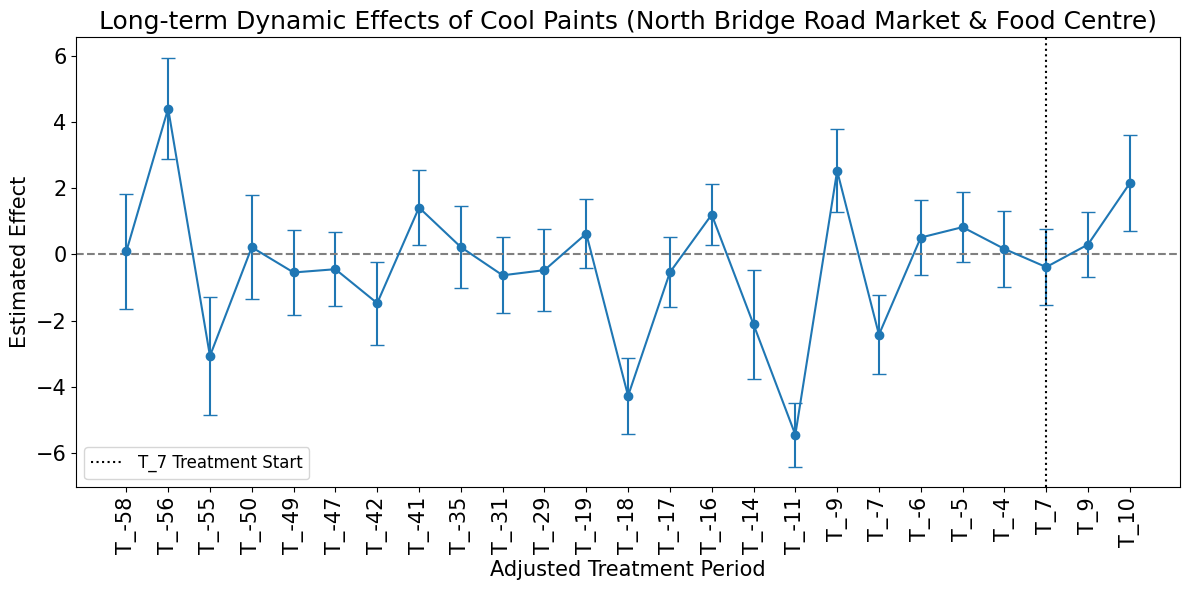

In [1084]:
def adjust_term(term, subtract_value=59):
    # Extracts the numeric part, subtracts the value, and reconstructs the term
    number = int(re.search(r'\d+', term).group())
    adjusted_number = number - subtract_value
    new_term = term.replace(str(number), str(adjusted_number))
    new_term = new_term.replace('_treatment', '')  # Remove the '_treatment' suffix
    return new_term

# Extract coefficients and standard errors
coefficients = results.params
std_errors = results.std_errors
conf_int = results.conf_int()

# Filter results to include only interaction terms
filtered_results = coefficients.loc[interaction_vars]

# Convert standard errors to 95% confidence intervals
conf_int_width = 1.96 * std_errors.loc[interaction_vars]

# Generate a DataFrame for plotting
plot_data = pd.DataFrame({
    'parameter': filtered_results,
    'std_error': std_errors.loc[interaction_vars],
    'lower': conf_int.iloc[:, 0].loc[interaction_vars],
    'upper': conf_int.iloc[:, 1].loc[interaction_vars],
    'Time_Period': [adjust_term(term) for term in interaction_vars]  # Adjust term labels
})

# Plotting
plt.figure(figsize=(12, 6))
plt.errorbar(x=plot_data['Time_Period'], y=plot_data['parameter'], yerr=conf_int_width, fmt='o-', capsize=5)
plt.axhline(0, linestyle='dashed', color='gray')

# Add a vertical line for the specific treatment period
treatment_label = 'T_7'
if treatment_label in plot_data['Time_Period'].values:
    treatment_position = plot_data['Time_Period'].tolist().index(treatment_label)
    plt.axvline(x=treatment_position, color='black', linestyle='dotted', label='T_7 Treatment Start')

plt.xticks(rotation=90)
plt.title('Long-term Dynamic Effects of Cool Paints (North Bridge Road Market & Food Centre)', fontsize=18)
plt.xlabel('Adjusted Treatment Period', fontsize=15)
plt.ylabel('Estimated Effect', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Tuas South Street 5

UNTIL 2020

Total no. of observations: 1469


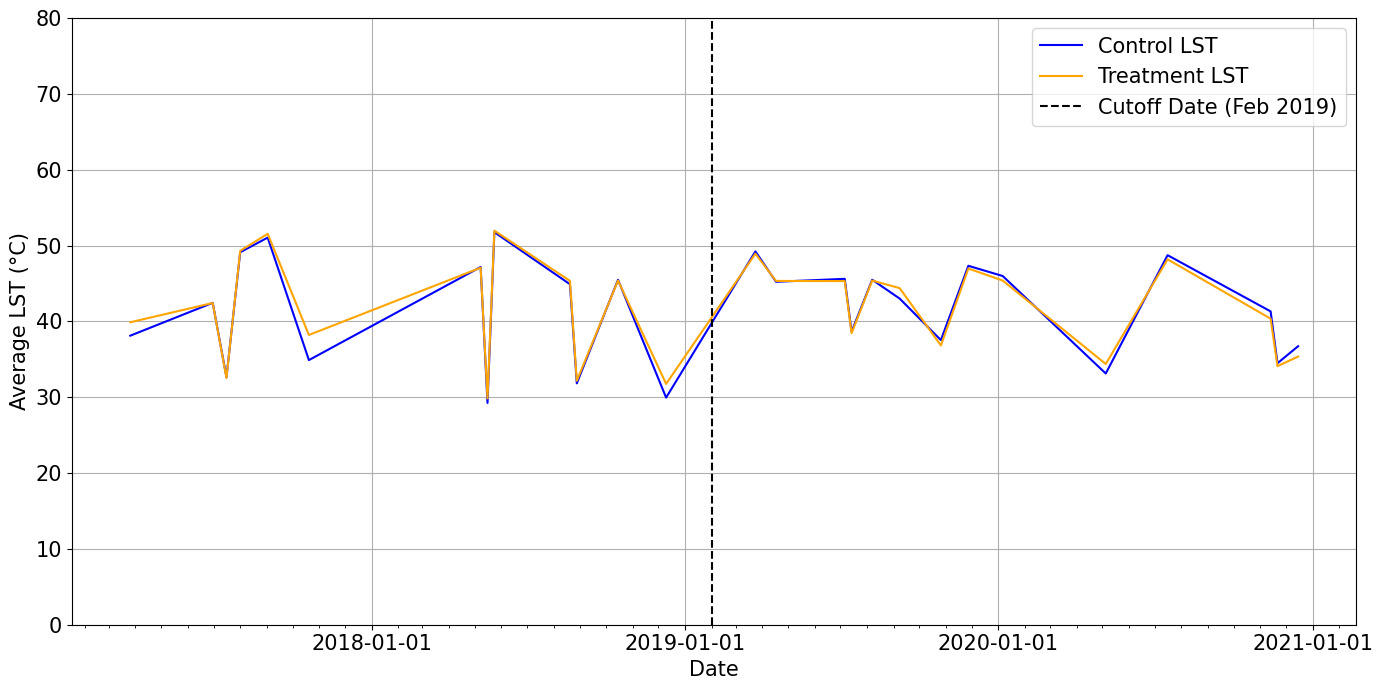

In [269]:
# Paths to the CSV files
file_path1 = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tuas\Landsat8\Tuas_Filtered_2017_to_2020.csv"
file_path2 = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tuas\Landsat7\Tuas_Filtered_2017_to_2020.csv"

# Read the CSV files
df1 = pd.read_csv(file_path1)
df2 = pd.read_csv(file_path2)

# Rename temperature columns to a unified column name
df1.rename(columns={'ST_B10_Celsius': 'LST_Celsius'}, inplace=True)
df2.rename(columns={'ST_B6_Celsius': 'LST_Celsius'}, inplace=True)

# Concatenate the three dataframes
tuas_df = pd.concat([df1, df2], ignore_index=True)

# Convert 'time' to datetime
tuas_df['time'] = pd.to_datetime(tuas_df['time'])

# Filter out unwanted QA_PIXEL values
qa_pixel_filter_1 = [5504, 5506, 54534, 54790, 22280, 5896, 55052, 7440, 7696, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 54852, 24144, 23888, 56660, 56916]
tuas_df = tuas_df[~tuas_df['QA_PIXEL'].isin(qa_pixel_filter_1)]

# Additional filtering for 'SR_QA_AEROSOL'
sr_qa_aerosol_filter_1 = [192, 194, 196, 224, 228]
tuas_df = tuas_df[~tuas_df['SR_QA_AEROSOL'].isin(sr_qa_aerosol_filter_1)]

# Map blocks to grouped blocks based on provided polygon numbers
treatment_polygons = ['8', '10', '12', '14']
control_polygons = ['6', '16', '18', '58', '60', '62', '64', '66', '68', '70', '72', '74', '18']

# Create a mapping function based on polygon suffix
def map_group(polygon):
    suffix = polygon.split('_')[-1]
    return 'Treatment' if suffix in treatment_polygons else 'Control'

tuas_df['group'] = tuas_df['BLOCK_NO'].map(map_group)

# Group by 'group' and 'time', and calculate the average LST_Celsius
grouped_data = tuas_df.groupby(['group', tuas_df['time'].dt.date])['LST_Celsius'].mean().unstack(0)
grouped_data = grouped_data.dropna(how='any', axis=0)

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))

colors = {'Treatment': 'orange', 'Control': 'blue'}

for column in grouped_data.columns:
    ax.plot(grouped_data.index, grouped_data[column], label=f'{column} LST', color=colors[column])

# Formatting Date Axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Mark the treatment date
treatment_date = pd.Timestamp('2019-02-01')
plt.axvline(x=treatment_date, color='black', linestyle='--', label='Cutoff Date (Feb 2019)')

# Set plot attributes with increased font sizes
# ax.set_title('Average LST Over Time for Tuas Area', fontsize=20)
ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('Average LST (°C)', fontsize=15)
ax.set_ylim(bottom=0, top=80)
ax.grid(True)
ax.legend(fontsize=15)

# Adjust tick parameters
ax.tick_params(axis='both', labelsize=15)  # Adjust font size for both x and y tick labels

# Rotate date labels for clarity
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
plt.tight_layout()
plt.show()

UNTIL 2024

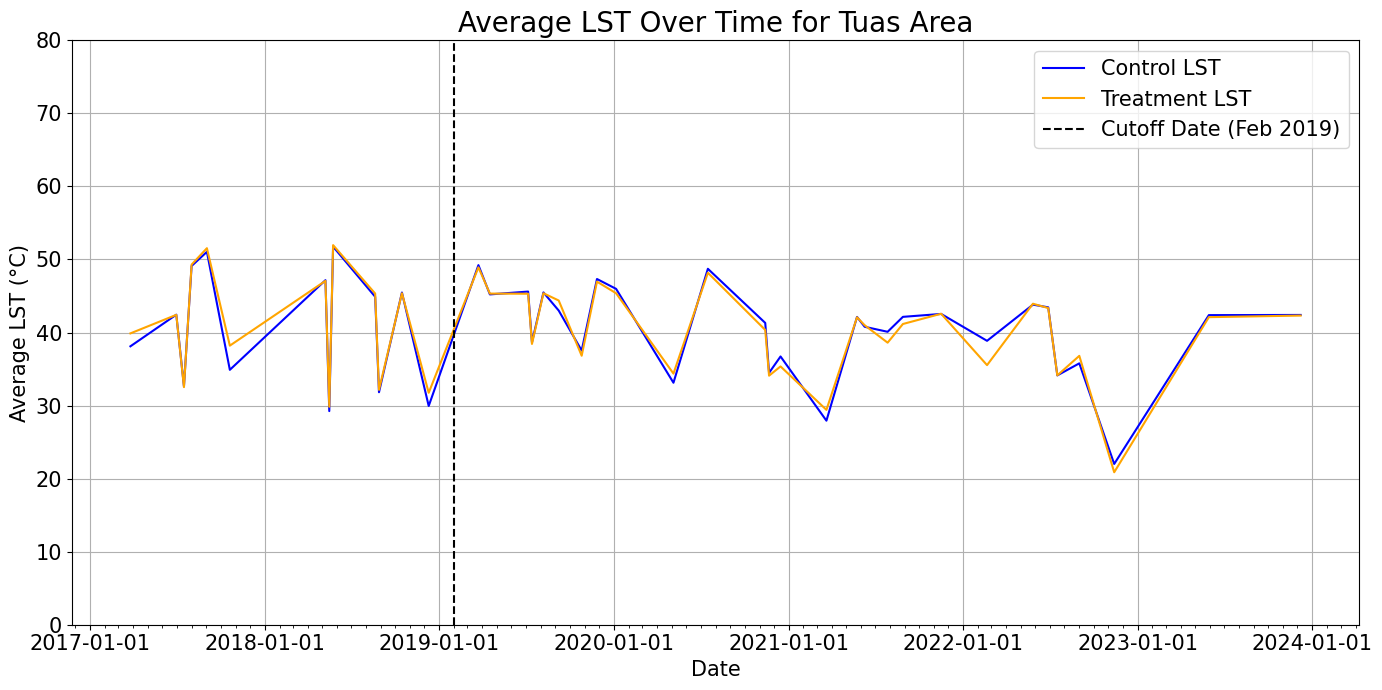

In [244]:
# Paths to the CSV files
file_path1 = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tuas\Landsat8\Tuas_Filtered_2017_to_2020.csv"
file_path2 = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tuas\Landsat7\Tuas_Filtered_2017_to_2022.csv"
file_path3 = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tuas\Landsat9\Tuas_Filtered_2021_to_2024.csv"

# Read the CSV files
df1 = pd.read_csv(file_path1)
df2 = pd.read_csv(file_path2)
df3 = pd.read_csv(file_path3)

# Rename temperature columns to a unified column name
df1.rename(columns={'ST_B10_Celsius': 'LST_Celsius'}, inplace=True)
df3.rename(columns={'ST_B10_Celsius': 'LST_Celsius'}, inplace=True)
df2.rename(columns={'ST_B6_Celsius': 'LST_Celsius'}, inplace=True)

# Concatenate the three dataframes
tuas_df_until_2024 = pd.concat([df1, df2, df3], ignore_index=True)

# Convert 'time' to datetime
tuas_df_until_2024['time'] = pd.to_datetime(tuas_df_until_2024['time'])

# Filter out unwanted QA_PIXEL values
qa_pixel_filter_1 = [5504, 5506, 54534, 54790, 22280, 5896, 55052, 7440, 7696, 23826, 56854, 24082, 56598, 7698, 7442, 54596, 54852, 24144, 23888, 56660, 56916]
tuas_df_until_2024 = tuas_df_until_2024[~tuas_df_until_2024['QA_PIXEL'].isin(qa_pixel_filter_1)]

# Additional filtering for 'SR_QA_AEROSOL'
sr_qa_aerosol_filter_1 = [192, 194, 196, 224, 228]
tuas_df_until_2024 = tuas_df_until_2024[~tuas_df_until_2024['SR_QA_AEROSOL'].isin(sr_qa_aerosol_filter_1)]

# Map blocks to grouped blocks based on provided polygon numbers
treatment_polygons = ['8', '10', '12', '14']
control_polygons = ['6', '16', '18', '58', '60', '62', '64', '66', '68', '70', '72', '74', '18']

# Create a mapping function based on polygon suffix
def map_group(polygon):
    suffix = polygon.split('_')[-1]
    return 'Treatment' if suffix in treatment_polygons else 'Control'

tuas_df_until_2024['group'] = tuas_df_until_2024['BLOCK_NO'].map(map_group)

# Group by 'group' and 'time', and calculate the average LST_Celsius
grouped_data = tuas_df_until_2024.groupby(['group', tuas_df_until_2024['time'].dt.date])['LST_Celsius'].mean().unstack(0)
grouped_data = grouped_data.dropna(how='any', axis=0)

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))

colors = {'Treatment': 'orange', 'Control': 'blue'}

for column in grouped_data.columns:
    ax.plot(grouped_data.index, grouped_data[column], label=f'{column} LST', color=colors[column])

# Formatting Date Axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Mark the treatment date
treatment_date = pd.Timestamp('2019-02-01')
plt.axvline(x=treatment_date, color='black', linestyle='--', label='Cutoff Date (Feb 2019)')

# Set plot attributes with increased font sizes
ax.set_title('Average LST Over Time for Tuas Area', fontsize=20)
ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('Average LST (°C)', fontsize=15)
ax.set_ylim(bottom=0, top=80)
ax.grid(True)
ax.legend(fontsize=15)

# Adjust tick parameters
ax.tick_params(axis='both', labelsize=15)  # Adjust font size for both x and y tick labels

# Rotate date labels for clarity
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
plt.tight_layout()
plt.show()

In [127]:
# Extract the count of pixels for both the treatment and control groups
pixel_count = tuas_df.groupby(['group', tuas_df['time'].dt.date]).size().unstack(0)

# Drop rows where any data is missing in either 'treatment' or 'control'
pixel_count.dropna(how='any', inplace=True)

# Print out the number of pixels for the treatment centre on dates where both groups are present
print("Number of pixels (rows) for the treatment blocks by date:")
print(pixel_count['Treatment'])
print(pixel_count['Control'])

Number of pixels (rows) for the treatment blocks by date:
time
2017-03-26     7.0
2017-06-30    10.0
2017-07-16    30.0
2017-08-01     1.0
2017-09-02    30.0
2017-10-20    30.0
2018-05-08     6.0
2018-05-16    28.0
2018-05-24    10.0
2018-08-20    30.0
2018-08-28     5.0
2018-10-15     4.0
2018-12-10    30.0
2019-03-24     2.0
2019-04-17    25.0
2019-07-06    30.0
2019-07-14     5.0
2019-08-07    30.0
2019-09-08    30.0
2019-10-26    16.0
2019-11-27    30.0
2020-01-06     6.0
2020-05-05    25.0
2020-07-16    10.0
2020-11-13    30.0
2020-11-21     5.0
2020-12-15     1.0
Name: Treatment, dtype: float64
time
2017-03-26     4.0
2017-06-30    33.0
2017-07-16    52.0
2017-08-01    25.0
2017-09-02    50.0
2017-10-20    63.0
2018-05-08    13.0
2018-05-16    42.0
2018-05-24    35.0
2018-08-20    63.0
2018-08-28     2.0
2018-10-15    20.0
2018-12-10    55.0
2019-03-24     1.0
2019-04-17    51.0
2019-07-06    61.0
2019-07-14     1.0
2019-08-07    59.0
2019-09-08    62.0
2019-10-26    25.0
2019-11

In [128]:
# Assuming pixel_count and all_metadata are already defined and loaded

# Ensure that 'DATE_ACQUIRED' is in datetime format in the all_metadata DataFrame
all_metadata['DATE_ACQUIRED'] = pd.to_datetime(all_metadata['DATE_ACQUIRED'])

# Extract the unique dates from the pixel_count DataFrame, ensuring they are in datetime format
# Assuming pixel_count index is already in datetime format, if not, convert it
unique_dates = pixel_count.index.unique()

# Filter the all_metadata DataFrame to include only entries from the unique_dates
filtered_metadata = all_metadata[all_metadata['DATE_ACQUIRED'].isin(unique_dates)]

# Calculate the maximum CLOUD_COVER for each date
max_cloud_cover = filtered_metadata.groupby('DATE_ACQUIRED')['CLOUD_COVER'].max()

# Print or return the results
print(max_cloud_cover)

DATE_ACQUIRED
2017-03-26    28.00
2017-06-30    28.00
2017-07-16    35.00
2017-08-01    29.00
2017-09-02    54.00
2017-10-20    80.00
2018-05-08     6.88
2018-05-16    41.00
2018-05-24     5.68
2018-08-20    39.00
2018-08-28    30.36
2018-10-15    51.23
2018-12-10    46.00
2019-03-24    51.16
2019-04-17    30.00
2019-07-06    14.00
2019-07-14    32.63
2019-08-07    41.00
2019-09-08    14.00
2019-10-26    79.00
2019-11-27    53.00
2020-01-06    36.24
2020-05-05    13.00
2020-07-16    10.68
2020-11-13    17.00
2020-11-21    68.52
2020-12-15    37.00
Name: CLOUD_COVER, dtype: float64


### Differences-in-Differences Regression (until 2020)

##### The coefficient of `treatment:treatment_date` is -0.9163 and is statistically significant

Block-level Analysis

In [249]:
tuas_df['Treatment'] = np.where(tuas_df['group'] == 'Treatment', 1, 0)

# Convert 'time' column to datetime if it's not already
tuas_df['time'] = pd.to_datetime(tuas_df['time'])

# Create 'time' column for post-treatment period, assigning 1 for post-treatment and 0 otherwise
cutoff_date = pd.Timestamp('2019-02-01')
tuas_df['treatment_date'] = (tuas_df['time'].dt.date >= cutoff_date.date()).astype(int)

# Ensure your DataFrame has an appropriate index for panel data analysis
tuas_df = tuas_df.set_index(['BLOCK_NO', 'time'], drop=False)

In [250]:
# Define the formula for the regression model
formula = 'LST_Celsius ~ 1 + EntityEffects + TimeEffects + Treatment:treatment_date'

# Fit the DiD regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=tuas_df)

# Print the results
results = model.fit(cov_type='clustered', cluster_entity=True)

print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.0193
Estimator:                   PanelOLS   R-squared (Between):              0.0311
No. Observations:                1469   R-squared (Within):              -0.0121
Date:                Fri, Jul 19 2024   R-squared (Overall):             -0.0085
Time:                        13:09:20   Log-likelihood                   -2645.6
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      27.974
Entities:                          16   P-value                           0.0000
Avg Obs:                       91.812   Distribution:                  F(1,1420)
Min Obs:                       55.000                                           
Max Obs:                       139.00   F-statistic (robust):             5.0357
                            

Pixel-level Analysis

In [235]:
tuas_df['Treatment'] = np.where(tuas_df['group'] == 'Treatment', 1, 0)

# Assume 'block' and coordinates 'x' and 'y' uniquely identify each pixel
tuas_df['pixel_id'] = tuas_df['BLOCK_NO'].astype(str) + '_' + tuas_df['Longitude'].astype(str) + '_' + tuas_df['Latitude'].astype(str)

# Convert 'time' column to datetime if it's not already
tuas_df['time'] = pd.to_datetime(tuas_df['time'])

# Create 'time' column for post-treatment period, assigning 1 for post-treatment and 0 otherwise
cutoff_date = pd.Timestamp('2019-02-01')
tuas_df['treatment_date'] = (tuas_df['time'].dt.date >= cutoff_date.date()).astype(int)

# Ensure your DataFrame has an appropriate index for panel data analysis
tuas_df = tuas_df.set_index(['pixel_id', 'time'], drop=False)

In [236]:
# Define the formula for the regression model
formula = 'LST_Celsius ~ 1 + EntityEffects + TimeEffects + Treatment:treatment_date'

# Fit the DiD regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=tuas_df)

# Print the results
results = model.fit(cov_type='clustered', cluster_entity=True)

print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.0235
Estimator:                   PanelOLS   R-squared (Between):              0.0451
No. Observations:                1469   R-squared (Within):              -0.0122
Date:                Fri, Jul 19 2024   R-squared (Overall):             -0.0082
Time:                        12:09:45   Log-likelihood                   -2460.6
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      32.364
Entities:                          93   P-value                           0.0000
Avg Obs:                       15.796   Distribution:                  F(1,1343)
Min Obs:                       13.000                                           
Max Obs:                       20.000   F-statistic (robust):             17.451
                            

### Differences-in-Differences Regression (until 2024)

##### The coefficient of `treatment:treatment_date` is -0.9163 and is statistically significant

Block-level Analysis

In [251]:
tuas_df_until_2024['Treatment'] = np.where(tuas_df_until_2024['group'] == 'Treatment', 1, 0)

# Convert 'time' column to datetime if it's not already
tuas_df_until_2024['time'] = pd.to_datetime(tuas_df_until_2024['time'])

# Create 'time' column for post-treatment period, assigning 1 for post-treatment and 0 otherwise
cutoff_date = pd.Timestamp('2019-02-01')
tuas_df_until_2024['treatment_date'] = (tuas_df_until_2024['time'].dt.date >= cutoff_date.date()).astype(int)

# Ensure your DataFrame has an appropriate index for panel data analysis
tuas_df_until_2024 = tuas_df_until_2024.set_index(['BLOCK_NO', 'time'], drop=False)

In [253]:
# Define the formula for the regression model
formula = 'LST_Celsius ~ 1 + EntityEffects + TimeEffects + Treatment:treatment_date'

# Fit the DiD regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=tuas_df_until_2024)

# Print the results
results = model.fit(cov_type='clustered', cluster_entity=True)

print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.0261
Estimator:                   PanelOLS   R-squared (Between):             -0.0205
No. Observations:                2123   R-squared (Within):              -0.0076
Date:                Fri, Jul 19 2024   R-squared (Overall):             -0.0067
Time:                        13:09:36   Log-likelihood                   -3633.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      55.083
Entities:                          16   P-value                           0.0000
Avg Obs:                       132.69   Distribution:                  F(1,2055)
Min Obs:                       81.000                                           
Max Obs:                       215.00   F-statistic (robust):             7.6144
                            

Pixel-level Analysis

In [254]:
tuas_df_until_2024['Treatment'] = np.where(tuas_df_until_2024['group'] == 'Treatment', 1, 0)

# Assume 'block' and coordinates 'x' and 'y' uniquely identify each pixel
tuas_df_until_2024['pixel_id'] = tuas_df_until_2024['BLOCK_NO'].astype(str) + '_' + tuas_df_until_2024['Longitude'].astype(str) + '_' + tuas_df_until_2024['Latitude'].astype(str)

# Convert 'time' column to datetime if it's not already
tuas_df_until_2024['time'] = pd.to_datetime(tuas_df_until_2024['time'])

# Create 'time' column for post-treatment period, assigning 1 for post-treatment and 0 otherwise
cutoff_date = pd.Timestamp('2019-02-01')
tuas_df_until_2024['treatment_date'] = (tuas_df_until_2024['time'].dt.date >= cutoff_date.date()).astype(int)

# Ensure your DataFrame has an appropriate index for panel data analysis
tuas_df_until_2024 = tuas_df_until_2024.set_index(['pixel_id', 'time'], drop=False)

In [255]:
# Define the formula for the regression model
formula = 'LST_Celsius ~ 1 + EntityEffects + TimeEffects + Treatment:treatment_date'

# Fit the DiD regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=tuas_df_until_2024)

# Print the results
results = model.fit(cov_type='clustered', cluster_entity=True)

print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.0334
Estimator:                   PanelOLS   R-squared (Between):              0.0183
No. Observations:                2123   R-squared (Within):              -0.0077
Date:                Fri, Jul 19 2024   R-squared (Overall):             -0.0065
Time:                        13:10:39   Log-likelihood                   -3319.0
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      68.442
Entities:                          93   P-value                           0.0000
Avg Obs:                       22.828   Distribution:                  F(1,1978)
Min Obs:                       17.000                                           
Max Obs:                       30.000   F-statistic (robust):             26.704
                            

#### Prior Trends Test

##### The coefficient of `int_time_group` is 0.2007 and is not statistically significant

In [1088]:
df = tuas_df

# Define the cutoff date
cutoff_date = pd.Timestamp('2019-02-01')

# Filter the dataset to include only data before the cutoff date
df_pre = df[df['time'] < cutoff_date].copy()

# Convert 'time' to datetime format if not already
df_pre['time'] = pd.to_datetime(df_pre['time'])

# Set the index to 'Hawker Centre' and 'time' for Panel data format
df_pre = df_pre.set_index(['BLOCK_NO', 'time'])

# Create the time variable as the number of periods from the start of the data
df_pre['time_periods'] = pd.factorize(df_pre.index.get_level_values('time').date)[0]

# Create interaction term for Time * Group
df_pre['int_time_group'] = df_pre['time_periods'] * df_pre['Treatment']

# Define the formula for PanelOLS
# As per Equation (18.3) in Chapter 18
formula = 'LST_Celsius ~ 1 + time_periods + Treatment + int_time_group'

# Fit the regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=df_pre, check_rank=False)
fitted_model = model.fit(cov_type='clustered', cluster_entity=True)

# Print the summary of the regression model
print(fitted_model)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.1698
Estimator:                   PanelOLS   R-squared (Between):              0.4783
No. Observations:                 728   R-squared (Within):               0.1471
Date:                Wed, Jul 10 2024   R-squared (Overall):              0.1698
Time:                        16:25:31   Log-likelihood                   -2520.1
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      49.356
Entities:                          16   P-value                           0.0000
Avg Obs:                       45.500   Distribution:                   F(3,724)
Min Obs:                       26.000                                           
Max Obs:                       65.000   F-statistic (robust):             154.05
                            

In [207]:
df = tuas_df

# Define the cutoff date for treatment
cutoff_date = pd.Timestamp('2019-02-01')

# Convert 'time' to datetime format if not already
df['time'] = pd.to_datetime(df['time'])

# Filter the dataset to include only data before and on/after the cutoff date
df_pre = df[df['time'] < cutoff_date].copy()
df_post = df[df['time'] >= cutoff_date].copy()

# Set the index to 'block' and 'time' for Panel data format for both periods
df_pre = df_pre.set_index(['BLOCK_NO', 'time'])
df_post = df_post.set_index(['BLOCK_NO', 'time'])

# Create the time variable as the number of periods from the start of the data
df_pre['time_periods'] = pd.factorize(df_pre.index.get_level_values('time').date)[0]

# Create interaction term for Time * Group for both datasets
df_pre['group_binary'] = df_pre['group'].map({'Treatment': 1, 'Control': 0})
df_pre['int_time_group'] = df_pre['time_periods'] * df_pre['group_binary']

# Define the formula for PanelOLS
formula = 'LST_Celsius ~ 1 + time_periods + group_binary + int_time_group'

# Fit the regression model using PanelOLS from linearmodels for both pre and post-treatment data
model_pre = PanelOLS.from_formula(formula, data=df_pre)
fitted_model_pre = model_pre.fit(cov_type='clustered', cluster_entity=True)

# Calculate the total number of observations (block-time combinations) in both pre and post periods
total_observations_pre = len(df_pre)
total_observations_post = len(df_post)

# Print the summary of the regression models and the observation counts
# print(f"Pre-Treatment Model Summary:\n{fitted_model_pre}")
print(f"Total observations in pre-treatment period: {total_observations_pre}")
print(f"Total observations in post-treatment period: {total_observations_post}")

Total observations in pre-treatment period: 728
Total observations in post-treatment period: 741


### Long-term Effects

In [1089]:
# Sort the DataFrame by 'time' index level
tuas_df.sort_index(level='time', inplace=True)

# Creating 'time_periods' variable, factorising 'time' column
tuas_df['time_periods'] = pd.factorize(tuas_df.index.get_level_values('time').date)[0]

# Finding the first treatment_date == 1
filtered_df = tuas_df[tuas_df['treatment_date'] == 1]

# Find the earliest date in the 'time' column for these rows
earliest_date = filtered_df['time'].min()

# Get the corresponding value in 'time_periods' for the earliest date
corresponding_time_period = filtered_df[filtered_df['time'] == earliest_date]['time_periods'].iloc[0]

# Print the earliest date and the corresponding 'time_periods' value
print("The earliest date for 'treatment_date' == 1 is:", earliest_date)
print("The corresponding value in 'time_periods' is:", corresponding_time_period)

The earliest date for 'treatment_date' == 1 is: 2019-03-24 00:00:00
The corresponding value in 'time_periods' is: 17


In [1090]:
# Scale time periods, drop period right before treatment period
tuas_df['time_periods_scaled'] = tuas_df.time_periods - 16

In [1091]:
# Filtering valid time periods (where both control and treatment data exist)
#Make subset dataset. Won't be able to run with the full dataset, because in every period, the regression makes a comparison between the treatment and control, and between the indicated period and the base (omitted period).

#subset to dates with both control and treated blocks

grouped = tuas_df.groupby(['group', pd.Grouper(freq='D', level='time')]).size().unstack(fill_value=0)
both_groups_present = (grouped.loc['Treatment'] > 0) & (grouped.loc['Control'] > 0)
valid_periods = both_groups_present[both_groups_present].index
#print(valid_periods)

#Subset the data to only include periods with control and treatment group, just in case error is due to this. but it is not, i.e., doing this step or not leads to the same error

tuas_df['date'] = tuas_df['time'].dt.date  # Extract date from datetime for comparison
valid_periods_set = set(valid_periods.date)  # Convert valid periods to a set of dates for efficient filtering

# Filter the DataFrame
tuas_subset_df = tuas_df[tuas_df['date'].isin(valid_periods_set)].copy()

#See the periods that we are left

# Get all values in 'time' column
unique_time_values = tuas_subset_df['time'].unique()
print(unique_time_values)

unique_period_values = tuas_subset_df['time_periods_scaled'].unique()
print(unique_period_values)

['2017-03-26T00:00:00.000000000' '2017-06-30T00:00:00.000000000'
 '2017-07-16T00:00:00.000000000' '2017-08-01T00:00:00.000000000'
 '2017-09-02T00:00:00.000000000' '2017-10-20T00:00:00.000000000'
 '2018-05-08T00:00:00.000000000' '2018-05-16T00:00:00.000000000'
 '2018-05-24T00:00:00.000000000' '2018-08-20T00:00:00.000000000'
 '2018-08-28T00:00:00.000000000' '2018-10-15T00:00:00.000000000'
 '2018-12-10T00:00:00.000000000' '2019-03-24T00:00:00.000000000'
 '2019-04-17T00:00:00.000000000' '2019-07-06T00:00:00.000000000'
 '2019-07-14T00:00:00.000000000' '2019-08-07T00:00:00.000000000'
 '2019-09-08T00:00:00.000000000' '2019-10-26T00:00:00.000000000'
 '2019-11-27T00:00:00.000000000' '2020-01-06T00:00:00.000000000'
 '2020-05-05T00:00:00.000000000' '2020-07-16T00:00:00.000000000'
 '2020-11-13T00:00:00.000000000' '2020-11-21T00:00:00.000000000'
 '2020-12-15T00:00:00.000000000']
[-16 -14 -13 -12 -11 -10  -7  -6  -5  -3  -2  -1   0   1   2   3   4   5
   6   7   8  10  12  13  14  15  16]


In [1092]:
#Set index again to be sure
tuas_subset_df = tuas_subset_df.set_index(['BLOCK_NO', 'time_periods_scaled'], drop=False)

In [1093]:
# Ensure 'time_periods_scaled' is treated as a categorical variable
tuas_subset_df['time_periods'] = tuas_subset_df['time_periods'].astype('category')

# Create dummy variables for 'time_periods_scaled'
time_dummies = pd.get_dummies(tuas_subset_df['time_periods'], prefix='T')

time_dummies.head()

T_0  T_2  T_3  T_4  T_5  T_6  T_9  T_10  T_11  \
BLOCK_NO   time_periods_scaled                                                  
polygon_10 -16                    1    0    0    0    0    0    0     0     0   
           -16                    1    0    0    0    0    0    0     0     0   
polygon_12 -16                    1    0    0    0    0    0    0     0     0   
           -16                    1    0    0    0    0    0    0     0     0   
           -16                    1    0    0    0    0    0    0     0     0   

                                T_13  ...  T_21  T_22  T_23  T_24  T_26  T_28  \
BLOCK_NO   time_periods_scaled        ...                                       
polygon_10 -16                     0  ...     0     0     0     0     0     0   
           -16                     0  ...     0     0     0     0     0     0   
polygon_12 -16                     0  ...     0     0     0     0     0     0   
           -16                     0  ...     0     0     0     0     0     0   
           -16                     0  ...     0     0     0     0     0     0   

                                T_29  T_30  T_31  T_32  
BLOCK_NO   time_periods_scaled                          
polygon_10 -16                     0     0     0     0  
           -16                     0     0     0     0  
polygon_12 -16                     0     0     0     0  
           -16                     0     0     0     0  
           -16                     0     0     0     0  

[5 rows x 27 columns]

In [1094]:
# Drop one period before T_32
time_dummies.drop('T_16', axis=1, inplace=True)

In [1095]:
# Add the dummy variables to the DataFrame
tuas_subset_df = pd.concat([tuas_subset_df, time_dummies], axis=1)

In [1096]:
# Create a dictionary to hold the time values for each dummy variable
dummy_time_mapping = {}

# Iterate over each dummy variable
for dummy in time_dummies.columns:
    # Extract the 'time' values where the dummy variable is 1
    times = tuas_subset_df.loc[tuas_subset_df[dummy] == 1, 'time'].unique()
    dummy_time_mapping[dummy] = times

# Print the mapping
for dummy, times in dummy_time_mapping.items():
    print(f'{dummy}: {times}')

T_0: ['2017-03-26T00:00:00.000000000']
T_2: ['2017-06-30T00:00:00.000000000']
T_3: ['2017-07-16T00:00:00.000000000']
T_4: ['2017-08-01T00:00:00.000000000']
T_5: ['2017-09-02T00:00:00.000000000']
T_6: ['2017-10-20T00:00:00.000000000']
T_9: ['2018-05-08T00:00:00.000000000']
T_10: ['2018-05-16T00:00:00.000000000']
T_11: ['2018-05-24T00:00:00.000000000']
T_13: ['2018-08-20T00:00:00.000000000']
T_14: ['2018-08-28T00:00:00.000000000']
T_15: ['2018-10-15T00:00:00.000000000']
T_17: ['2019-03-24T00:00:00.000000000']
T_18: ['2019-04-17T00:00:00.000000000']
T_19: ['2019-07-06T00:00:00.000000000']
T_20: ['2019-07-14T00:00:00.000000000']
T_21: ['2019-08-07T00:00:00.000000000']
T_22: ['2019-09-08T00:00:00.000000000']
T_23: ['2019-10-26T00:00:00.000000000']
T_24: ['2019-11-27T00:00:00.000000000']
T_26: ['2020-01-06T00:00:00.000000000']
T_28: ['2020-05-05T00:00:00.000000000']
T_29: ['2020-07-16T00:00:00.000000000']
T_30: ['2020-11-13T00:00:00.000000000']
T_31: ['2020-11-21T00:00:00.000000000']
T_32: [

In [1097]:
interaction_vars = []
for col in time_dummies.columns:
    interaction_col = f'{col}_treatment'
    tuas_subset_df[interaction_col] = tuas_subset_df[col] * tuas_subset_df['Treatment']
    interaction_vars.append(interaction_col)

In [1098]:
# Create the interaction terms string
interaction_terms = ' + '.join(interaction_vars)

# Display the interaction terms string
print(interaction_terms)

# Create the model formula, including the interaction terms and other covariates
formula = f'LST_Celsius ~ 1 + {interaction_terms} + EntityEffects + TimeEffects'

# Print the formula to verify
print(formula)

T_0_treatment + T_2_treatment + T_3_treatment + T_4_treatment + T_5_treatment + T_6_treatment + T_9_treatment + T_10_treatment + T_11_treatment + T_13_treatment + T_14_treatment + T_15_treatment + T_17_treatment + T_18_treatment + T_19_treatment + T_20_treatment + T_21_treatment + T_22_treatment + T_23_treatment + T_24_treatment + T_26_treatment + T_28_treatment + T_29_treatment + T_30_treatment + T_31_treatment + T_32_treatment
LST_Celsius ~ 1 + T_0_treatment + T_2_treatment + T_3_treatment + T_4_treatment + T_5_treatment + T_6_treatment + T_9_treatment + T_10_treatment + T_11_treatment + T_13_treatment + T_14_treatment + T_15_treatment + T_17_treatment + T_18_treatment + T_19_treatment + T_20_treatment + T_21_treatment + T_22_treatment + T_23_treatment + T_24_treatment + T_26_treatment + T_28_treatment + T_29_treatment + T_30_treatment + T_31_treatment + T_32_treatment + EntityEffects + TimeEffects


In [1099]:
# Fit the DiD regression model using PanelOLS from linearmodels
model = PanelOLS.from_formula(formula, data=tuas_subset_df, drop_absorbed=True)

# Print the results
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:            LST_Celsius   R-squared:                        0.1034
Estimator:                   PanelOLS   R-squared (Between):             -0.1109
No. Observations:                1415   R-squared (Within):              -0.0322
Date:                Wed, Jul 10 2024   R-squared (Overall):             -0.0321
Time:                        16:25:48   Log-likelihood                   -2502.3
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.9765
Entities:                          16   P-value                           0.0000
Avg Obs:                       88.438   Distribution:                 F(26,1347)
Min Obs:                       55.000                                           
Max Obs:                       138.00   F-statistic (robust):         -4.134e+14
                            

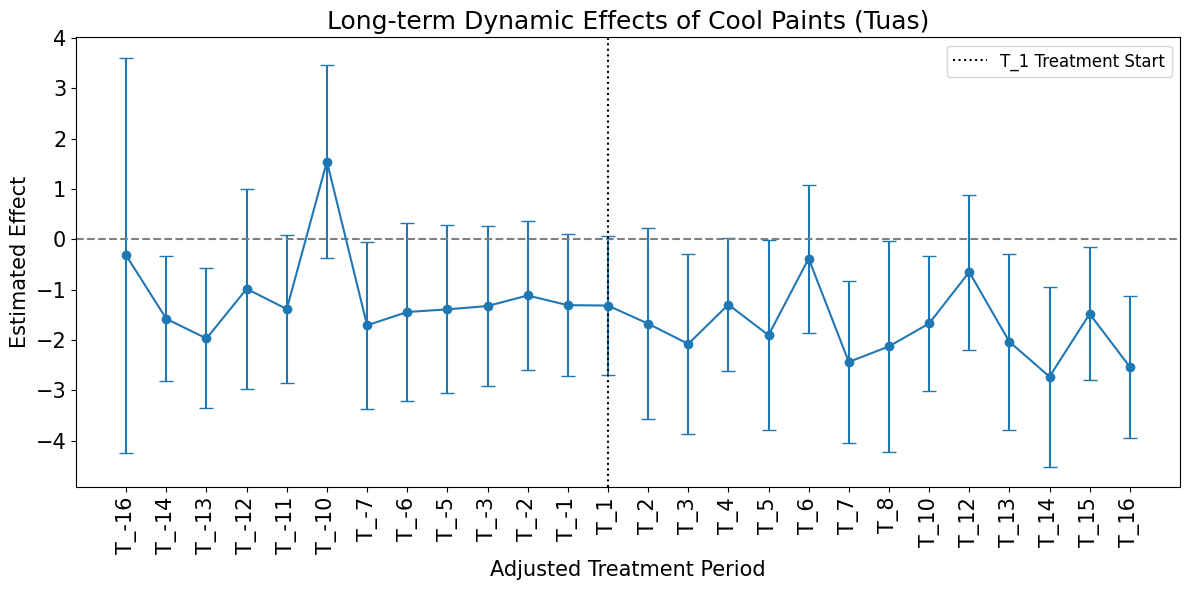

In [1100]:
def adjust_term(term, subtract_value=16):
    # Extracts the numeric part, subtracts the value, and reconstructs the term
    number = int(re.search(r'\d+', term).group())
    adjusted_number = number - subtract_value
    new_term = term.replace(str(number), str(adjusted_number))
    new_term = new_term.replace('_treatment', '')  # Remove the '_treatment' suffix
    return new_term

# Extract coefficients and standard errors
coefficients = results.params
std_errors = results.std_errors
conf_int = results.conf_int()

# Filter results to include only interaction terms
filtered_results = coefficients.loc[interaction_vars]

# Convert standard errors to 95% confidence intervals
conf_int_width = 1.96 * std_errors.loc[interaction_vars]

# Generate a DataFrame for plotting
plot_data = pd.DataFrame({
    'parameter': filtered_results,
    'std_error': std_errors.loc[interaction_vars],
    'lower': conf_int.iloc[:, 0].loc[interaction_vars],
    'upper': conf_int.iloc[:, 1].loc[interaction_vars],
    'Time_Period': [adjust_term(term) for term in interaction_vars]  # Adjust term labels
})

# Plotting
plt.figure(figsize=(12, 6))
plt.errorbar(x=plot_data['Time_Period'], y=plot_data['parameter'], yerr=conf_int_width, fmt='o-', capsize=5)
plt.axhline(0, linestyle='dashed', color='gray')

# Add a vertical line for the specific treatment period
treatment_label = 'T_1'
if treatment_label in plot_data['Time_Period'].values:
    treatment_position = plot_data['Time_Period'].tolist().index(treatment_label)
    plt.axvline(x=treatment_position, color='black', linestyle='dotted', label='T_1 Treatment Start')

plt.xticks(rotation=90)
plt.title('Long-term Dynamic Effects of Cool Paints (Tuas)', fontsize=18)
plt.xlabel('Adjusted Treatment Period', fontsize=15)
plt.ylabel('Estimated Effect', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()